In [1]:
# Imports 
import numpy as np
from numpy import *
from scipy.special import erf
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import factorial2 as fact2
import itertools
import time

In [2]:
class BasisFunction:
    ''' A class that contains all our basis function data
            Attributes:
            origin: array/list containing the coordinates of the Gaussian origin
            shell:  tuple of angular momentum
            exps:   list of primitive Gaussian exponents
            coefs:  list of primitive Gaussian coefficients
            norm:   list of normalization factors for Gaussian primitives
    '''
    def __init__(self,origin=[0.0,0.0,0.0],shell=(0,0,0),exps=[],coefs=[]): 
        self.origin = np.asarray(origin)
        self.shell = shell
        self.exps = exps
        self.coefs = coefs
        self.norm = None
        self.normalize()
        
    def normalize(self):
        ''' Routine to normalize the basis functions, in case they
                    do not integrate to unity.
                '''
        l,m,n = self.shell
        L = l+m+n
        # self.norm is a list of length equal to number primitives 
        # normalize primitives first (PGBFs)
        self.norm = np.sqrt(np.power(2,2*(l+m+n)+1.5)*\
                            np.power(self.exps,l+m+n+1.5)/fact2(2*l-1)/fact2(2*m-1)/fact2(2*n-1)/np.power(np.pi,1.5))
        # now normalize the contracted basis functions (CGBFs) # Eq. 1.44 of Valeev integral whitepaper
        prefactor = np.power(np.pi,1.5)*\
                fact2(2*l - 1)*fact2(2*m - 1)*fact2(2*n - 1)/np.power(2.0,L)
        N = 0.0
        num_exps = len(self.exps) 
        for ia in range(num_exps):
            for ib in range(num_exps):
                N += self.norm[ia]*self.norm[ib]*self.coefs[ia]*self.coefs[ib]/np.power(self.exps[ia] + self.exps[ib],L+1.5)
        N *= prefactor
        N = np.power(N,-0.5)
        for ia in range(num_exps):
            self.coefs[ia] *= N
            
    def basisfcn_matrix(self,xdom,ydom,zdom):
        ''' Method that returns a 3-dimensional matrix corresponding to the 
            3D basis function evaluated in space on over a domain (xdom,ydom,zdom)
        '''
        l,m,n = self.shell
        xi = self.exps  
        G = np.zeros((len(xdom),len(ydom),len(zdom)))
        for i in range(len(xi)):
            gauss_x = xdom**l*np.exp(-xi[i]*xdom**2)
            gauss_y = ydom**m*np.exp(-xi[i]*ydom**2)
            gauss_z = zdom**n*np.exp(-xi[i]*zdom**2)
            Temp = np.kron(gauss_z,np.kron(gauss_y,gauss_x))
            G += self.coefs[i]*np.reshape(Temp,[len(xdom),len(ydom),len(zdom)])
            
        return G
            
            
            

In [3]:
def E(i,j,t,Qx,a,b):
    ''' Recursive definition of Hermite Gaussian coefficients.
            Returns a float.
            a: orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b: orbital exponent on Gaussian 'b' (e.g. beta in the text)
            i,j: orbital angular momentum number on Gaussian 'a' and 'b'
            t: number nodes in Hermite (depends on type of integral,
               e.g. always zero for overlap integrals)
            Qx: distance between origins of Gaussian 'a' and 'b'
    '''
    p=a+b
    q = a*b/p
    if (t < 0) or (t > (i + j)): # out of bounds for t
        return 0.0
    elif i == j == t == 0: # base case
        return np.exp(-q*Qx*Qx) # K_AB 
    elif j == 0: # decrement index i
        return (1/(2*p))*E(i-1,j,t-1,Qx,a,b) -  (q*Qx/a)*E(i-1,j,t,Qx,a,b) +  (t+1)*E(i-1,j,t+1,Qx,a,b)
    else: # decrement index j
        return (1/(2*p))*E(i,j-1,t-1,Qx,a,b) +  (q*Qx/b)*E(i,j-1,t,Qx,a,b) +  (t+1)*E(i,j-1,t+1,Qx,a,b)
            
def overlap(a,lmn1,A,b,lmn2,B):
    ''' Evaluates overlap integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    l1,m1,n1 = lmn1 # shell angular momentum on Gaussian 'a' 
    l2,m2,n2 = lmn2 # shell angular momentum on Gaussian 'b' 
    S1 = E(l1,l2,0,A[0]-B[0],a,b) # X
    S2 = E(m1,m2,0,A[1]-B[1],a,b) # Y
    S3 = E(n1,n2,0,A[2]-B[2],a,b) # Z
    return S1*S2*S3*np.power(np.pi/(a+b),1.5)

def kinetic(a,lmn1,A,b,lmn2,B):
    ''' Evaluates kinetic energy integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    
    term0 = b*(2*(l2+m2+n2)+3)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2),B)
    
    term1 = -2*np.power(b,2)*(overlap(a,(l1,m1,n1),A,b,(l2+2,m2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2+2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2,n2+2),B))
    
    term2 = -0.5*(l2*(l2-1)*overlap(a,(l1,m1,n1),A,b,(l2-2,m2,n2),B) +
                  m2*(m2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2-2,n2),B) +
                  n2*(n2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2-2),B)) 
    
    return term0+term1+term2

def R(t,u,v,n,p,PCx,PCy,PCz,RPC):
    ''' Returns the Coulomb auxiliary Hermite integrals
            Returns a float.
            Arguments:
            t,u,v:   order of Coulomb Hermite derivative in x,y,z
                     (see defs in Helgaker and Taylor)
            n:       order of Boys function
            PCx,y,z: Cartesian vector distance between Gaussian
                     composite center P and nuclear center C
            RPC:     Distance between P and C
    '''
    T = p*RPC*RPC
    val = 0.0
    if t == u == v == 0:
        val += np.power(-2*p,n)*boys(n,T) 
    elif t == u == 0:
        if v > 1:
            val += (v-1)*R(t,u,v-2,n+1,p,PCx,PCy,PCz,RPC)
        val += PCz*R(t,u,v-1,n+1,p,PCx,PCy,PCz,RPC) 
    elif t == 0:
        if u > 1:
            val += (u-1)*R(t,u-2,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCy*R(t,u-1,v,n+1,p,PCx,PCy,PCz,RPC) 
    else:
        if t > 1:
            val += (t-1)*R(t-2,u,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCx*R(t-1,u,v,n+1,p,PCx,PCy,PCz,RPC) 
    return val

from scipy.special import hyp1f1
def boys(n,T):
    return hyp1f1(n+0.5,n+1.5,-T)/(2.0*n+1.0)

def gaussian_product_center(a,A,b,B): 
    return (a*A+b*B)/(a+b)

def nuclear_attraction(a,lmn1,A,b,lmn2,B,C):
    ''' Evaluates kinetic energy integral between two Gaussians
             Returns a float.
             a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
             b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
             lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                   for Gaussian 'a'
             lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
             A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
             B:    list containing origin of Gaussian 'b'
             C:    list containing origin of nuclear center 'C'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    p=a+b
    P = gaussian_product_center(a,A,b,B) # Gaussian composite center 
    RPC = np.linalg.norm(P-C)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                 val += E(l1,l2,t,A[0]-B[0],a,b) * E(m1,m2,u,A[1]-B[1],a,b) * E(n1,n2,v,A[2]-B[2],a,b) * \
                    R(t,u,v,0,p,P[0]-C[0],P[1]-C[1],P[2]-C[2],RPC)
    val *= 2*np.pi/p 
    return val

def electron_repulsion(a,lmn1,A,b,lmn2,B,c,lmn3,C,d,lmn4,D): 
    ''' Evaluates kinetic energy integral between two Gaussians
         Returns a float.
         a,b,c,d:   orbital exponent on Gaussian 'a','b','c','d'
         lmn1,lmn2
         lmn3,lmn4: int tuple containing orbital angular momentum
                    for Gaussian 'a','b','c','d', respectively
         A,B,C,D:   list containing origin of Gaussian 'a','b','c','d'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    l3,m3,n3 = lmn3
    l4,m4,n4 = lmn4
    p = a+b # composite exponent for P (from Gaussians 'a' and 'b') 
    q = c+d # composite exponent for Q (from Gaussians 'c' and 'd') 
    alpha = p*q/(p+q)
    P = gaussian_product_center(a,A,b,B) # A and B composite center 
    Q = gaussian_product_center(c,C,d,D) # C and D composite center 
    RPQ = np.linalg.norm(P-Q)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                for tau in range(l3+l4+1): 
                    for nu in range(m3+m4+1):
                        for phi in range(n3+n4+1):
                            val += E(l1,l2,t,A[0]-B[0],a,b) * \
                                    E(m1,m2,u,A[1]-B[1],a,b) * \
                                    E(n1,n2,v,A[2]-B[2],a,b) * \
                                    E(l3,l4,tau,C[0]-D[0],c,d) * \
                                    E(m3,m4,nu ,C[1]-D[1],c,d) * \
                                    E(n3,n4,phi,C[2]-D[2],c,d) * \
                                    np.power(-1,tau+nu+phi) * \
                                    R(t+tau,u+nu,v+phi,0,\
                                        alpha,P[0]-Q[0],P[1]-Q[1],P[2]-Q[2],RPQ)
    val *= 2*np.power(np.pi,2.5)/(p*q*np.sqrt(p+q)) 
    return val

In [4]:
def S(a,b):
    '''Evaluates overlap between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    s = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            s += a.norm[ia]*b.norm[ib]*ca*cb*\
                 overlap(a.exps[ia],a.shell,a.origin,
                 b.exps[ib],b.shell,b.origin)
    return s

def T(a,b):
    '''Evaluates kinetic energy between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    t = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            t += a.norm[ia]*b.norm[ib]*ca*cb*kinetic(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin)
    return t

def V(a,b,C,Z):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            C: center of nucleus
    '''
    v = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            v += a.norm[ia]*b.norm[ib]*ca*cb*nuclear_attraction(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin,C)
    return -v*Z

def ERI(a,b,c,d):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            c: contracted Gaussian 'b', BasisFunction object
            d: contracted Gaussian 'b', BasisFunction object
    '''
    eri = 0.0
    for ja, ca in enumerate(a.coefs):
        for jb, cb in enumerate(b.coefs):
            for jc, cc in enumerate(c.coefs):
                for jd, cd in enumerate(d.coefs):
                    eri += a.norm[ja]*b.norm[jb]*c.norm[jc]*d.norm[jd]*\
                           ca*cb*cc*cd*\
                           electron_repulsion(a.exps[ja],a.shell,a.origin,\
                                b.exps[jb],b.shell,b.origin,\
                                c.exps[jc],c.shell,c.origin,\
                                d.exps[jd],d.shell,d.origin)
    return eri

In [5]:
#### General Functions ####

def construct_orbitals(SHELL, XI, CM, atom_coordinates):
    orbs = []; Nat = len(SHELL);
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    return orbs

def ao_to_mo(AO,C):
    if len(AO.shape) == 2:
        T1 = np.einsum('jb,ij->ib',C,AO,optimize=True)
        T2 = np.einsum('ia,ib->ab',C,T1,optimize=True)
        return T2
    else:
        T1 = np.einsum('ld,ijkl->ijkd',C,AO,optimize=True)
        T2 = np.einsum('kc,ijkd->ijcd',C,T1,optimize=True)
        T3 = np.einsum('jb,ijcd->ibcd',C,T2,optimize=True)
        T4 = np.einsum('ia,ibcd->abcd',C,T3,optimize=True)
        return T4

def spatial_to_spinorb(MO):
    Norb = MO.shape[0]
    if len(MO.shape) == 2:
        MO_sp = np.zeros((2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                if i%2 == j%2:    
                    i0 = int(np.floor(i/2))
                    j0 = int(np.floor(j/2))
                    MO_sp[i,j] = MO[i0,j0]
            
    else:
        MO_sp = np.zeros((2*Norb,2*Norb,2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                for k in range(2*Norb):
                    for l in range(2*Norb):
                        if i%2 == k%2 and j%2 == l%2:
                            i0 = int(np.floor(i/2))
                            j0 = int(np.floor(j/2))
                            k0 = int(np.floor(k/2))
                            l0 = int(np.floor(l/2))
                            MO_sp[i,j,k,l] = MO[i0,j0,k0,l0]
    return MO_sp
                
def diis_pulay_solver(X_list,diis_resid_list):
        B_dim = len(X_list) + 1
        B = np.empty((B_dim, B_dim))
        B[-1, :] = -1
        B[:, -1] = -1
        B[-1, -1] = 0
        for i in range(len(X_list)):
            for j in range(i,len(X_list)):
                B[i, j] = np.einsum('ij,ij->', diis_resid_list[i], diis_resid_list[j], optimize=True)
                B[j, i] = B[i, j]

        # Build RHS of Pulay equation 
        rhs = np.zeros((B_dim))
        rhs[-1] = -1

        # Solve Pulay equation for c_i's 
        if np.linalg.det(B) != 0:
            coeff = np.linalg.solve(B, rhs)
            # Build DIIS Fock matrix 
            X = np.zeros_like(X_list[0])
            for x in range(B_dim - 1):
                X += coeff[x] * X_list[x]
            return X
        else:
            return X_list[-1]

In [6]:
#### SCF Functions ####

def calculate_onebody_ints(orbs,atom_coordinates):
    # Number of spatial orbitals
    Norb = len(orbs)
    # Allocate 
    Smat = np.zeros((Norb,Norb))
    Tmat = np.zeros((Norb,Norb))
    Vmat = np.zeros((Norb,Norb))
    # Calculate onebody integrals
    for i in range(Norb):
        for j in range(i,Norb):
            Smat[i,j] = S(orbs[i],orbs[j])
            Tmat[i,j] = T(orbs[i],orbs[j])
            for k in range(Nat):
                Vmat[i,j] += V(orbs[i],orbs[j],atom_coordinates[k][:],Z[k])
            Smat[j,i] = Smat[i,j]
            Tmat[j,i] = Tmat[i,j]
            Vmat[j,i] = Vmat[i,j]
    return Smat,Tmat,Vmat

def calculate_twobody_ints(orbs,vec):
    
    Norb = len(orbs)
    VVmat = np.zeros((Norb,Norb,Norb,Norb))
    
    if vec: # slower?
        num_twobody = int(Norb*(Norb+1)*(Norb**2+Norb+2)/8)
        VVmatvec = np.zeros(num_twobody)
        # Calculate only permutationally unique twobody integrals
        ct = 0
        for i in range(Norb):
            for j in range(i+1):
                for k in range(i+1):
                    if i == k: 
                        lmax = j+1 
                    else: 
                        lmax = k+1
                    for l in range(lmax):
                        VVmatvec[ct] = ERI(orbs[i],orbs[j],orbs[k],orbs[l]) # chemist notation
                        ct += 1
        # Insert unique integrals into 4-dimensional array
        for i in range(Norb):
            for j in range(Norb):
                if i > j: 
                    ij = i*(i+1)/2+j 
                else: 
                    ij = j*(j+1)/2 + i
                for k in range(Norb):
                    for l in range(Norb):
                        if k > l: 
                            kl = k*(k+1)/2+l 
                        else: 
                            kl = l*(l+1)/2 + k
                        if ij > kl: 
                            ijkl = ij*(ij+1)/2 + kl 
                        else: 
                            ijkl = kl*(kl+1)/2 + ij       
                        VVmat[i,k,j,l] = VVmatvec[int(ijkl)] # physics notation
        return VVmat,VVmatvec
    else:
        # Calculate twobody integrals
        for i in range(Norb):
            for j in range(i+1):
                ij = i*(i+1)/2 + j
                for k in range(Norb):
                    for l in range(k+1):
                        kl = k*(k+1)//2 + l
                        if ij >= kl:
                            val = ERI(orbs[i],orbs[j],orbs[k],orbs[l])
                            VVmat[i,k,j,l] = val
                            VVmat[j,k,i,l] = val
                            VVmat[i,l,j,k] = val
                            VVmat[k,i,l,j] = val
                            VVmat[l,i,k,j] = val
                            VVmat[l,j,k,i] = val
                            VVmat[j,l,i,k] = val
                            VVmat[k,j,l,i] = val
        return VVmat

def calc_nuclear_nuclear(atom_coordinates,Z):
    Vnn = 0.0
    Nat = len(atom_coordinates)
    for i in range(Nat):
        for j in range(Nat):
            if i != j:
                Ri = np.asarray(atom_coordinates[i][:])
                Rj = np.asarray(atom_coordinates[j][:])
                Vnn += Z[i]*Z[j]/np.linalg.norm(Ri-Rj)
    return Vnn/2

def orthomat(S,tol,kind):
    evalS, U = np.linalg.eigh(S)
    diagS_minushalf = np.diag(evalS**(-0.5))
    if kind == 'symmetric':
        X0 = np.dot(U,np.dot(diagS_minushalf,U.T))
    else:
        X0 = np.dot(U,diagS_minushalf)
        
    idX = [i for i in range(S.shape[0])]
    for i in range(S.shape[0]):
        for j in range(i+1,S.shape[0]):
            if np.abs(evalS[i]-evalS[j]) < tol:
                J = idX.index(j)
                idX.remove(J)
    X = X0[:,idX]
    return X

In [7]:
#### CCSD Functions ####

def cc_energy(t1,t2,VM,FM,Nocc):
    Ecc = np.einsum('ia,ai->',FM[:Nocc,Nocc:],t1,optimize=True) +\
          0.25*np.einsum('ijab,abij->',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
          0.5*np.einsum('jb,bj->',np.einsum('ijab,ai->jb',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True),t1,optimize=True)
    return Ecc
                
def t1_fcn(t1,t2,VM,FM,Nocc,Nunocc):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             0.5*np.einsum('mnef,efin->mi',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    TEMP1 = FM[Nocc:,:Nocc] + \
            np.einsum('me,aeim->ai',chi_me,t2,optimize=True) - \
            np.einsum('maie,em->ai',VM[:Nocc,Nocc:,:Nocc,Nocc:],t1,optimize=True) -\
            np.einsum('mi,am->ai',chi_mi,t1,optimize=True) + \
            np.einsum('ae,ei->ai',chi_ae,t1,optimize=True) - \
            0.5*np.einsum('mnif,afmn->ai',VM[:Nocc,:Nocc,:Nocc,Nocc:],t2,optimize=True) + \
            0.5*np.einsum('anef,efin->ai',VM[Nocc:,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    

    return TEMP1

def t2_fcn(t1,t2,VM,FM,Nocc,Nunocc):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             np.einsum('mnef,efin->mi',0.5*VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    chit_mi = chi_mi + np.einsum('me,ei->mi',chi_me,t1,optimize=True)
    
    chit_anef = VM[Nocc:,:Nocc,Nocc:,Nocc:] - \
                0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
               0.5*np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) + \
               0.5*np.einsum('anef,fj->anej',chit_anef,t1,optimize=True)
    
    chi_mnif = VM[:Nocc,:Nocc,:Nocc,Nocc:] + \
               0.5*np.einsum('mnef,ei->mnif',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mbij = VM[:Nocc,Nocc:,:Nocc,:Nocc] - \
                0.5*np.einsum('mnij,bn->mbij',VM[:Nocc,:Nocc,:Nocc,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('bmef,efij->mbij',chit_anef,t2,optimize=True)
    
    chi_abej = 0.5*VM[Nocc:,Nocc:,Nocc:,:Nocc] - np.einsum('anej,bn->abej',chi_anej,t1,optimize=True)
    
    chi_mnij = 0.5*VM[:Nocc,:Nocc,:Nocc,:Nocc] + \
               0.25*np.einsum('mnef,efij->mnij',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) + \
               np.einsum('mnif,fj->mnij',chi_mnif,t1,optimize=True)
    
    chi_anef = chit_anef - 0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chit_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
                np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('mnef,afmj->anej',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
                np.einsum('anef,fj->anej',chi_anef,t1,optimize=True)
    
    chi_efij = np.einsum('ei,fj->efij',t1,t1,optimize=True) + 0.5*t2
    
    # standard order
    TEMP2 = np.einsum('abej,ei->abij',chi_abej,t1,optimize=True) - \
            np.einsum('anej,ebin->abij',chit_anej,t2,optimize=True) - \
            0.5*np.einsum('mbij,am->abij',chi_mbij,t1,optimize=True) + \
            0.5*np.einsum('ae,ebij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,abmj->abij',chit_mi,t2,optimize=True) + \
            0.25*np.einsum('mnij,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ij)
    TEMP2_ij = np.einsum('abei,ej->abij',chi_abej,t1,optimize=True) - \
               np.einsum('anei,ebjn->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('mbji,am->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('ae,ebji->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mj,abmi->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnji,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ab)
    TEMP2_ab = np.einsum('baej,ei->abij',chi_abej,t1,optimize=True) - \
               np.einsum('bnej,eain->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('maij,bm->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('be,eaij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,bamj->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnij,bamn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('baef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)
    # (ij)(ab)
    TEMP2_abij = np.einsum('baei,ej->abij',chi_abej,t1,optimize=True) - \
                 np.einsum('bnei,eajn->abij',chit_anej,t2,optimize=True) - \
                 0.5*np.einsum('maji,bm->abij',chi_mbij,t1,optimize=True) + \
                 0.5*np.einsum('be,eaji->abij',chi_ae,t2,optimize=True) - \
                 0.5*np.einsum('mj,bami->abij',chit_mi,t2,optimize=True) + \
                0.25*np.einsum('mnji,bamn->abij',chi_mnij,t2,optimize=True) +\
                 0.25*np.einsum('baef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)  
    
    return VM[Nocc:,Nocc:,:Nocc,:Nocc] + TEMP2 - TEMP2_ij - TEMP2_ab + TEMP2_abij

def t1_update(t1,t2,VM,FM,occ,unocc):
    Nocc = len(occ)
    Nunocc = len(unocc)
    X_ai = t1_fcn(t1,t2,VM,FM,Nocc,Nunocc)
    for a in range(Nunocc):
        for i in range(Nocc):
            D_ai = FM[occ[i],occ[i]]-FM[unocc[a],unocc[a]]
            t1[a,i] = X_ai[a,i]/D_ai
    return t1

def t2_update(t1,t2,VM,FM,occ,unocc):
    Nocc = len(occ)
    Nunocc = len(unocc)
    X_abij = t2_fcn(t1,t2,VM,FM,Nocc,Nunocc)
    for a in range(Nunocc):
        for b in range(a+1,Nunocc):
            for i in range(Nocc):
                for j in range(i+1,Nocc):
                    D2_abij = FM[occ[i],occ[i]]+FM[occ[j],occ[j]]-FM[unocc[a],unocc[a]]-FM[unocc[b],unocc[b]]
                    t2[a,b,i,j] = X_abij[a,b,i,j]/D2_abij
                    t2[b,a,i,j] = -t2[a,b,i,j]
                    t2[a,b,j,i] = -t2[a,b,i,j]
                    t2[b,a,j,i] = t2[a,b,i,j]
    return t2

In [8]:
#### EOM-CCSD Functions ####

def gramschmidt(A):
    """ Gram-Schmidt orthogonalization of column-vectors. Matrix A passes
    vectors in its columns, orthonormal system is returned in columns of
    matrix Q. """
    _, k = A.shape

    # first basis vector
    Q = A[:, [0]] / np.linalg.norm(A[:, 0])
    for j in range(1, k):
        # orthogonal projection, loop-free implementation
        q = A[:, j] - np.dot(Q, np.dot(Q.T, A[:, j]))

        # check premature termination
        nq = np.linalg.norm(q)
        if nq < 1e-9 * np.linalg.norm(A[:, j]):
            break
        # add new basis vector as another column of Q
        Q = np.column_stack([Q, q / nq])
    return Q


def cis_hamiltonian(FM,VM,H00,occ,unocc):
    
    Nocc = len(occ)
    Nunocc = len(unocc)
    Nov = Nocc*Nunocc
    
    def swapPositions(s0, pos1, pos2): 
        s02 = s0.copy()
        s02[pos1] = s0[pos2]
        s02[pos2] = s0[pos1]
        return s02

    def singleExcList(s0,iocc,iunocc):
        singleExc = []
        singleExcIdx = []
        for i in iocc:
            for j in iunocc:
                singleExc.append(swapPositions(s0,i,j))
                singleExcIdx.append([i, j])
        return singleExc, singleExcIdx
    
    # singles excitation determinant list
    s0 = np.concatenate( (np.ones_like(occ),np.zeros_like(unocc)), axis=0)
    singles, singleIdx = singleExcList(s0,occ,unocc)
    
    # reference-reference block
    H00 = np.array([H00])[:,np.newaxis]
    
    # singles-reference block
    HS0 = np.zeros(Nov)[:,np.newaxis]
    one_body = 0
    for a in range(len(singles)):
        D1 = singles[a]
        I = singleIdx[a][0]
        A = singleIdx[a][1]
        HS0[a,0] += FM[A,I]
            
    # singles-singles block
    HSS = np.zeros((Nov,Nov))
    for a in range(len(singles)):
        D1 = singles[a]
        I = singleIdx[a][0]
        A = singleIdx[a][1]
        for b in range(len(singles)):
            D2 = singles[b]
            J = singleIdx[b][0]
            B = singleIdx[b][1]
            HSS[a,b] = FM[A,B]*(I==J) - FM[I,J]*(A==B) + VM[A,J,I,B]
            
                       
    H_CIS = np.concatenate((np.concatenate((H00,HS0.T),axis=1),np.concatenate((HS0,HSS),axis=1)),axis=0)
                                              
    return H_CIS

def cis_guess(H_CIS,Nocc,Nunocc):
    omega,V = np.linalg.eigh(H_CIS)
    omega = omega[1:]
    V = V[1:,1:]
    idx = omega.argsort()
    omega = omega[idx]
    V = V[:,idx]
    return omega,V


def Hbar_diagonal(t1,t2,VM,FM,Nocc,Nunocc):
    
    foo = FM[:Nocc,:Nocc]
    fvv = FM[Nocc:,Nocc:]
    fov = FM[:Nocc,Nocc:]
    Vvovv = VM[Nocc:,:Nocc,Nocc:,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    Vooov = VM[:Nocc,:Nocc,:Nocc,Nocc:]
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Voovo = VM[:Nocc,:Nocc,Nocc:,:Nocc]
    Vovvo = VM[:Nocc,Nocc:,Nocc:,:Nocc]
    
    taubar = t2 + 0.25*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                        np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                        np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                        np.einsum('bj,ai->abij',t1,t1,optimize=True)) 

    Fbar_ae =   fvv - \
                0.5*np.einsum('me,am->ae',fov,t1,optimize=True) + \
                np.einsum('amef,fm->ae',Vvovv,t1,optimize=True) - \
                0.5*np.einsum('afmn,mnef->ae',taubar,Voovv,optimize=True)
                
    Fbar_mi = foo + \
              0.5*np.einsum('me,ei->mi',fov,t1,optimize=True)  + \
              np.einsum('mnie,en->mi',Vooov,t1,optimize=True) + \
              0.5*np.einsum('mnef,efin->mi',Voovv,taubar,optimize=True)
                
    Fbar_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    Wbar_mbej = Vovvo + \
            np.einsum('mbef,fj->mbej',Vovvv,t1,optimize=True) - \
            np.einsum('mnej,bn->mbej',Voovo,t1,optimize=True) - \
            0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True) - \
            np.einsum('mnej,bn->mbej',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t1,optimize=True)
    
    F_ae = Fbar_ae - 0.5*np.einsum('me,am->ae',Fbar_me,t1,optimize=True)
    
    F_mi = Fbar_mi + 0.5*np.einsum('me,ei->mi',Fbar_me,t1,optimize=True)
    
    W_mbbm = np.einsum('mbbm->mb',Wbar_mbej - 0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True),optimize=True)
        
    # Build Approximate Diagonal of Hbar
    # Dia = eps_i - eps_a -> F_i - F_a (effective fock matrices, one-body elements)
    Dia = -F_mi.diagonal().reshape(-1, 1) + F_ae.diagonal()# + W_mbbm
    # Dijab = eps_i + eps_j - eps_a - eps_b -> F_i + F_j - F_a - F_b (effective fock matrices, one-body elements)
    Dijab = -F_mi.diagonal().reshape(-1, 1, 1, 1) - F_mi.diagonal().reshape(-1, 1, 1) + F_ae.diagonal().reshape(-1, 1) + F_ae.diagonal()
    
    D = np.hstack((Dia.flatten(), Dijab.flatten()))
    return D
    

def sigma_fcn(r1,r2,t1,t2,VM,FM,Nocc,Nunocc):
    
    fvo = FM[Nocc:,:Nocc]
    fov = FM[:Nocc,Nocc:]
    foo = FM[:Nocc,:Nocc]
    fvv = FM[Nocc:,Nocc:]
    
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    Vooov = VM[:Nocc,:Nocc,:Nocc,Nocc:]
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Vovov = VM[:Nocc,Nocc:,:Nocc,Nocc:]
    Vvoov = VM[Nocc:,:Nocc,:Nocc,Nocc:]
    Vvovo = VM[Nocc:,:Nocc,Nocc:,:Nocc]
    Voovo = VM[:Nocc,:Nocc,Nocc:,:Nocc]
    Vvovv = VM[Nocc:,:Nocc,Nocc:,Nocc:]
    Vvvvv = VM[Nocc:,Nocc:,Nocc:,Nocc:]
    Vvooo = VM[Nocc:,:Nocc,:Nocc,:Nocc]
    Voooo = VM[:Nocc,:Nocc,:Nocc,:Nocc]
    Vvvov = VM[Nocc:,Nocc:,:Nocc,Nocc:]
    Vvvvo = VM[Nocc:,Nocc:,Nocc:,:Nocc]
    Vovoo = VM[:Nocc,Nocc:,:Nocc,:Nocc]
    Vovvo = VM[:Nocc,Nocc:,Nocc:,:Nocc]
    
    # Matrix elements and equations by my derivation, confirmed with
    # Gauss & Stanton, J. Chem. Phys. 103, 3561 (1995)
    
    # Intermediates
    
    tau = t2 + 0.5*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                    np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                    np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                    np.einsum('bj,ai->abij',t1,t1,optimize=True)) 
    
    taubar = t2 + 0.25*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                        np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                        np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                        np.einsum('bj,ai->abij',t1,t1,optimize=True)) 

    Fbar_ae =   fvv - \
                0.5*np.einsum('me,am->ae',fov,t1,optimize=True) + \
                np.einsum('amef,fm->ae',Vvovv,t1,optimize=True) - \
                0.5*np.einsum('afmn,mnef->ae',taubar,Voovv,optimize=True)
                
    Fbar_mi = foo + \
              0.5*np.einsum('me,ei->mi',fov,t1,optimize=True)  + \
              np.einsum('mnie,en->mi',Vooov,t1,optimize=True) + \
              0.5*np.einsum('mnef,efin->mi',Voovv,taubar,optimize=True)
                
    Fbar_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    Wbar_mnij = Voooo + \
                np.einsum('mnie,ej->mnij',Vooov,t1,optimize=True) - np.einsum('mnje,ei->mnij',Vooov,t1,optimize=True) + \
                0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
        
    Wbar_abef = Vvvvv -\
                np.einsum('amef,bm->abef',Vvovv,t1,optimize=True) + np.einsum('bmef,am->abef',Vvovv,t1,optimize=True) + \
                0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
            
    Wbar_mbej = Vovvo + \
                np.einsum('mbef,fj->mbej',Vovvv,t1,optimize=True) - \
                np.einsum('mnej,bn->mbej',Voovo,t1,optimize=True) - \
                0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True) - \
                np.einsum('mnej,bn->mbej',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t1,optimize=True)
    
    # Hbar 1-body matrix elements
    F_ae = Fbar_ae - 0.5*np.einsum('me,am->ae',Fbar_me,t1,optimize=True)
    
    F_mi = Fbar_mi + 0.5*np.einsum('me,ei->mi',Fbar_me,t1,optimize=True)
    
    F_me = Fbar_me
    
    # Hbar 2-body matrix elements
    W_mnij = Wbar_mnij + 0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
    
    W_abef = Wbar_abef + 0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
    
    W_mbej = Wbar_mbej - 0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True)
    
    W_mnie = Vooov + np.einsum('mnfe,fi->mnie',Voovv,t1,optimize=True)
    
    W_amef = Vvovv - np.einsum('nmef,an->amef',Voovv,t1,optimize=True)
    
    W_mbij =    Vovoo - np.einsum('me,beij->mbij',F_me,t2,optimize=True) - np.einsum('mnij,bn->mbij',W_mnij,t1,optimize=True) + \
                0.5*np.einsum('mbef,efij->mbij',Vovvv,tau,optimize=True) + \
                np.einsum('mnie,bejn->mbij',Vooov,t2,optimize=True) - np.einsum('mnje,bein->mbij',Vooov,t2,optimize=True) + \
                np.einsum('mbej,ei->mbij',Vovvo,t1,optimize=True) - np.einsum('mbei,ej->mbij',Vovvo,t1,optimize=True) - \
                np.einsum('mbej,ei->mbij',np.einsum('mnef,bfnj->mbej',Voovv,t2,optimize=True),t1,optimize=True) + \
                np.einsum('mbei,ej->mbij',np.einsum('mnef,bfni->mbei',Voovv,t2,optimize=True),t1,optimize=True)
                
    W_abei =    Vvvvo - np.einsum('me,abmi->abei',F_me,t2,optimize=True) + np.einsum('abef,fi->abei',W_abef,t1,optimize=True) + \
                0.5*np.einsum('mnei,abmn->abei',Voovo,tau,optimize=True) - \
                np.einsum('mbef,afmi->abei',Vovvv,t2,optimize=True) + np.einsum('maef,bfmi->abei',Vovvv,t2,optimize=True) - \
                np.einsum('mbei,am->abei',Vovvo,t1,optimize=True) + np.einsum('maei,bm->abei',Vovvo,t1,optimize=True) + \
                np.einsum('mbei,am->abei',np.einsum('mnef,bfni->mbei',Voovv,t2,optimize=True),t1,optimize=True) - \
                np.einsum('maei,bm->abei',np.einsum('mnef,afni->maei',Voovv,t2,optimize=True),t1,optimize=True)
    
    # Hbar 3-body matrix elements
    W_abmije =  -np.einsum('mnej,abin->abmije',Voovo,t2,optimize=True) + np.einsum('mnei,abjn->abmije',Voovo,t2,optimize=True) -\
                np.einsum('mnei,abnj->abmije',np.einsum('mnef,fi->mnei',Voovv,t1,optimize=True),t2,optimize=True) + \
                np.einsum('mnej,abni->abmije',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t2,optimize=True)
        
    W_amnije = np.einsum('mnfe,afij->amnije',Voovv,t2,optimize=True)
    
    W_abmief = -np.einsum('mnfe,abin->abmief',Voovv,t2,optimize=True)
    
    # Calculate matrix-vector products of Hbar*R
    
    # <ia|HR_1|0>
    TEMP1 = np.einsum('ae,ei->ai',F_ae,r1,optimize=True) - np.einsum('mi,am->ai',F_mi,r1,optimize=True) + \
            np.einsum('maei,em->ai',W_mbej,r1,optimize=True)
        
    # <ia|HR_2|0>
    TEMP2 = 0.5*np.einsum('amfe,feim->ai',W_amef,r2,optimize=True) - 0.5*np.einsum('mnie,aemn->ai',W_mnie,r2,optimize=True) + \
            np.einsum('me,aeim->ai',F_me,r2,optimize=True)
        
    # <ijab|HR_1|0>
    TEMP3 = np.einsum('abej,ei->abij',W_abei,r1,optimize=True) - np.einsum('abei,ej->abij',W_abei,r1,optimize=True) - \
            np.einsum('mbij,am->abij',W_mbij,r1,optimize=True) + np.einsum('maij,bm->abij',W_mbij,r1,optimize=True) + \
            np.einsum('abmije,em->abij',W_abmije,r1,optimize=True)
            
    # <ijab|HR_2|0>  
    TEMP4 = np.einsum('bd,adij->abij',F_ae,r2,optimize=True) - np.einsum('ad,bdij->abij',F_ae,r2,optimize=True) - \
            np.einsum('mj,abim->abij',F_mi,r2,optimize=True) + np.einsum('mi,abjm->abij',F_mi,r2,optimize=True) + \
            0.5*np.einsum('abef,efij->abij',W_abef,r2,optimize=True) + 0.5*np.einsum('mnij,abmn->abij',W_mnij,r2,optimize=True) + \
            np.einsum('mbej,aeim->abij',W_mbej,r2,optimize=True) - np.einsum('mbei,aejm->abij',W_mbej,r2,optimize=True) - np.einsum('maej,beim->abij',W_mbej,r2,optimize=True) + np.einsum('maei,bejm->abij',W_mbej,r2,optimize=True) - \
            0.5*np.einsum('amnije,bemn->abij',W_amnije,r2,optimize=True) + 0.5*np.einsum('bmnije,aemn->abij',W_amnije,r2,optimize=True) + \
            0.5*np.einsum('abmief,efjm->abij',W_abmief,r2,optimize=True) - 0.5*np.einsum('abmjef,efim->abij',W_abmief,r2,optimize=True)

    # Construct sigma trial vectors for Davidson iterations
    sigma_r1 = TEMP1 + TEMP2
    sigma_r2 = TEMP3 + TEMP4
    
    return sigma_r1, sigma_r2

def calculate_r0(r1,r2,t1,t2,VM,FM,Nocc,Nunocc,omega):
    
    fov = FM[:Nocc,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    
    F_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    r0 = 0
    r0 += np.einsum('ia,ai->',F_me,r1,optimize=True)
    r0 += 0.25*np.einsum('ijab,abij->',Voovv,r2,optimize=True)
    r0 *= 1/omega
    
    return r0


In [9]:
def bse_parse(basis,Z):
    import basis_set_exchange as bse
    BS = bse.get_basis(basis,elements=[Z],fmt='gamess_us',header=False)
    shell = []
    xi = []
    Cm = []
    BSS = BS.splitlines()[3:-1]
    for line in BSS:
        x = line.split()
        if x[0] == 'S' or x[0] == 's':
            SH = 'S'
            NGS = int(x[1])
            shell.append((0,0,0))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'P' or x[0] == 'p':
            SH = 'P'
            NGS = int(x[1])
            shell.append((1,0,0))
            shell.append((0,1,0))
            shell.append((0,0,1))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'D' or x[0] == 'd':
            SH = 'D'
            NGS = int(x[1])
            shell.append((2,0,0))
            shell.append((0,2,0))
            shell.append((0,0,2))
            shell.append((1,1,0))
            shell.append((0,1,1))
            shell.append((1,0,1))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'L' or x[0] == 'l':
            SH = 'L'
            NGS = int(x[1])
            shell.append((0,0,0))
            shell.append((1,0,0))
            shell.append((0,1,0))
            shell.append((0,0,1))
            xi_temp = []
            Cm_temp_s = []
            Cm_temp_p = []
        else:
            if SH != 'L':
                xi_temp.append(float(x[1]))
                Cm_temp.append(float(x[2]))
            else:
                xi_temp.append(float(x[1]))
                Cm_temp_s.append(float(x[2]))
                Cm_temp_p.append(float(x[3]))
            if len(xi_temp) == NGS:
                if SH != 'L':
                    if SH == 'S':
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                    elif SH == 'P':
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                    elif SH == 'D':
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                    else:
                        print('Unknown shell label')
                else:
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    Cm.append(Cm_temp_s)
                    Cm.append(Cm_temp_p)
                    Cm.append(Cm_temp_p)
                    Cm.append(Cm_temp_p)
    return shell, xi, Cm

def get_basis(basis,Z):
    SHELL = []
    XI = []
    CM = []
    for z in Z:
        shell,xi,Cm = bse_parse(basis,z)
        SHELL.append(shell)
        XI.append(xi)
        CM.append(Cm)
    return SHELL,XI,CM

In [10]:
# Molecule definition

molecule = 'H2'

# Number of atoms
Nat = 2
# Atomic valencies
Z = [1, 1]
# Number of electrons
Nelec = 2

basis = 'cc-pVDZ'

SHELL, XI, CM = get_basis(basis,Z)

In [11]:
# Calculation setup

# SCF solver parameters
level_shift = 0.0
damp_p = 2/3
maxit_scf = 500
tol_scf = 10**-6
diis_size_scf = 3

# CC Solver parameters
maxit_cc = 100
tol_cc = 10**-6 
diis_size_cc = 5

# EOM-CC Solver parameters
# Tune number of vectors per state and thresh_vec to prevent eigenvalue collapse to 0
maxit_eom = 50
tol_eom = 10**-6
nstates = 4
nvec_per_state = 2*nstates
max_nvec_per_state = 4*nstates
thresh_vec = 10**-3
flag_eom_verbose = True
flag_cis_guess = False # seems to make things worse...

# Molecular geometries
num_pts = 350
atom_coordinates = []
RJ = np.linspace(0.7,8,num_pts)
#RJ = np.array([3.848101265822785])
HOH_angle = np.radians([104.5])

for J in range(num_pts):

    if molecule== 'H2O':
        theta = 0.5*(pi - HOH_angle)
        atom_coordinates.append( [[RJ[J]*np.cos(theta), RJ[J]*np.sin(theta), 0],
                                 [-RJ[J]*np.cos(theta), RJ[J]*np.sin(theta), 0],
                                 [0, 0, 0]] )
    if molecule == 'H2':
        atom_coordinates.append( [[0, 0, -RJ[J]/2],
                                  [0, 0, RJ[J]/2]] )


In [12]:
# Initialize containers
EHF = np.zeros(len(RJ)); ECC = np.zeros(len(RJ)); EEOM = np.zeros((nstates,len(RJ)));
Coeff_list = []; Pmat_list = []; MOeps_list = []; orbs_list = []

# Number of occupied spatial orbitals (RHF, closed shell case)
if Nelec > 1:
    Nocc0 = int(Nelec/2)
else:
    Nocc0 = int(Nelec)

# Coordinate sweep
for J in range(len(RJ)):
    
    if molecule == 'O2':
        #Rp = np.degrees(RJ[J])
        Rp = RJ[J]
    else:
        Rp = RJ[J]
    print('R = {}'.format(Rp))
    
    ####### Integral Calculation #########

    print('Beginning AO integral evaluation...')
    t0 = time.time()
    
    # Construct atom-centered CGO basis functions
    orbs = construct_orbitals(SHELL, XI, CM, atom_coordinates[J])
    Norb = len(orbs)
    Smat,Tmat,Vmat = calculate_onebody_ints(orbs,atom_coordinates[J])
    VVmat = calculate_twobody_ints(orbs,0)
 
    print('Completed AO integral construction ({} seconds\n)'.format(time.time()-t0))
                    
    ####### SCF Routine #########
    
    print('Beginning SCF routine...')
    t0 = time.time()
    
    # Form Hcore
    Hcore = Tmat + Vmat
    
    # Orthogonalization of basis
    X = orthomat(Smat,0.0,'symmetric')
    
    # Initial guess at P 
    P = np.zeros((Norb,Norb))
    
    # Calculate Fock matrix with guess
    G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
        0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
    Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
    
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
    
    # DIIS containers
    F_list = []; resid_F = []
    
    # SCF Iterations
    it = 1; flag_conv_scf = False
    while it < maxit_scf: 
        
        # Calculate Fock matrix with guess
        G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
            0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
        Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
        
        # Build DIIS Residual
        diis_r = X.dot(Fock.dot(P).dot(Smat) - Smat.dot(P).dot(Fock)).dot(X)
        
        if np.mean(diis_r**2)**0.5 <= tol_scf:
            flag_conv_scf = True
            it_scf = it
            break
            
        # Append trial & residual vectors to lists
        # (Note: do NOT use extrapolated matrices in F_list!)
        if len(F_list) == diis_size_scf:
            del F_list[0]
            del resid_F[0]
        F_list.append(Fock)
        resid_F.append(diis_r)
        
        # DIIS extrapolated Fock matrix
        if it >= 2:
            Fock = diis_pulay_solver(F_list, resid_F)
    
        # Compute new orbital guess with DIIS Fock matrix
        eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
        idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
        C = dot(X,Cp[:,idx])
        
        # Compute HF energy and density matrix 
        P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
        it += 1
        
    # Compute new orbital guess with DIIS Fock matrix
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])

    # Compute HF energy and density matrix 
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
            
    # Store charge density, coefficients, and HF energy for given geometry
    Pmat_list.append(P)
    Coeff_list.append(C)
    MOeps_list.append(eps_mo)
        
    H00 = 0.5*np.einsum('qp,pq->',P,Hcore+Fock,optimize=True)
    EHF[J] = H00
    if Nat > 1:
        EHF[J] += calc_nuclear_nuclear(atom_coordinates[J],Z)
    
    if flag_conv_scf:
        print('Completed SCF Routine in {} iterations ({} seconds)'.format(it_scf, time.time()-t0))
        print('Erhf = {} Ha\n'.format(EHF[J]))

        ####### Post-HF Processing #########
        t0 = time.time()
        
        # Convert AO integrals to MO integrals
        VVmat_mo = ao_to_mo(VVmat,C); 
        Fock_mo = ao_to_mo(Fock,C)
        Hcore_mo = ao_to_mo(Hcore,C)

        # Convert MO spatial integrals to spinorbital integrals
        VM = spatial_to_spinorb(VVmat_mo)
        FM = spatial_to_spinorb(Fock_mo)
        ZM = spatial_to_spinorb(Hcore_mo)

        # Antisymmetrize two-body integral matrix
        VM = VM - np.einsum('pqrs->pqsr',VM) 

        # Occupied and unoccuped indices
        occ = [occ for occ in range(2*Nocc0)]; 
        unocc = [unocc for unocc in range(2*Nocc0,2*Norb)]; 
        Nocc = len(occ)
        Nunocc = len(unocc)
        
        print('AO to MO conversion took {} seconds\n'.format(time.time()-t0))
        
        ####### CCSD Routine #########
        print('Beginning CCSD routine...')
        t0 = time.time()

        # Initialize T1 and T2 and DIIS containers
        t1 = np.zeros((Nunocc,Nocc))
        t2 = np.zeros((Nunocc,Nunocc,Nocc,Nocc))
        t1_list = []; t2_list = [];
        t1_resid_list = []; t2_resid_list = [];

        # Jacobi/DIIS iterations
        it = 1; flag_conv_cc = False
        while it < maxit_cc: # T1/T2 iterations

            # Store old t1 and t2
            t1_old = t1.copy()
            t2_old = t2.copy()

            # Update t1 and t2 by Jacobi
            t1 = t1_update(t1,t2,VM,FM,occ,unocc)
            t2 = t2_update(t1,t2,VM,FM,occ,unocc)

            # Build DIIS Residual
            resid_t1 = t1 - t1_old
            resid_t2 = np.reshape(t2 - t2_old,(Nunocc**2,Nocc**2))

            # Check for exit condition
            if np.mean(resid_t1**2)**0.5 < tol_cc and np.mean(resid_t2**2)**0.5 < tol_cc:
                flag_conv_cc = True
                it_cc = it
                break

            # Append trial & residual vectors to lists
            # (Note: Do NOT use extrapolated t1/t2 to build these!)
            if len(t1_list) == diis_size_cc:
                del t1_list[0]
                del t1_resid_list[0]
            if len(t2_list) == diis_size_cc:
                del t2_list[0]
                del t2_resid_list[0]
            t1_list.append(t1)
            t1_resid_list.append(resid_t1)
            t2_list.append(t2)
            t2_resid_list.append(resid_t2)

            # DIIS extrapolated T1 and T2
            if it >= 2:
                t1 = diis_pulay_solver(t1_list,t1_resid_list)
                t2 = diis_pulay_solver(t2_list,t2_resid_list)

            it += 1

        # CC correlation energy
        Ecorr = cc_energy(t1,t2,VM,FM,Nocc)

        # Total energy
        ECC[J] = EHF[J] + Ecorr

        if flag_conv_cc:
            print('Completed CCSD Routine in {} iterations ({} seconds)'.format(it_cc, time.time()-t0))
            print('Eccsd = {} Ha'.format(ECC[J]))
            print('Ecorr = {} Ha\n'.format(Ecorr))
        else:
            print('CCSD not converged in {} iterations\n\n'.format(maxit_cc))
            
        ####### EOM-CCSD Routine #########
        
        print('Beginning EOM-CCSD Routine...')
        
        eom_conv = np.zeros(num_pts)
        
        t0 = time.time()
        
        Nov = Nocc*Nunocc
        Noovv = Nov*Nov
        Hbar_dim = Nov + Noovv
        dim_sub = nstates*nvec_per_state
        max_dim_subspace = nstates*max_nvec_per_state
        
        D = Hbar_diagonal(t1,t2,VM,FM,Nocc,Nunocc)
        
        if flag_cis_guess:
            H_CIS = cis_hamiltonian(FM,VM,H00,occ,unocc)
            omega,B = cis_guess(H_CIS,Nocc,Nunocc)
            B_idx = omega.argsort()[:dim_sub]
            omega = omega[B_idx]
            B = np.vstack((B[:,B_idx],np.zeros((Noovv,len(B_idx))))) 
        else:
            B_idx = D[:Nov].argsort()[:dim_sub]
            B = np.eye(Hbar_dim)[:,B_idx]
            omega = D[B_idx]
            
        if flag_eom_verbose:
            for j in range(nstates):
                print("Initial eigvalues-    Root {}: e = {:>10.12f}".format(j+1, omega[j]))

            
        it_eom = 1; flag_conv_eom = False
        while it_eom < maxit_eom:
            
            # Update eigenvalue approximations
            omega_old = omega
            
            # Update subspace dim
            dim_sub = B.shape[1]

            # Build sigma vectors 
            SIGMA = np.zeros_like(B)
            for i in range(dim_sub):
                B1 = B[:Nov, i].reshape(Nunocc, Nocc)
                B2 = B[Nov:, i].reshape(Nunocc, Nunocc, Nocc, Nocc)
                sigma_r1,sigma_r2 = sigma_fcn(B1,B2,t1,t2,VM,FM,Nocc,Nunocc)
                
                # Matrix vector product Hbar*[sigma_r1; sigma_r2]
                SIGMA[:, i] = np.concatenate( (sigma_r1.flatten(), sigma_r2.flatten()), axis = 0 )
                
            # Build the subspace projected matrix (B.T*(Hbar*B))
            G = np.dot(B.T, SIGMA)
            
            # Diagonalize it, and sort the eigenvector/eigenvalue pairs
            omega, alpha = np.linalg.eig(G)          
            idx = omega.argsort()[:nstates]
            omega = omega[idx]
            alpha = alpha[:, idx]
                        
            # This matrix will hold the new guess vectors to add to our space
            XI_VEC = []

            resid_norm = 0
            for j in range(nstates):
                
                # Calculate Davidson approximation to true eigenvectors
                RVEC = np.dot(B,alpha[:,j])
                
                # Calculate residual vector
                r = np.dot(SIGMA, alpha[:, j]) - omega[j]*RVEC
                normr = np.linalg.norm(r)
                
                if normr > thresh_vec:
                    # Apply preconditioner
                    q = r/(D[j] - omega[j]) 
                    
                    if len(XI_VEC) > 0:
                        TEMP = np.concatenate((np.asarray(XI_VEC).T, q[:,np.newaxis]), axis=1)
                        TEMP,_ = np.linalg.qr(TEMP)
                    
                        q = TEMP[:,-1]
                    
                        if np.linalg.norm(q) > thresh_vec:
                            # Append correction vectors to expand subspace if they are bigger than a certain threshold
                            XI_VEC.append(q)
                            
                    else:
                        XI_VEC.append(q)

                if flag_eom_verbose:
                    print("    Root {}: e = {:>10.12f} de = {:>10.12f} "
                          "|r| = {:>10.12f}".format(j+1, np.real(omega[j]), abs(omega[j] - omega_old[j]), normr))

            # Calculate convergence parameters
            delta_e = np.linalg.norm(omega[:nstates] - omega_old[:nstates])
            resid_norm += normr
    
            # Check convergence
            if delta_e < tol_eom:
                
                flag_conv_eom = True
                eom_conv[J] = 1
                
                # If converged, calculate r1, r2, and r0
                R1 = RVEC[:Nov].reshape((Nunocc,Nocc))
                R2 = RVEC[Nov:].reshape((Nunocc,Nunocc,Nocc,Nocc))
                R0 = calculate_r0(R1,R2,t1,t2,VM,FM,Nocc,Nunocc,omega[j])
                
                break

            else:
                if dim_sub >= max_dim_subspace:
                    B = np.dot(B, alpha)
                    omega = omega_old
                else:
                    if not len(XI_VEC) == 0:
                        # Orthonormalize residuals
                        #XI_VEC = gramschmidt(np.hstack( (np.asarray(XI_VEC).T, R0[:,np.newaxis]) ))
                        #XI_VEC = gramschmidt(np.asarray(XI_VEC).T)
                        
                        XI_VEC,_ = np.linalg.qr(np.asarray(XI_VEC).T)
                        B = np.concatenate((B,XI_VEC),axis=1)
                        
                        #B = np.concatenate((B,np.asarray(XI_VEC).T),axis=1)
            
            it_eom += 1
            
        # Record EOM excitation energies
        EEOM[:,J] = np.squeeze(np.tile(ECC[J],(nstates,1))) + omega
        
        if flag_conv_eom:
            
            print('Completed EOM-CCSD Routine in {} iterations ({} seconds)'.format(it_eom, time.time()-t0))
            for j in range(nstates):
                print('E'+str(j+1)+'_exc = {} Ha\n'.format(np.real(omega[j])))
        else:
            print('EOM-CCSD not converged in {} iterations\n'.format(maxit_eom))
          
    else:
        print('SCF not converged in {} iterations\n\n'.format(maxit_scf))



R = 0.7
Beginning AO integral evaluation...
Completed AO integral construction (1.3599858283996582 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.06261682510375977 seconds)
Erhf = -0.8490853003449261 Ha

AO to MO conversion took 0.2176530361175537 seconds

Beginning CCSD routine...
Completed CCSD Routine in 15 iterations (0.14400410652160645 seconds)
Eccsd = -0.8773256517222523 Ha
Ecorr = -0.02824035137732622 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 1.019960495419
Initial eigvalues-    Root 2: e = 1.019960495419
Initial eigvalues-    Root 3: e = 1.019960495420
Initial eigvalues-    Root 4: e = 1.019960495420
    Root 1: e = 0.628734667912 de = 0.391225827506 |r| = 0.314968816449
    Root 2: e = 0.628785810026 de = 0.391174685393 |r| = 0.315530627870
    Root 3: e = 0.628835550769 de = 0.391124944651 |r| = 0.316059125811
    Root 4: e = 0.702512244556 de = 0.317448250864 |r| = 0.184190979742
    Root 1: e = 0.614966999912 de = 0.01

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:337: ComplexWarning: Casting complex values to real discards the imaginary part



Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0060939788818359375 seconds)
Erhf = -0.8753477227401472 Ha

AO to MO conversion took 0.1862800121307373 seconds

Beginning CCSD routine...
Completed CCSD Routine in 14 iterations (0.12427806854248047 seconds)
Eccsd = -0.9037925134881224 Ha
Ecorr = -0.028444790747975245 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 1.013747868501
Initial eigvalues-    Root 2: e = 1.013747868502
Initial eigvalues-    Root 3: e = 1.013747868507
Initial eigvalues-    Root 4: e = 1.013747868508
    Root 1: e = 0.621779093759 de = 0.391968774742 |r| = 0.313509545247
    Root 2: e = 0.621832686273 de = 0.391915182229 |r| = 0.314090717689
    Root 3: e = 0.621884790305 de = 0.391863078202 |r| = 0.314636881149
    Root 4: e = 0.698211136262 de = 0.315536732246 |r| = 0.508378460314
    Root 1: e = 0.608083431172 de = 0.013695662587 |r| = 0.211042467332
    Root 2: e = 0.608093792163 de = 0.013738894110 |r| = 0.207615360730
 

    Root 1: e = 0.590314413232 de = 0.000011867537 |r| = 0.005361361076
    Root 2: e = 0.590314598682 de = 0.000013801042 |r| = 0.005237771619
    Root 3: e = 0.590315200261 de = 0.000016075324 |r| = 0.004935507680
    Root 4: e = 0.647329508124 de = 0.000089479103 |r| = 0.007891342637
    Root 1: e = 0.590321694633 de = 0.000007281401 |r| = 0.000253515172
    Root 2: e = 0.590321951894 de = 0.000007353212 |r| = 0.003116457568
    Root 3: e = 0.590322030418 de = 0.000006830157 |r| = 0.002993432403
    Root 4: e = 0.647322307970 de = 0.000007200155 |r| = 0.000971071447
    Root 1: e = 0.590321694633 de = 0.000000000000 |r| = 0.000253515172
    Root 2: e = 0.590321719650 de = 0.000000232244 |r| = 0.000126749716
    Root 3: e = 0.590321723190 de = 0.000000307229 |r| = 0.000124595796
    Root 4: e = 0.647322147195 de = 0.000000160774 |r| = 0.000939660356
Completed EOM-CCSD Routine in 8 iterations (5.926527976989746 seconds)
E1_exc = 0.5903216946326951 Ha

E2_exc = 0.5903217196504197 Ha

E

    Root 1: e = 0.573842097329 de = 0.013187550990 |r| = 0.213246468301
    Root 2: e = 0.573863186566 de = 0.013235673709 |r| = 0.210406830564
    Root 3: e = 0.573881164451 de = 0.013284850412 |r| = 0.206669556264
    Root 4: e = 0.641987062912 de = 0.030452324270 |r| = 0.294403946385
    Root 1: e = 0.571258340991 de = 0.002583756338 |r| = 0.143901142507
    Root 2: e = 0.571291156268 de = 0.002572030298 |r| = 0.143017950974
    Root 3: e = 0.571310064965 de = 0.002571099485 |r| = 0.142517214056
    Root 4: e = 0.635560581582 de = 0.006426481330 |r| = 0.231221488816
    Root 1: e = 0.569901127371 de = 0.001357213620 |r| = 0.032039423149
    Root 2: e = 0.569980064812 de = 0.001311091456 |r| = 0.039474265704
    Root 3: e = 0.570046982282 de = 0.001263082683 |r| = 0.044419852900
    Root 4: e = 0.631820013031 de = 0.003740568551 |r| = 0.066131777896
    Root 1: e = 0.569761456051 de = 0.000139671320 |r| = 0.022843269764
    Root 2: e = 0.569764847653 de = 0.000215217159 |r| = 0.02321

Completed AO integral construction (1.0960280895233154 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005621910095214844 seconds)
Erhf = -1.0191723539733355 Ha

AO to MO conversion took 0.15728425979614258 seconds

Beginning CCSD routine...
Completed CCSD Routine in 15 iterations (0.12962698936462402 seconds)
Eccsd = -1.0492165783750336 Ha
Ecorr = -0.030044224401698124 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.965006371476
Initial eigvalues-    Root 2: e = 0.965006371477
Initial eigvalues-    Root 3: e = 0.965006371478
Initial eigvalues-    Root 4: e = 0.965006371479
    Root 1: e = 0.566284124308 de = 0.398722247168 |r| = 0.299647206260
    Root 2: e = 0.566366239127 de = 0.398640132349 |r| = 0.300452261304
    Root 3: e = 0.566445806201 de = 0.398560565277 |r| = 0.301201911881
    Root 4: e = 0.657500682467 de = 0.307505689012 |r| = 0.512670316693
    Root 1: e = 0.553501715508 de = 0.012782408800 |r| = 0.213578370524
    Root 

    Root 1: e = 0.535903598076 de = 0.000005305551 |r| = 0.005024001782
    Root 2: e = 0.535904349024 de = 0.000000086337 |r| = 0.004773112018
    Root 3: e = 0.535905786992 de = 0.000014373764 |r| = 0.004325008341
    Root 4: e = 0.605903378612 de = 0.000100001794 |r| = 0.009219289489
    Root 1: e = 0.535912688490 de = 0.000009090413 |r| = 0.000492655984
    Root 2: e = 0.535913365873 de = 0.000009016848 |r| = 0.002402444560
    Root 3: e = 0.535913398947 de = 0.000007611955 |r| = 0.002308540632
    Root 4: e = 0.605894588751 de = 0.000008789860 |r| = 0.001439464073
    Root 1: e = 0.535912688490 de = 0.000000000000 |r| = 0.000492655984
    Root 2: e = 0.535912918091 de = 0.000000447782 |r| = 0.000222486886
    Root 3: e = 0.535912934781 de = 0.000000464167 |r| = 0.000217982388
    Root 4: e = 0.605894410329 de = 0.000000178423 |r| = 0.000016495310
Completed EOM-CCSD Routine in 8 iterations (5.987905025482178 seconds)
E1_exc = 0.5359126884895017 Ha

E2_exc = 0.535912918090954 Ha

E3

    Root 1: e = 0.520028812617 de = 0.011999319611 |r| = 0.211130957678
    Root 2: e = 0.520074328418 de = 0.012065414910 |r| = 0.209295871119
    Root 3: e = 0.520119323301 de = 0.012128291571 |r| = 0.206682231301
    Root 4: e = 0.603022765171 de = 0.030518298686 |r| = 0.297881614729
    Root 1: e = 0.517280979917 de = 0.002747832701 |r| = 0.129128768292
    Root 2: e = 0.517281980753 de = 0.002792347665 |r| = 0.129618355369
    Root 3: e = 0.517286368560 de = 0.002832954741 |r| = 0.129256723399
    Root 4: e = 0.595918530880 de = 0.007104234290 |r| = 0.219026428691
    Root 1: e = 0.516022206806 de = 0.001258773111 |r| = 0.028989828495
    Root 2: e = 0.516103803168 de = 0.001178177585 |r| = 0.034372016165
    Root 3: e = 0.516170732234 de = 0.001115636326 |r| = 0.037738603522
    Root 4: e = 0.591993963280 de = 0.003924567600 |r| = 0.068865382614
    Root 1: e = 0.515874539291 de = 0.000147667515 |r| = 0.019416339756
    Root 2: e = 0.515882772882 de = 0.000221030286 |r| = 0.01956

    Root 1: e = 0.502688353444 de = 0.000010244200 |r| = 0.000536002402
    Root 2: e = 0.502689658241 de = 0.000009930916 |r| = 0.001774198332
    Root 3: e = 0.502689801306 de = 0.000007761329 |r| = 0.001852567731
    Root 4: e = 0.582018224214 de = 0.000009152168 |r| = 0.001621802342
    Root 1: e = 0.502688353444 de = 0.000000000000 |r| = 0.000536002402
    Root 2: e = 0.502688784019 de = 0.000000874222 |r| = 0.000224037308
    Root 3: e = 0.502688815240 de = 0.000000986067 |r| = 0.000218130332
    Root 4: e = 0.582018218265 de = 0.000000005949 |r| = 0.000015916853
    Root 1: e = 0.502688353444 de = 0.000000000000 |r| = 0.000536002402
    Root 2: e = 0.502688784019 de = 0.000000000000 |r| = 0.000224037308
    Root 3: e = 0.502688815240 de = 0.000000000000 |r| = 0.000218130332
    Root 4: e = 0.582018218265 de = 0.000000000000 |r| = 0.000015916853
Completed EOM-CCSD Routine in 9 iterations (7.005320072174072 seconds)
E1_exc = 0.5026883534443715 Ha

E2_exc = 0.5026887840188726 Ha

E

Completed CCSD Routine in 20 iterations (0.1713242530822754 seconds)
Eccsd = -1.1314085924232733 Ha
Ecorr = -0.03195434231788493 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.907174403809
Initial eigvalues-    Root 2: e = 0.907174403809
Initial eigvalues-    Root 3: e = 0.907174403809
Initial eigvalues-    Root 4: e = 0.907174403809
    Root 1: e = 0.498301932980 de = 0.408872470828 |r| = 0.278705327418
    Root 2: e = 0.498454593284 de = 0.408719810525 |r| = 0.280003414622
    Root 3: e = 0.498601707229 de = 0.408572696581 |r| = 0.281192712046
    Root 4: e = 0.610769886252 de = 0.296404517557 |r| = 0.515482593210
    Root 1: e = 0.487143461875 de = 0.011158471105 |r| = 0.204163676477
    Root 2: e = 0.487206320691 de = 0.011248272594 |r| = 0.202922996259
    Root 3: e = 0.487271872490 de = 0.011329834738 |r| = 0.201012348883
    Root 4: e = 0.580424678870 de = 0.030345207382 |r| = 0.293378999466
    Root 1: e = 0.484304802724 de = 0.002838659151 |r| = 0.120186

    Root 1: e = 0.470122525411 de = 0.000151227271 |r| = 0.015749252210
    Root 2: e = 0.470136150630 de = 0.000210258277 |r| = 0.015630404820
    Root 3: e = 0.470166403766 de = 0.000236047400 |r| = 0.013549345332
    Root 4: e = 0.559774204271 de = 0.000620559154 |r| = 0.029325240737
    Root 1: e = 0.470152061129 de = 0.000029535718 |r| = 0.004041717643
    Root 2: e = 0.470154968735 de = 0.000018818105 |r| = 0.003717858429
    Root 3: e = 0.470158067122 de = 0.000008336645 |r| = 0.003311062851
    Root 4: e = 0.559686749382 de = 0.000087454888 |r| = 0.010053995255
    Root 1: e = 0.470163236440 de = 0.000011175312 |r| = 0.000493930361
    Root 2: e = 0.470165126853 de = 0.000010158118 |r| = 0.001218323121
    Root 3: e = 0.470165592311 de = 0.000007525189 |r| = 0.001283932003
    Root 4: e = 0.559678286973 de = 0.000008462410 |r| = 0.001697476057
    Root 1: e = 0.470163236440 de = 0.000000000000 |r| = 0.000493930361
    Root 2: e = 0.470163829039 de = 0.000001297813 |r| = 0.00018

)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005837917327880859 seconds)
Erhf = -1.1172893142322704 Ha

AO to MO conversion took 0.1589517593383789 seconds

Beginning CCSD routine...
Completed CCSD Routine in 18 iterations (0.15336012840270996 seconds)
Eccsd = -1.1501804958886852 Ha
Ecorr = -0.03289118165641476 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.879681969445
Initial eigvalues-    Root 2: e = 0.879681969445
Initial eigvalues-    Root 3: e = 0.879681969446
Initial eigvalues-    Root 4: e = 0.879681969447
    Root 1: e = 0.465219700466 de = 0.414462268979 |r| = 0.267476823253
    Root 2: e = 0.465423154005 de = 0.414258815440 |r| = 0.269086338120
    Root 3: e = 0.465618625048 de = 0.414063344398 |r| = 0.270546734418
    Root 4: e = 0.589164136442 de = 0.290517833005 |r| = 0.516378608685
    Root 1: e = 0.454895904439 de = 0.010323796027 |r| = 0.193424833790
    Root 2: e = 0.454972383528 de = 0.010450770477 |r| = 0.192649075760
  

    Root 1: e = 0.438373643604 de = 0.000032707721 |r| = 0.003218292826
    Root 2: e = 0.438377665493 de = 0.000021957701 |r| = 0.002995165000
    Root 3: e = 0.438380917711 de = 0.000004873697 |r| = 0.002733053236
    Root 4: e = 0.538802790860 de = 0.000074278393 |r| = 0.009894983898
    Root 1: e = 0.438384663076 de = 0.000011019472 |r| = 0.000400668320
    Root 2: e = 0.438386627221 de = 0.000008961728 |r| = 0.000730761147
    Root 3: e = 0.438387418373 de = 0.000006500662 |r| = 0.000770961950
    Root 4: e = 0.538796463594 de = 0.000006327266 |r| = 0.001682317681
    Root 1: e = 0.438384663076 de = 0.000000000000 |r| = 0.000400668320
    Root 2: e = 0.438386670747 de = 0.000000043526 |r| = 0.000723673654
    Root 3: e = 0.438387418373 de = 0.000000000000 |r| = 0.000770961950
    Root 4: e = 0.538797013563 de = 0.000000549969 |r| = 0.000014976168
Completed EOM-CCSD Routine in 8 iterations (5.841128826141357 seconds)
E1_exc = 0.4383846630758205 Ha

E2_exc = 0.43838667074659193 Ha



    Root 1: e = 0.423358364306 de = 0.009521074109 |r| = 0.180717589611
    Root 2: e = 0.423440719373 de = 0.009695476127 |r| = 0.180242220483
    Root 3: e = 0.423533977435 de = 0.009848243343 |r| = 0.179328356599
    Root 4: e = 0.538862531550 de = 0.029817796861 |r| = 0.273861912440
    Root 1: e = 0.420534478974 de = 0.002823885332 |r| = 0.100186096183
    Root 2: e = 0.420585752493 de = 0.002854966880 |r| = 0.098962434108
    Root 3: e = 0.420631161501 de = 0.002902815934 |r| = 0.097702002721
    Root 4: e = 0.531123513679 de = 0.007739017871 |r| = 0.181052031697
    Root 1: e = 0.419789837104 de = 0.000744641870 |r| = 0.022495769544
    Root 2: e = 0.419839629361 de = 0.000746123132 |r| = 0.023555000139
    Root 3: e = 0.419873085480 de = 0.000758076021 |r| = 0.023874746256
    Root 4: e = 0.527750731310 de = 0.003372782369 |r| = 0.068576836852
    Root 1: e = 0.419658022808 de = 0.000131814296 |r| = 0.011046340483
    Root 2: e = 0.419670610657 de = 0.000169018705 |r| = 0.01084

Completed AO integral construction (1.1090450286865234 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005107402801513672 seconds)
Erhf = -1.1283373481916605 Ha

AO to MO conversion took 0.16054296493530273 seconds

Beginning CCSD routine...
Completed CCSD Routine in 18 iterations (0.1544809341430664 seconds)
Eccsd = -1.162743375989357 Ha
Ecorr = -0.03440602779769658 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.837682903424
Initial eigvalues-    Root 2: e = 0.837682903425
Initial eigvalues-    Root 3: e = 0.837682903426
Initial eigvalues-    Root 4: e = 0.837682903426
    Root 1: e = 0.413874726273 de = 0.423808177151 |r| = 0.249034701932
    Root 2: e = 0.414160418975 de = 0.423522484450 |r| = 0.251101919556
    Root 3: e = 0.414433820917 de = 0.423249082509 |r| = 0.252950674974
    Root 4: e = 0.556907903165 de = 0.280775000262 |r| = 0.517960927843
    Root 1: e = 0.404817971815 de = 0.009056754458 |r| = 0.172844234450
    Root 2: 

    Root 1: e = 0.389224620721 de = 0.000012885407 |r| = 0.001961522690
    Root 2: e = 0.389227716196 de = 0.000011216873 |r| = 0.001927197011
    Root 3: e = 0.389229759720 de = 0.000002747725 |r| = 0.001794478857
    Root 4: e = 0.508149861630 de = 0.000059750779 |r| = 0.008244243116
    Root 1: e = 0.389231458488 de = 0.000006837766 |r| = 0.000234375576
    Root 2: e = 0.389232192251 de = 0.000004476055 |r| = 0.000270618392
    Root 3: e = 0.389232482026 de = 0.000002722306 |r| = 0.000257775752
    Root 4: e = 0.508148006861 de = 0.000001854769 |r| = 0.001557431559
    Root 1: e = 0.389231458488 de = 0.000000000000 |r| = 0.000234375576
    Root 2: e = 0.389232202667 de = 0.000000010416 |r| = 0.000260229582
    Root 3: e = 0.389232482026 de = 0.000000000000 |r| = 0.000257775752
    Root 4: e = 0.508148405901 de = 0.000000399040 |r| = 0.000034429123
Completed EOM-CCSD Routine in 8 iterations (6.279537916183472 seconds)
E1_exc = 0.38923145848765217 Ha

E2_exc = 0.38923220266670133 Ha


    Root 1: e = 0.374637688516 de = 0.008313211514 |r| = 0.160017397093
    Root 2: e = 0.374713669784 de = 0.008560098804 |r| = 0.159761419252
    Root 3: e = 0.374804608054 de = 0.008777681858 |r| = 0.159195952020
    Root 4: e = 0.508731909439 de = 0.029384139640 |r| = 0.255997283670
    Root 1: e = 0.371992952623 de = 0.002644735894 |r| = 0.085498098683
    Root 2: e = 0.372059318459 de = 0.002654351324 |r| = 0.084202288668
    Root 3: e = 0.372121831961 de = 0.002682776093 |r| = 0.082744286773
    Root 4: e = 0.501313209130 de = 0.007418700309 |r| = 0.157936576703
    Root 1: e = 0.371475915063 de = 0.000517037559 |r| = 0.019644007373
    Root 2: e = 0.371502474276 de = 0.000556844183 |r| = 0.019859929891
    Root 3: e = 0.371515112060 de = 0.000606719901 |r| = 0.019716894292
    Root 4: e = 0.498389728015 de = 0.002923481115 |r| = 0.067778072376
    Root 1: e = 0.371388784112 de = 0.000087130952 |r| = 0.007583102777
    Root 2: e = 0.371389180811 de = 0.000113293465 |r| = 0.00767

Completed AO integral construction (1.1023900508880615 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.00621485710144043 seconds)
Erhf = -1.1260747760948737 Ha

AO to MO conversion took 0.1585850715637207 seconds

Beginning CCSD routine...
Completed CCSD Routine in 25 iterations (0.2143242359161377 seconds)
Eccsd = -1.1620689525605528 Ha
Ecorr = -0.03599417646567905 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.798080646338
Initial eigvalues-    Root 2: e = 0.798080646341
Initial eigvalues-    Root 3: e = 0.798080646348
Initial eigvalues-    Root 4: e = 0.798080646351
    Root 1: e = 0.364896636012 de = 0.433184010327 |r| = 0.230443574801
    Root 2: e = 0.365233667694 de = 0.432846978647 |r| = 0.232787297800
    Root 3: e = 0.365555554499 de = 0.432525091849 |r| = 0.234862516641
    Root 4: e = 0.527323185501 de = 0.270757460850 |r| = 0.520625763967
    Root 1: e = 0.357010338329 de = 0.007886297683 |r| = 0.152662589736
    Root 2: e

    Root 1: e = 0.342493535615 de = 0.000005518562 |r| = 0.001166887826
    Root 2: e = 0.342494466150 de = 0.000005818800 |r| = 0.001155253077
    Root 3: e = 0.342495645446 de = 0.000010001921 |r| = 0.001023095493
    Root 4: e = 0.480481733030 de = 0.000054089264 |r| = 0.005890274725
    Root 1: e = 0.342495723766 de = 0.000002188151 |r| = 0.000136720034
    Root 2: e = 0.342496052751 de = 0.000001586600 |r| = 0.000123536379
    Root 3: e = 0.342496232786 de = 0.000000587340 |r| = 0.000107008938
    Root 4: e = 0.480480796311 de = 0.000000936718 |r| = 0.001302561880
    Root 1: e = 0.342495723766 de = 0.000000000000 |r| = 0.000136720034
    Root 2: e = 0.342496048983 de = 0.000000003767 |r| = 0.000119279956
    Root 3: e = 0.342496232786 de = 0.000000000000 |r| = 0.000107008938
    Root 4: e = 0.480481027089 de = 0.000000230778 |r| = 0.000048148125
Completed EOM-CCSD Routine in 8 iterations (5.886758089065552 seconds)
E1_exc = 0.3424957237658103 Ha

E2_exc = 0.34249604898305147 Ha



    Root 1: e = 0.328527956548 de = 0.007210311376 |r| = 0.141091284230
    Root 2: e = 0.328589000657 de = 0.007496466659 |r| = 0.140909188292
    Root 3: e = 0.328665460985 de = 0.007751470844 |r| = 0.140491165092
    Root 4: e = 0.481043319982 de = 0.029070367489 |r| = 0.240461490069
    Root 1: e = 0.326139125767 de = 0.002388830780 |r| = 0.073069455986
    Root 2: e = 0.326207946622 de = 0.002381054034 |r| = 0.071822334148
    Root 3: e = 0.326274338261 de = 0.002391122723 |r| = 0.070347496336
    Root 4: e = 0.474273905424 de = 0.006769414558 |r| = 0.135358659854
    Root 1: e = 0.325765996223 de = 0.000373129545 |r| = 0.017435635603
    Root 2: e = 0.325778272619 de = 0.000429674003 |r| = 0.017417437994
    Root 3: e = 0.325779319669 de = 0.000495018592 |r| = 0.017217852322
    Root 4: e = 0.471831774620 de = 0.002442130803 |r| = 0.065633548984
    Root 1: e = 0.325701999439 de = 0.000063996784 |r| = 0.006090844400
    Root 2: e = 0.325704015653 de = 0.000074256966 |r| = 0.00617

    Root 1: e = 0.318851204661 de = 0.441982207954 |r| = 0.212127076325
    Root 2: e = 0.319197565080 de = 0.441635849201 |r| = 0.214547576611
    Root 3: e = 0.319528213805 de = 0.441305212891 |r| = 0.216679335223
    Root 4: e = 0.500246996096 de = 0.260586432265 |r| = 0.524946640100
    Root 1: e = 0.312024722164 de = 0.006826482497 |r| = 0.134552065662
    Root 2: e = 0.312080143782 de = 0.007117421298 |r| = 0.134386454358
    Root 3: e = 0.312150529816 de = 0.007377683988 |r| = 0.134003385450
    Root 4: e = 0.471243315304 de = 0.029003680792 |r| = 0.235550686524
    Root 1: e = 0.309739149597 de = 0.002285572567 |r| = 0.068932038019
    Root 2: e = 0.309806489343 de = 0.002273654439 |r| = 0.067717389996
    Root 3: e = 0.309871724959 de = 0.002278804858 |r| = 0.066264777112
    Root 4: e = 0.464749715106 de = 0.006493600198 |r| = 0.127050568334
    Root 1: e = 0.309402684797 de = 0.000336464799 |r| = 0.016726583268
    Root 2: e = 0.309410783114 de = 0.000395706229 |r| = 0.01647

Completed CCSD Routine in 29 iterations (0.24844694137573242 seconds)
Eccsd = -1.149608129695251 Ha
Ecorr = -0.03842976800675769 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.747481449194
Initial eigvalues-    Root 2: e = 0.747481449228
Initial eigvalues-    Root 3: e = 0.747481449416
Initial eigvalues-    Root 4: e = 0.747481449450
    Root 1: e = 0.302451398679 de = 0.445030050515 |r| = 0.205383730276
    Root 2: e = 0.302792831831 de = 0.444688617397 |r| = 0.207794515863
    Root 3: e = 0.303118790080 de = 0.444362659337 |r| = 0.209915130947
    Root 4: e = 0.490720099885 de = 0.256761349565 |r| = 0.527015752139
    Root 1: e = 0.295992514965 de = 0.006458883714 |r| = 0.128296599043
    Root 2: e = 0.296042710952 de = 0.006750120879 |r| = 0.128145741734
    Root 3: e = 0.296107228194 de = 0.007011561885 |r| = 0.127792772167
    Root 4: e = 0.461750354346 de = 0.028969745539 |r| = 0.231210722272
    Root 1: e = 0.293810502993 de = 0.002182011972 |r| = 0.065026

Completed AO integral construction (1.0968592166900635 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.003712892532348633 seconds)
Erhf = -1.105732596752543 Ha

AO to MO conversion took 0.1535191535949707 seconds

Beginning CCSD routine...
Completed CCSD Routine in 26 iterations (0.2236042022705078 seconds)
Eccsd = -1.1449027195157517 Ha
Ecorr = -0.039170122763208665 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.734474606541
Initial eigvalues-    Root 2: e = 0.734474606542
Initial eigvalues-    Root 3: e = 0.734474606550
Initial eigvalues-    Root 4: e = 0.734474606551
    Root 1: e = 0.286560205341 de = 0.447914401200 |r| = 0.198720430646
    Root 2: e = 0.286893570069 de = 0.447581036473 |r| = 0.201106660522
    Root 3: e = 0.287211854077 de = 0.447262752473 |r| = 0.203203642885
    Root 4: e = 0.481531426584 de = 0.252943179967 |r| = 0.529315692827
    Root 1: e = 0.280453332485 de = 0.006106872856 |r| = 0.122303956374
    Root 2: 

    Root 1: e = 0.268031888590 de = 0.000010584714 |r| = 0.000486305924
    Root 2: e = 0.268032298949 de = 0.000016482228 |r| = 0.000485277595
    Root 3: e = 0.268033428682 de = 0.000024821565 |r| = 0.000392557278
    Root 4: e = 0.438040011160 de = 0.000061898663 |r| = 0.004178976860
    Root 1: e = 0.268031888590 de = 0.000000000000 |r| = 0.000486305924
    Root 2: e = 0.268032182570 de = 0.000000116379 |r| = 0.000482081016
    Root 3: e = 0.268033428682 de = 0.000000000000 |r| = 0.000392557278
    Root 4: e = 0.438041599469 de = 0.000001588309 |r| = 0.000512834944
    Root 1: e = 0.268031888590 de = 0.000000000000 |r| = 0.000486305924
    Root 2: e = 0.268032182570 de = 0.000000000000 |r| = 0.000482081016
    Root 3: e = 0.268033428682 de = 0.000000000000 |r| = 0.000392557278
    Root 4: e = 0.438041599469 de = 0.000000000000 |r| = 0.000512834944
Completed EOM-CCSD Routine in 8 iterations (5.784235000610352 seconds)
E1_exc = 0.26803188859005883 Ha

E2_exc = 0.26803218257036876 Ha


    Root 1: e = 0.255698078466 de = 0.005551889365 |r| = 0.112835539600
    Root 2: e = 0.255736584957 de = 0.005828546128 |r| = 0.112720456226
    Root 3: e = 0.255787272153 de = 0.006078818400 |r| = 0.112434498321
    Root 4: e = 0.437921985734 de = 0.029046920863 |r| = 0.222654849616
    Root 1: e = 0.253783322850 de = 0.001914755616 |r| = 0.055522668380
    Root 2: e = 0.253840043582 de = 0.001896541376 |r| = 0.054455520632
    Root 3: e = 0.253895206109 de = 0.001892066045 |r| = 0.053151980720
    Root 4: e = 0.432353296203 de = 0.005568689532 |r| = 0.097704815542
    Root 1: e = 0.253529636373 de = 0.000253686478 |r| = 0.014423612275
    Root 2: e = 0.253530785410 de = 0.000309258172 |r| = 0.014128552466
    Root 3: e = 0.253534152401 de = 0.000361053707 |r| = 0.014314616688
    Root 4: e = 0.430898925124 de = 0.001454371078 |r| = 0.053327530772
    Root 1: e = 0.253479047602 de = 0.000050588771 |r| = 0.004792109003
    Root 2: e = 0.253485466303 de = 0.000045319107 |r| = 0.00485

Completed AO integral construction (1.1014671325683594 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.00617527961730957 seconds)
Erhf = -1.0896024297693576 Ha

AO to MO conversion took 0.15990090370178223 seconds

Beginning CCSD routine...
Completed CCSD Routine in 20 iterations (0.17277121543884277 seconds)
Eccsd = -1.1309629162652861 Ha
Ecorr = -0.04136048649592841 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.701549588180
Initial eigvalues-    Root 2: e = 0.701549588180
Initial eigvalues-    Root 3: e = 0.701549588180
Initial eigvalues-    Root 4: e = 0.701549588180
    Root 1: e = 0.246786640465 de = 0.454762947715 |r| = 0.181355201577
    Root 2: e = 0.247089120222 de = 0.454460467958 |r| = 0.183627352313
    Root 3: e = 0.247377994252 de = 0.454171593928 |r| = 0.185619995563
    Root 4: e = 0.458683779412 de = 0.242865808768 |r| = 0.536442776384
    Root 1: e = 0.241550773254 de = 0.005235867210 |r| = 0.107428245429
    Root 2:

    Root 1: e = 0.230363429887 de = 0.000012254457 |r| = 0.000313903013
    Root 2: e = 0.230363998540 de = 0.000017937466 |r| = 0.000323199305
    Root 3: e = 0.230365161389 de = 0.000024863977 |r| = 0.000241972515
    Root 4: e = 0.416780661536 de = 0.000072841413 |r| = 0.003334326358
    Root 1: e = 0.230363429887 de = 0.000000000000 |r| = 0.000313903013
    Root 2: e = 0.230363936419 de = 0.000000062121 |r| = 0.000322570335
    Root 3: e = 0.230365161389 de = 0.000000000000 |r| = 0.000241972515
    Root 4: e = 0.416784287539 de = 0.000003626003 |r| = 0.000214535627
    Root 1: e = 0.230363429887 de = 0.000000000000 |r| = 0.000313903013
    Root 2: e = 0.230363936419 de = 0.000000000000 |r| = 0.000322570335
    Root 3: e = 0.230365161389 de = 0.000000000000 |r| = 0.000241972515
    Root 4: e = 0.416784287539 de = 0.000000000000 |r| = 0.000214535627
Completed EOM-CCSD Routine in 8 iterations (5.965404987335205 seconds)
E1_exc = 0.23036342988655698 Ha

E2_exc = 0.23036393641903685 Ha


    Root 1: e = 0.219169378495 de = 0.004733348692 |r| = 0.098804023388
    Root 2: e = 0.219198914968 de = 0.004983805507 |r| = 0.098717770068
    Root 3: e = 0.219238458745 de = 0.005211684380 |r| = 0.098484031746
    Root 4: e = 0.416276542458 de = 0.029356098536 |r| = 0.218680930970
    Root 1: e = 0.217501297782 de = 0.001668080713 |r| = 0.047045789813
    Root 2: e = 0.217548934608 de = 0.001649980359 |r| = 0.046101294620
    Root 3: e = 0.217595133357 de = 0.001643325389 |r| = 0.044938855293
    Root 4: e = 0.411166787277 de = 0.005109755180 |r| = 0.078374316595
    Root 1: e = 0.217275389305 de = 0.000225908477 |r| = 0.012860777436
    Root 2: e = 0.217277024972 de = 0.000271909636 |r| = 0.012567227230
    Root 3: e = 0.217279522729 de = 0.000315610627 |r| = 0.012743321524
    Root 4: e = 0.410259353677 de = 0.000907433601 |r| = 0.040678187914
    Root 1: e = 0.217225614272 de = 0.000049775033 |r| = 0.004084222849
    Root 2: e = 0.217231656807 de = 0.000045368165 |r| = 0.00415

Completed AO integral construction (1.1139068603515625 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005858659744262695 seconds)
Erhf = -1.07216012253175 Ha

AO to MO conversion took 0.15996599197387695 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.24032306671142578 seconds)
Eccsd = -1.116089690552944 Ha
Ecorr = -0.043929568021194014 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.671334602130
Initial eigvalues-    Root 2: e = 0.671334602134
Initial eigvalues-    Root 3: e = 0.671334602156
Initial eigvalues-    Root 4: e = 0.671334602159
    Root 1: e = 0.210907112990 de = 0.460427489140 |r| = 0.164582935260
    Root 2: e = 0.211173369492 de = 0.460161232641 |r| = 0.166703293396
    Root 3: e = 0.211427672955 de = 0.459906929201 |r| = 0.168558705505
    Root 4: e = 0.438260041913 de = 0.233074560246 |r| = 0.544687894203
    Root 1: e = 0.206462989245 de = 0.004444123745 |r| = 0.093826640508
    Root 2: 

    Root 1: e = 0.196486384590 de = 0.000013775482 |r| = 0.000213497786
    Root 2: e = 0.196487037076 de = 0.000018738226 |r| = 0.000224232419
    Root 3: e = 0.196488117010 de = 0.000024358739 |r| = 0.000137901345
    Root 4: e = 0.397577279918 de = 0.000089190118 |r| = 0.002258509292
    Root 1: e = 0.196486384590 de = 0.000000000000 |r| = 0.000213497786
    Root 2: e = 0.196487033027 de = 0.000000004048 |r| = 0.000224310161
    Root 3: e = 0.196488117010 de = 0.000000000000 |r| = 0.000137901345
    Root 4: e = 0.397581320874 de = 0.000004040956 |r| = 0.000310705949
    Root 1: e = 0.196486384590 de = 0.000000000000 |r| = 0.000213497786
    Root 2: e = 0.196487033027 de = 0.000000000000 |r| = 0.000224310161
    Root 3: e = 0.196488117010 de = 0.000000000000 |r| = 0.000137901345
    Root 4: e = 0.397581320874 de = 0.000000000000 |r| = 0.000310705949
Completed EOM-CCSD Routine in 8 iterations (5.763278245925903 seconds)
E1_exc = 0.19648638459009282 Ha

E2_exc = 0.19648703302725487 Ha


    Root 1: e = 0.186482528110 de = 0.003979011270 |r| = 0.085801871569
    Root 2: e = 0.186504738397 de = 0.004200494004 |r| = 0.085730623875
    Root 3: e = 0.186535077659 de = 0.004402887252 |r| = 0.085531116689
    Root 4: e = 0.396884601740 de = 0.029855663726 |r| = 0.219098818381
    Root 1: e = 0.185044761060 de = 0.001437767051 |r| = 0.039406986142
    Root 2: e = 0.185084037252 de = 0.001420701144 |r| = 0.038596095200
    Root 3: e = 0.185121975978 de = 0.001413101681 |r| = 0.037588945510
    Root 4: e = 0.392015707043 de = 0.004868894697 |r| = 0.061738002070
    Root 1: e = 0.184829801161 de = 0.000214959899 |r| = 0.011293914012
    Root 2: e = 0.184833123676 de = 0.000250913577 |r| = 0.011031003066
    Root 3: e = 0.184834311431 de = 0.000287664547 |r| = 0.011188794046
    Root 4: e = 0.391535706475 de = 0.000480000568 |r| = 0.025933619316
    Root 1: e = 0.184776494908 de = 0.000053306253 |r| = 0.003414147656
    Root 2: e = 0.184781828067 de = 0.000051295608 |r| = 0.00349

Completed SCF Routine in 5 iterations (0.005398750305175781 seconds)
Erhf = -1.05427522339179 Ha

AO to MO conversion took 0.15969014167785645 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.257457971572876 seconds)
Eccsd = -1.1012309256053983 Ha
Ecorr = -0.046955702213608196 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.644016692019
Initial eigvalues-    Root 2: e = 0.644016692019
Initial eigvalues-    Root 3: e = 0.644016692022
Initial eigvalues-    Root 4: e = 0.644016692022
    Root 1: e = 0.178911520841 de = 0.465105171178 |r| = 0.148410261361
    Root 2: e = 0.179142107159 de = 0.464874584861 |r| = 0.150365615552
    Root 3: e = 0.179362298117 de = 0.464654393905 |r| = 0.152071345381
    Root 4: e = 0.420290711234 de = 0.223725980788 |r| = 0.553628028493
    Root 1: e = 0.175202911882 de = 0.003708608959 |r| = 0.081124186003
    Root 2: e = 0.175222621719 de = 0.003919485440 |r| = 0.081053762818
    Root 3: e = 0.175249854137 

    Root 1: e = 0.166389299425 de = 0.000015962845 |r| = 0.000155797919
    Root 2: e = 0.166389913856 de = 0.000020179561 |r| = 0.000163128410
    Root 3: e = 0.166390775685 de = 0.000024864212 |r| = 0.000066454989
    Root 4: e = 0.380431734549 de = 0.000106367573 |r| = 0.001105935919
    Root 1: e = 0.166389299425 de = 0.000000000000 |r| = 0.000155797919
    Root 2: e = 0.166390070191 de = 0.000000156335 |r| = 0.000152643009
    Root 3: e = 0.166390775685 de = 0.000000000000 |r| = 0.000066454989
    Root 4: e = 0.380432921609 de = 0.000001187059 |r| = 0.000360743459
    Root 1: e = 0.166389299425 de = 0.000000000000 |r| = 0.000155797919
    Root 2: e = 0.166390070191 de = 0.000000000000 |r| = 0.000152643009
    Root 3: e = 0.166390775685 de = 0.000000000000 |r| = 0.000066454989
    Root 4: e = 0.380432921609 de = 0.000000000000 |r| = 0.000360743459
Completed EOM-CCSD Routine in 8 iterations (5.769803047180176 seconds)
E1_exc = 0.16638929942453576 Ha

E2_exc = 0.1663900701910634 Ha



    Root 1: e = 0.156130301827 de = 0.000215916846 |r| = 0.009713896603
    Root 2: e = 0.156135448960 de = 0.000242837052 |r| = 0.009637940915
    Root 3: e = 0.156135591773 de = 0.000273571927 |r| = 0.009507368754
    Root 4: e = 0.374797551091 de = 0.000201124042 |r| = 0.012183289653
    Root 1: e = 0.156070512108 de = 0.000059789720 |r| = 0.002827808657
    Root 2: e = 0.156075015180 de = 0.000060433780 |r| = 0.002909556651
    Root 3: e = 0.156080197806 de = 0.000055393967 |r| = 0.002975396189
    Root 4: e = 0.374638206553 de = 0.000159344538 |r| = 0.006416006111
    Root 1: e = 0.156053459863 de = 0.000017052245 |r| = 0.000139591872
    Root 2: e = 0.156054036106 de = 0.000020979074 |r| = 0.000146190262
    Root 3: e = 0.156054787022 de = 0.000025410784 |r| = 0.000047867395
    Root 4: e = 0.374539274089 de = 0.000098932464 |r| = 0.000777690926
    Root 1: e = 0.156053459863 de = 0.000000000000 |r| = 0.000139591872
    Root 2: e = 0.156054036106 de = 0.000000000000 |r| = 0.00014

    Root 1: e = 0.146521344128 de = 0.001123791417 |r| = 0.030125988719
    Root 2: e = 0.146551001553 de = 0.001107538953 |r| = 0.029520868680
    Root 3: e = 0.146579542104 de = 0.001098575556 |r| = 0.028750450408
    Root 4: e = 0.369186256402 de = 0.004846731138 |r| = 0.045287536721
    Root 1: e = 0.146302997887 de = 0.000218346241 |r| = 0.009123989688
    Root 2: e = 0.146308414662 de = 0.000242586892 |r| = 0.009062244477
    Root 3: e = 0.146309041919 de = 0.000270500186 |r| = 0.008943885610
    Root 4: e = 0.369056804200 de = 0.000129452202 |r| = 0.008462018848
    Root 1: e = 0.146240362633 de = 0.000062635253 |r| = 0.002638979963
    Root 2: e = 0.146244514557 de = 0.000063900105 |r| = 0.002721007086
    Root 3: e = 0.146249367400 de = 0.000059674518 |r| = 0.002786787215
    Root 4: e = 0.369001742267 de = 0.000055061933 |r| = 0.002923615295
    Root 1: e = 0.146222079240 de = 0.000018283393 |r| = 0.000124288813
    Root 2: e = 0.146222622392 de = 0.000021892165 |r| = 0.00012

    Root 1: e = 0.138224684898 de = 0.002762938837 |r| = 0.064667422250
    Root 2: e = 0.138235813332 de = 0.002938293100 |r| = 0.064574360160
    Root 3: e = 0.138252703088 de = 0.003099342012 |r| = 0.064379945947
    Root 4: e = 0.368579418088 de = 0.031025094668 |r| = 0.228470711414
    Root 1: e = 0.137190379873 de = 0.001034305025 |r| = 0.027814149930
    Root 2: e = 0.137217771313 de = 0.001018042018 |r| = 0.027269514855
    Root 3: e = 0.137244129342 de = 0.001008573745 |r| = 0.026568366220
    Root 4: e = 0.363688648874 de = 0.004890769214 |r| = 0.042654657545
    Root 1: e = 0.136969074358 de = 0.000221305515 |r| = 0.008539172608
    Root 2: e = 0.136974764423 de = 0.000243006890 |r| = 0.008492836767
    Root 3: e = 0.136975862387 de = 0.000268266956 |r| = 0.008387615539
    Root 4: e = 0.363618462094 de = 0.000070186780 |r| = 0.007185687783
    Root 1: e = 0.136903499222 de = 0.000065575136 |r| = 0.002470116731
    Root 2: e = 0.136907318033 de = 0.000067446390 |r| = 0.00255

    Root 1: e = 0.131799936655 de = 0.471752342127 |r| = 0.121845174660
    Root 2: e = 0.131975548151 de = 0.471576730919 |r| = 0.123508379546
    Root 3: e = 0.132143062855 de = 0.471409216443 |r| = 0.124946869247
    Root 4: e = 0.394764056870 de = 0.208788222715 |r| = 0.569882925773
    Root 1: e = 0.129283135570 de = 0.002516801084 |r| = 0.060350893226
    Root 2: e = 0.129292021795 de = 0.002683526356 |r| = 0.060244690310
    Root 3: e = 0.129306306595 de = 0.002836756260 |r| = 0.060041822080
    Root 4: e = 0.363459884075 de = 0.031304172796 |r| = 0.231594466950
    Root 1: e = 0.128341184697 de = 0.000941950873 |r| = 0.025581023587
    Root 2: e = 0.128366440016 de = 0.000925581779 |r| = 0.025098044065
    Root 3: e = 0.128390756854 de = 0.000915549741 |r| = 0.024467543457
    Root 4: e = 0.358507340582 de = 0.004952543493 |r| = 0.041063791891
    Root 1: e = 0.128116976106 de = 0.000224208591 |r| = 0.007961910392
    Root 2: e = 0.128122929091 de = 0.000243510925 |r| = 0.00793

    Root 1: e = 0.122384432875 de = 0.000000000000 |r| = 0.000084546271
    Root 2: e = 0.122384864170 de = 0.000000000000 |r| = 0.000056971253
    Root 3: e = 0.122385149916 de = 0.000000000000 |r| = 0.000003475996
    Root 4: e = 0.355457460157 de = 0.000000000000 |r| = 0.000363845091
Completed EOM-CCSD Routine in 8 iterations (6.829771041870117 seconds)
E1_exc = 0.12238443287540714 Ha

E2_exc = 0.12238486417027214 Ha

E3_exc = 0.12238514991607496 Ha

E4_exc = 0.3554574601566951 Ha

R = 2.687106017191977
Beginning AO integral evaluation...
Completed AO integral construction (1.107708215713501 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.006220102310180664 seconds)
Erhf = -1.0169536936697425 Ha

AO to MO conversion took 0.15655994415283203 seconds

Beginning CCSD routine...
Completed CCSD Routine in 42 iterations (0.3604109287261963 seconds)
Eccsd = -1.072119074586786 Ha
Ecorr = -0.055165380917043386 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-  

    Root 1: e = 0.114401266295 de = 0.000226611253 |r| = 0.007021996015
    Root 2: e = 0.114407576939 de = 0.000242239123 |r| = 0.007017892836
    Root 3: e = 0.114409761793 de = 0.000261240151 |r| = 0.006950399383
    Root 4: e = 0.350644186270 de = 0.000069723744 |r| = 0.016822558443
    Root 1: e = 0.114327796867 de = 0.000073469429 |r| = 0.002118824020
    Root 2: e = 0.114330875901 de = 0.000076701038 |r| = 0.002199138516
    Root 3: e = 0.114334299559 de = 0.000075462235 |r| = 0.002253959180
    Root 4: e = 0.350869869859 de = 0.000225683589 |r| = 0.007891440703
    Root 1: e = 0.114304535778 de = 0.000023261089 |r| = 0.000070879179
    Root 2: e = 0.114304865133 de = 0.000026010767 |r| = 0.000090132910
    Root 3: e = 0.114305105823 de = 0.000029193736 |r| = 0.000007132541
    Root 4: e = 0.350949771143 de = 0.000079901284 |r| = 0.001644177162
    Root 1: e = 0.114304535778 de = 0.000000000000 |r| = 0.000070879179
    Root 2: e = 0.114304878764 de = 0.000000013631 |r| = 0.00004

Completed CCSD Routine in 30 iterations (0.2562439441680908 seconds)
Eccsd = -1.064510678109041 Ha
Ecorr = -0.058078931760159935 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.584704035570
Initial eigvalues-    Root 2: e = 0.584704035571
Initial eigvalues-    Root 3: e = 0.584704035582
Initial eigvalues-    Root 4: e = 0.584704035584
    Root 1: e = 0.109563549186 de = 0.475140486384 |r| = 0.108084416169
    Root 2: e = 0.109712484892 de = 0.474991550679 |r| = 0.109580567484
    Root 3: e = 0.109854413810 de = 0.474849621772 |r| = 0.110865726484
    Root 4: e = 0.383495572055 de = 0.201208463529 |r| = 0.579093682000
    Root 1: e = 0.107675174033 de = 0.001888375153 |r| = 0.049270403314
    Root 2: e = 0.107678263677 de = 0.002034221215 |r| = 0.049116911795
    Root 3: e = 0.107685994731 de = 0.002168419079 |r| = 0.048877080236
    Root 4: e = 0.351423232679 de = 0.032072339375 |r| = 0.241402649120
    Root 1: e = 0.106995510604 de = 0.000679663429 |r| = 0.019911

    Root 1: e = 0.101822618039 de = 0.000000000000 |r| = 0.000052587488
    Root 2: e = 0.101822858310 de = 0.000000000099 |r| = 0.000037157370
    Root 3: e = 0.101822976903 de = 0.000000000000 |r| = 0.000021108006
    Root 4: e = 0.344060694630 de = 0.000009855909 |r| = 0.000170074628
    Root 1: e = 0.101822618039 de = 0.000000000000 |r| = 0.000052587488
    Root 2: e = 0.101822858310 de = 0.000000000000 |r| = 0.000037157370
    Root 3: e = 0.101822976903 de = 0.000000000000 |r| = 0.000021108006
    Root 4: e = 0.344060694630 de = 0.000000000000 |r| = 0.000170074628
Completed EOM-CCSD Routine in 8 iterations (5.752341985702515 seconds)
E1_exc = 0.10182261803948467 Ha

E2_exc = 0.1018228583101045 Ha

E3_exc = 0.10182297690324496 Ha

E4_exc = 0.34406069462972944 Ha

R = 2.854441260744986
Beginning AO integral evaluation...
Completed AO integral construction (1.1025810241699219 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005307197570800781 seconds)
Erhf 

    Root 1: e = 0.095225317212 de = 0.000505267432 |r| = 0.016480600700
    Root 2: e = 0.095242365612 de = 0.000488537076 |r| = 0.016249951867
    Root 3: e = 0.095259031440 de = 0.000475537283 |r| = 0.015911076516
    Root 4: e = 0.339673064496 de = 0.005394594634 |r| = 0.047014975977
    Root 1: e = 0.095014867708 de = 0.000210449504 |r| = 0.005571060334
    Root 2: e = 0.095021174179 de = 0.000221191433 |r| = 0.005596540020
    Root 3: e = 0.095023757610 de = 0.000235273831 |r| = 0.005561688079
    Root 4: e = 0.339945761050 de = 0.000272696555 |r| = 0.032256296103
    Root 1: e = 0.094934165837 de = 0.000080701871 |r| = 0.001865896134
    Root 2: e = 0.094936403462 de = 0.000084770718 |r| = 0.001929770710
    Root 3: e = 0.094938839767 de = 0.000084917842 |r| = 0.001971780235
    Root 4: e = 0.340293176910 de = 0.000347415859 |r| = 0.009388006563
    Root 1: e = 0.094908515885 de = 0.000025649952 |r| = 0.000045932017
    Root 2: e = 0.094908696638 de = 0.000027706824 |r| = 0.00007

Completed SCF Routine in 5 iterations (0.005795955657958984 seconds)
Erhf = -0.9901677327461873 Ha

AO to MO conversion took 0.15794897079467773 seconds

Beginning CCSD routine...
Completed CCSD Routine in 41 iterations (0.3514721393585205 seconds)
Eccsd = -1.0533937200061358 Ha
Ecorr = -0.06322598725994866 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.568917646464
Initial eigvalues-    Root 2: e = 0.568917646464
Initial eigvalues-    Root 3: e = 0.568917646464
Initial eigvalues-    Root 4: e = 0.568917646464
    Root 1: e = 0.090412959772 de = 0.478504686692 |r| = 0.095930741936
    Root 2: e = 0.090538294993 de = 0.478379351470 |r| = 0.097255251520
    Root 3: e = 0.090657589137 de = 0.478260057327 |r| = 0.098383813482
    Root 4: e = 0.374527231463 de = 0.194390415000 |r| = 0.588054756126
    Root 1: e = 0.089100302775 de = 0.001312656997 |r| = 0.038953894883
    Root 2: e = 0.089102223900 de = 0.001436071093 |r| = 0.038662433103
    Root 3: e = 0.08910252304

    Root 1: e = 0.084287009157 de = 0.000025909094 |r| = 0.000044982412
    Root 2: e = 0.084287075705 de = 0.000027627074 |r| = 0.000074697819
    Root 3: e = 0.084287090557 de = 0.000029508078 |r| = 0.000038370930
    Root 4: e = 0.334691754761 de = 0.000010656993 |r| = 0.002157454554
    Root 1: e = 0.084287009157 de = 0.000000000000 |r| = 0.000044982412
    Root 2: e = 0.084287090557 de = 0.000000014852 |r| = 0.000038370930
    Root 3: e = 0.084287120561 de = 0.000000030004 |r| = 0.000044464812
    Root 4: e = 0.334681220468 de = 0.000010534292 |r| = 0.000263952107
    Root 1: e = 0.084287009157 de = 0.000000000000 |r| = 0.000044982412
    Root 2: e = 0.084287090557 de = 0.000000000000 |r| = 0.000038370930
    Root 3: e = 0.084287120561 de = 0.000000000000 |r| = 0.000044464812
    Root 4: e = 0.334681220468 de = 0.000000000000 |r| = 0.000263952107
Completed EOM-CCSD Routine in 8 iterations (5.730046272277832 seconds)
E1_exc = 0.08428700915667202 Ha

E2_exc = 0.0842870905570918 Ha



    Root 1: e = 0.078904153640 de = 0.000986586151 |r| = 0.033145636948
    Root 2: e = 0.078905235584 de = 0.001097503866 |r| = 0.033470961177
    Root 3: e = 0.078910261422 de = 0.001198988384 |r| = 0.033718702686
    Root 4: e = 0.336666984335 de = 0.033358546286 |r| = 0.261157388846
    Root 1: e = 0.078682853364 de = 0.000221300276 |r| = 0.011072873729
    Root 2: e = 0.078695069529 de = 0.000210166056 |r| = 0.010939452300
    Root 3: e = 0.078707304056 de = 0.000202957366 |r| = 0.010714604664
    Root 4: e = 0.330872680655 de = 0.005794303680 |r| = 0.058271268346
    Root 1: e = 0.078542939351 de = 0.000139914013 |r| = 0.004019379820
    Root 2: e = 0.078547408841 de = 0.000147660687 |r| = 0.004040108055
    Root 3: e = 0.078548853361 de = 0.000158450695 |r| = 0.004016761412
    Root 4: e = 0.331415791934 de = 0.000543111280 |r| = 0.042304272802
    Root 1: e = 0.078461275668 de = 0.000081663683 |r| = 0.001577283897
    Root 2: e = 0.078462857480 de = 0.000084551362 |r| = 0.00161

)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005628108978271484 seconds)
Erhf = -0.9746686821416884 Ha

AO to MO conversion took 0.15892791748046875 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.2737691402435303 seconds)
Eccsd = -1.0436193643123104 Ha
Ecorr = -0.06895068217062199 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.556070463911
Initial eigvalues-    Root 2: e = 0.556070464389
Initial eigvalues-    Root 3: e = 0.556070464526
Initial eigvalues-    Root 4: e = 0.556070465003
    Root 1: e = 0.074079224877 de = 0.481991239034 |r| = 0.086083339397
    Root 2: e = 0.074183714604 de = 0.481886749785 |r| = 0.087226165431
    Root 3: e = 0.074283029153 de = 0.481787435372 |r| = 0.088191400144
    Root 4: e = 0.367712602059 de = 0.188357862945 |r| = 0.596672731825
    Root 1: e = 0.073275783266 de = 0.000803441611 |r| = 0.030329266738
    Root 2: e = 0.073278318098 de = 0.000905396506 |r| = 0.030672760724
  

    Root 1: e = 0.069511176476 de = 0.000025412952 |r| = 0.000053525422
    Root 2: e = 0.069511204050 de = 0.000026697175 |r| = 0.000072932824
    Root 3: e = 0.069511323137 de = 0.000027747121 |r| = 0.000062605953
    Root 4: e = 0.327200565407 de = 0.000013003905 |r| = 0.002138339946
    Root 1: e = 0.069511176476 de = 0.000000000000 |r| = 0.000053525422
    Root 2: e = 0.069511243896 de = 0.000000039847 |r| = 0.000065932026
    Root 3: e = 0.069511323137 de = 0.000000000000 |r| = 0.000062605953
    Root 4: e = 0.327192867800 de = 0.000007697607 |r| = 0.000438087231
    Root 1: e = 0.069511176476 de = 0.000000000000 |r| = 0.000053525422
    Root 2: e = 0.069511243896 de = 0.000000000000 |r| = 0.000065932026
    Root 3: e = 0.069511323137 de = 0.000000000000 |r| = 0.000062605953
    Root 4: e = 0.327192867800 de = 0.000000000000 |r| = 0.000438087231
Completed EOM-CCSD Routine in 8 iterations (6.230877876281738 seconds)
E1_exc = 0.06951117647576922 Ha

E2_exc = 0.06951124389639589 Ha


    Root 1: e = 0.064667436951 de = 0.000514901822 |r| = 0.026779713153
    Root 2: e = 0.064671614967 de = 0.000603491563 |r| = 0.027143731104
    Root 3: e = 0.064679632790 de = 0.000683563325 |r| = 0.027431094309
    Root 4: e = 0.330307574162 de = 0.034163259053 |r| = 0.275298322035
    Root 1: e = 0.064702204823 de = 0.000034767873 |r| = 0.006402781240
    Root 2: e = 0.064709507485 de = 0.000037892518 |r| = 0.006288420729
    Root 3: e = 0.064717043978 de = 0.000037411187 |r| = 0.006080585689
    Root 4: e = 0.324015884310 de = 0.006291689852 |r| = 0.071832185256
    Root 1: e = 0.064686898828 de = 0.000015305996 |r| = 0.001759079945
    Root 2: e = 0.064688103981 de = 0.000021403503 |r| = 0.001777834786
    Root 3: e = 0.064688134549 de = 0.000028909429 |r| = 0.001773672012
    Root 4: e = 0.324747200768 de = 0.000731316458 |r| = 0.040836384476
    Root 1: e = 0.064649943206 de = 0.000036955621 |r| = 0.000928283598
    Root 2: e = 0.064650867956 de = 0.000037236025 |r| = 0.00093

)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.007092952728271484 seconds)
Erhf = -0.9599739202045492 Ha

AO to MO conversion took 0.15756487846374512 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.23578310012817383 seconds)
Eccsd = -1.0351858870182327 Ha
Ecorr = -0.0752119668136834 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.545983171383
Initial eigvalues-    Root 2: e = 0.545983171436
Initial eigvalues-    Root 3: e = 0.545983171607
Initial eigvalues-    Root 4: e = 0.545983171659
    Root 1: e = 0.060290935492 de = 0.485692235892 |r| = 0.079357560077
    Root 2: e = 0.060377139079 de = 0.485606032356 |r| = 0.080306003422
    Root 3: e = 0.060458947176 de = 0.485524224431 |r| = 0.081100165252
    Root 4: e = 0.362871720567 de = 0.183111451092 |r| = 0.604877732408
    Root 1: e = 0.059941588774 de = 0.000349346718 |r| = 0.025506788945
    Root 2: e = 0.059946189671 de = 0.000430949408 |r| = 0.025873444709
  

    Root 1: e = 0.057199028775 de = 0.000000000000 |r| = 0.000850945454
    Root 2: e = 0.057200103559 de = 0.000000112045 |r| = 0.000830189792
    Root 3: e = 0.057200999321 de = 0.000000000000 |r| = 0.000806359151
    Root 4: e = 0.321446142426 de = 0.000020556536 |r| = 0.002606344454
    Root 1: e = 0.057199028775 de = 0.000000000000 |r| = 0.000850945454
    Root 2: e = 0.057200096096 de = 0.000000007463 |r| = 0.000827563549
    Root 3: e = 0.057200999321 de = 0.000000000000 |r| = 0.000806359151
    Root 4: e = 0.321437814149 de = 0.000008328277 |r| = 0.000377811787
    Root 1: e = 0.057199028775 de = 0.000000000000 |r| = 0.000850945454
    Root 2: e = 0.057200096096 de = 0.000000000000 |r| = 0.000827563549
    Root 3: e = 0.057200999321 de = 0.000000000000 |r| = 0.000806359151
    Root 4: e = 0.321437814149 de = 0.000000000000 |r| = 0.000377811787
Completed EOM-CCSD Routine in 8 iterations (5.433336973190308 seconds)
E1_exc = 0.057199028775449 Ha

E2_exc = 0.05720009609552562 Ha

E

    Root 1: e = 0.052765131660 de = 0.000077300974 |r| = 0.025043479153
    Root 2: e = 0.052769369638 de = 0.000149093500 |r| = 0.025393906282
    Root 3: e = 0.052777697884 de = 0.000212845886 |r| = 0.025669707520
    Root 4: e = 0.325782086138 de = 0.034973968604 |r| = 0.290641058374
    Root 1: e = 0.053036196841 de = 0.000271065182 |r| = 0.005676184672
    Root 2: e = 0.053040691615 de = 0.000271321976 |r| = 0.005581318515
    Root 3: e = 0.053045349045 de = 0.000267651161 |r| = 0.005410189262
    Root 4: e = 0.318895406251 de = 0.006886679887 |r| = 0.085682611531
    Root 1: e = 0.053135080006 de = 0.000098883165 |r| = 0.001686022498
    Root 2: e = 0.053136351651 de = 0.000095660036 |r| = 0.001677320767
    Root 3: e = 0.053137370622 de = 0.000092021577 |r| = 0.001650796530
    Root 4: e = 0.319672185668 de = 0.000776779418 |r| = 0.035011896479
    Root 1: e = 0.053178833793 de = 0.000043753787 |r| = 0.000879309397
    Root 2: e = 0.053179037978 de = 0.000042686327 |r| = 0.00086

Completed AO integral construction (1.139343023300171 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0031919479370117188 seconds)
Erhf = -0.9460962158604032 Ha

AO to MO conversion took 0.156296968460083 seconds

Beginning CCSD routine...
Completed CCSD Routine in 42 iterations (0.3879542350769043 seconds)
Eccsd = -1.0280361657399966 Ha
Ecorr = -0.08193994987959344 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.538413543726
Initial eigvalues-    Root 2: e = 0.538413543726
Initial eigvalues-    Root 3: e = 0.538413543726
Initial eigvalues-    Root 4: e = 0.538413543726
    Root 1: e = 0.048769274518 de = 0.489644269208 |r| = 0.076413328436
    Root 2: e = 0.048839658345 de = 0.489573885382 |r| = 0.077161986961
    Root 3: e = 0.048906344208 de = 0.489507199518 |r| = 0.077784184033
    Root 4: e = 0.359793836367 de = 0.178619707359 |r| = 0.612593863243
    Root 1: e = 0.048858267465 de = 0.000088992946 |r| = 0.025757908859
    Root 2: e

    Root 1: e = 0.047123681992 de = 0.000000016217 |r| = 0.000962043227
    Root 2: e = 0.047123684000 de = 0.000000002008 |r| = 0.000988268328
    Root 3: e = 0.047128345359 de = 0.000004626540 |r| = 0.000077833807
    Root 4: e = 0.317267863058 de = 0.000017427518 |r| = 0.002874724723
    Root 1: e = 0.047123651101 de = 0.000000030892 |r| = 0.000987509449
    Root 2: e = 0.047123681992 de = 0.000000002008 |r| = 0.000962043227
    Root 3: e = 0.047128345359 de = 0.000000000000 |r| = 0.000077833807
    Root 4: e = 0.317257012647 de = 0.000010850410 |r| = 0.000454829915
    Root 1: e = 0.047123651101 de = 0.000000000000 |r| = 0.000987509449
    Root 2: e = 0.047123681992 de = 0.000000000000 |r| = 0.000962043227
    Root 3: e = 0.047128345359 de = 0.000000000000 |r| = 0.000077833807
    Root 4: e = 0.317257012647 de = 0.000000000000 |r| = 0.000454829915
Completed EOM-CCSD Routine in 8 iterations (6.187762022018433 seconds)
E1_exc = 0.04712365110076394 Ha

E2_exc = 0.047123681992305114 Ha

    Root 1: e = 0.042976223309 de = 0.000383438980 |r| = 0.028340052102
    Root 2: e = 0.042977203638 de = 0.000322691187 |r| = 0.028629356937
    Root 3: e = 0.042982937768 de = 0.000270001704 |r| = 0.028847749337
    Root 4: e = 0.322879124521 de = 0.035782799009 |r| = 0.306797606164
    Root 1: e = 0.043538180337 de = 0.000561957028 |r| = 0.009302613917
    Root 2: e = 0.043544104634 de = 0.000566900996 |r| = 0.009267829689
    Root 3: e = 0.043550143638 de = 0.000567205870 |r| = 0.009192035180
    Root 4: e = 0.315310649151 de = 0.007568475371 |r| = 0.098529521084
    Root 1: e = 0.043793111396 de = 0.000254931059 |r| = 0.003744043691
    Root 2: e = 0.043795981829 de = 0.000251877195 |r| = 0.003706968004
    Root 3: e = 0.043799226594 de = 0.000249082956 |r| = 0.003642028976
    Root 4: e = 0.316049831229 de = 0.000739182078 |r| = 0.031257938497
    Root 1: e = 0.043849885303 de = 0.000056773908 |r| = 0.000900755009
    Root 2: e = 0.043849914901 de = 0.000053933071 |r| = 0.00094

Completed SCF Routine in 4 iterations (0.004034757614135742 seconds)
Erhf = -0.9330291340822687 Ha

AO to MO conversion took 0.1607820987701416 seconds

Beginning CCSD routine...
Completed CCSD Routine in 40 iterations (0.34330010414123535 seconds)
Eccsd = -1.0220688383627679 Ha
Ecorr = -0.08903970428049922 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.533066749075
Initial eigvalues-    Root 2: e = 0.533066749075
Initial eigvalues-    Root 3: e = 0.533066749075
Initial eigvalues-    Root 4: e = 0.533066749075
    Root 1: e = 0.039231188193 de = 0.493835560882 |r| = 0.077360660116
    Root 2: e = 0.039288170173 de = 0.493778578903 |r| = 0.077923624285
    Root 3: e = 0.039342067562 de = 0.493724681513 |r| = 0.078388971909
    Root 4: e = 0.358247338304 de = 0.174819410772 |r| = 0.619727878264
    Root 1: e = 0.039806827222 de = 0.000575639029 |r| = 0.030780661391
    Root 2: e = 0.039807708602 de = 0.000519538429 |r| = 0.030514619805
    Root 3: e = 0.03981102892

    Root 1: e = 0.038947483866 de = 0.000000000000 |r| = 0.000819736975
    Root 2: e = 0.038947588938 de = 0.000000037644 |r| = 0.000805463558
    Root 3: e = 0.038947626582 de = 0.000000005364 |r| = 0.000779749084
    Root 4: e = 0.314491866086 de = 0.000012698146 |r| = 0.002719746824
    Root 1: e = 0.038947483866 de = 0.000000000000 |r| = 0.000819736975
    Root 2: e = 0.038947604240 de = 0.000000015302 |r| = 0.000805459003
    Root 3: e = 0.038947626582 de = 0.000000000000 |r| = 0.000779749084
    Root 4: e = 0.314480468566 de = 0.000011397520 |r| = 0.000512567405
    Root 1: e = 0.038947483866 de = 0.000000000000 |r| = 0.000819736975
    Root 2: e = 0.038947604240 de = 0.000000000000 |r| = 0.000805459003
    Root 3: e = 0.038947626582 de = 0.000000000000 |r| = 0.000779749084
    Root 4: e = 0.314480468566 de = 0.000000000000 |r| = 0.000512567405
Completed EOM-CCSD Routine in 8 iterations (5.59452486038208 seconds)
E1_exc = 0.03894748386555604 Ha

E2_exc = 0.03894760423992738 Ha



    Root 1: e = 0.035087319015 de = 0.000930704812 |r| = 0.034977535647
    Root 2: e = 0.035088663705 de = 0.000882246146 |r| = 0.035141890383
    Root 3: e = 0.035091635719 de = 0.000838160473 |r| = 0.034741651762
    Root 4: e = 0.321384288169 de = 0.036573844780 |r| = 0.323263071159
    Root 1: e = 0.035980050404 de = 0.000892731389 |r| = 0.012907337175
    Root 2: e = 0.035988307949 de = 0.000899644244 |r| = 0.012902031447
    Root 3: e = 0.035996690992 de = 0.000905055273 |r| = 0.012869067811
    Root 4: e = 0.313070698204 de = 0.008313589965 |r| = 0.109629742671
    Root 1: e = 0.036285637590 de = 0.000305587185 |r| = 0.004281206137
    Root 2: e = 0.036289047910 de = 0.000300739961 |r| = 0.004211961789
    Root 3: e = 0.036292352015 de = 0.000295661023 |r| = 0.004113967515
    Root 4: e = 0.313751462103 de = 0.000680763899 |r| = 0.030033283551
    Root 1: e = 0.036318498033 de = 0.000032860443 |r| = 0.000745530915
    Root 2: e = 0.036318738182 de = 0.000029690272 |r| = 0.00073

)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005255937576293945 seconds)
Erhf = -0.9207499178999919 Ha

AO to MO conversion took 0.16311097145080566 seconds

Beginning CCSD routine...
Completed CCSD Routine in 33 iterations (0.2808401584625244 seconds)
Eccsd = -1.0171600288147487 Ha
Ecorr = -0.0964101109147568 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.529634561085
Initial eigvalues-    Root 2: e = 0.529634561085
Initial eigvalues-    Root 3: e = 0.529634561086
Initial eigvalues-    Root 4: e = 0.529634561086
    Root 1: e = 0.031404890055 de = 0.498229671030 |r| = 0.081618513961
    Root 2: e = 0.031450815318 de = 0.498183745767 |r| = 0.082029668570
    Root 3: e = 0.031494181436 de = 0.498140379650 |r| = 0.082368690710
    Root 4: e = 0.358004370014 de = 0.171630191072 |r| = 0.626173198952
    Root 1: e = 0.032572936774 de = 0.001168046719 |r| = 0.037808241161
    Root 2: e = 0.032573316482 de = 0.001122501163 |r| = 0.037657319925
   

    Root 1: e = 0.032403295714 de = 0.000000000000 |r| = 0.000633445352
    Root 2: e = 0.032403679205 de = 0.000000023902 |r| = 0.000625537790
    Root 3: e = 0.032403953369 de = 0.000000000000 |r| = 0.000602679451
    Root 4: e = 0.312966126773 de = 0.000009492244 |r| = 0.002379096726
    Root 1: e = 0.032403295714 de = 0.000000000000 |r| = 0.000633445352
    Root 2: e = 0.032403802047 de = 0.000000122843 |r| = 0.000623847721
    Root 3: e = 0.032403953369 de = 0.000000000000 |r| = 0.000602679451
    Root 4: e = 0.312956024646 de = 0.000010102127 |r| = 0.000509760512
    Root 1: e = 0.032403295714 de = 0.000000000000 |r| = 0.000633445352
    Root 2: e = 0.032403802047 de = 0.000000000000 |r| = 0.000623847721
    Root 3: e = 0.032403953369 de = 0.000000000000 |r| = 0.000602679451
    Root 4: e = 0.312956024646 de = 0.000000000000 |r| = 0.000509760512
Completed EOM-CCSD Routine in 8 iterations (7.12512993812561 seconds)
E1_exc = 0.03240329571430407 Ha

E2_exc = 0.0324038020474107 Ha

E

    Root 1: e = 0.028871772584 de = 0.001604274878 |r| = 0.042192571267
    Root 2: e = 0.028874760645 de = 0.001567113326 |r| = 0.042054912479
    Root 3: e = 0.028884202814 de = 0.001538682383 |r| = 0.041839805088
    Root 4: e = 0.321091062268 de = 0.037324396594 |r| = 0.339493893088
    Root 1: e = 0.030023673431 de = 0.001151900847 |r| = 0.014993132175
    Root 2: e = 0.030032459300 de = 0.001157698655 |r| = 0.014997277715
    Root 3: e = 0.030041347059 de = 0.001157144245 |r| = 0.014979931621
    Root 4: e = 0.312000907051 de = 0.009090155217 |r| = 0.118710178420
    Root 1: e = 0.030296326109 de = 0.000272652678 |r| = 0.004206464729
    Root 2: e = 0.030299860368 de = 0.000267401068 |r| = 0.004124154713
    Root 3: e = 0.030303005549 de = 0.000261658491 |r| = 0.004021465123
    Root 4: e = 0.312635230744 de = 0.000634323693 |r| = 0.029869686937
    Root 1: e = 0.030315117817 de = 0.000018791708 |r| = 0.000574597913
    Root 2: e = 0.030315621821 de = 0.000015761453 |r| = 0.00056

Completed AO integral construction (1.1305441856384277 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0060541629791259766 seconds)
Erhf = -0.9092277049054884 Ha

AO to MO conversion took 0.16660785675048828 seconds

Beginning CCSD routine...
Completed CCSD Routine in 40 iterations (0.34684109687805176 seconds)
Eccsd = -1.0131739480817878 Ha
Ecorr = -0.10394624317629952 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.527802338695
Initial eigvalues-    Root 2: e = 0.527802338696
Initial eigvalues-    Root 3: e = 0.527802338696
Initial eigvalues-    Root 4: e = 0.527802338697
    Root 1: e = 0.025033113507 de = 0.502769225188 |r| = 0.088188438830
    Root 2: e = 0.025070194667 de = 0.502732144029 |r| = 0.088488722362
    Root 3: e = 0.025105152001 de = 0.502697186695 |r| = 0.088736602162
    Root 4: e = 0.358842973095 de = 0.168959365602 |r| = 0.631818429064
    Root 1: e = 0.026923252788 de = 0.001890139280 |r| = 0.044646711716
    Root 

    Root 1: e = 0.027226712794 de = 0.000000000000 |r| = 0.000491369778
    Root 2: e = 0.027227355754 de = 0.000000002039 |r| = 0.000484640110
    Root 3: e = 0.027227852765 de = 0.000000000000 |r| = 0.000460475747
    Root 4: e = 0.312534967270 de = 0.000007397003 |r| = 0.002023714848
    Root 1: e = 0.027226712794 de = 0.000000000000 |r| = 0.000491369778
    Root 2: e = 0.027227568620 de = 0.000000212866 |r| = 0.000478928833
    Root 3: e = 0.027227852765 de = 0.000000000000 |r| = 0.000460475747
    Root 4: e = 0.312526678212 de = 0.000008289058 |r| = 0.000470309718
    Root 1: e = 0.027226712794 de = 0.000000000000 |r| = 0.000491369778
    Root 2: e = 0.027227568620 de = 0.000000000000 |r| = 0.000478928833
    Root 3: e = 0.027227852765 de = 0.000000000000 |r| = 0.000460475747
    Root 4: e = 0.312526678212 de = 0.000000000000 |r| = 0.000470309718
Completed EOM-CCSD Routine in 8 iterations (6.862808704376221 seconds)
E1_exc = 0.027226712793866105 Ha

E2_exc = 0.027227568620196478 H

    Root 1: e = 0.024082839584 de = 0.002399914040 |r| = 0.048239482687
    Root 2: e = 0.024088797168 de = 0.002373280934 |r| = 0.048103292645
    Root 3: e = 0.024101619686 de = 0.002355409840 |r| = 0.047881622224
    Root 4: e = 0.321812501537 de = 0.038008750514 |r| = 0.354997568312
    Root 1: e = 0.025357149066 de = 0.001274309482 |r| = 0.015743377350
    Root 2: e = 0.025365140387 de = 0.001276343219 |r| = 0.015748534698
    Root 3: e = 0.025373204223 de = 0.001271584538 |r| = 0.015736366342
    Root 4: e = 0.311947864391 de = 0.009864637146 |r| = 0.125847115246
    Root 1: e = 0.025575920227 de = 0.000218771161 |r| = 0.003934988695
    Root 2: e = 0.025579412340 de = 0.000214271953 |r| = 0.003849060146
    Root 3: e = 0.025582430242 de = 0.000209226019 |r| = 0.003750488198
    Root 4: e = 0.312559781710 de = 0.000611917318 |r| = 0.029830142881
    Root 1: e = 0.025587468021 de = 0.000011547793 |r| = 0.000450159847
    Root 2: e = 0.025588182429 de = 0.000008770089 |r| = 0.00044

Completed AO integral construction (1.0980730056762695 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005828857421875 seconds)
Erhf = -0.8984258963383941 Ha

AO to MO conversion took 0.15980792045593262 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.2743570804595947 seconds)
Eccsd = -1.0099715524477535 Ha
Ecorr = -0.11154565610935935 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.527264445518
Initial eigvalues-    Root 2: e = 0.527264445518
Initial eigvalues-    Root 3: e = 0.527264445518
Initial eigvalues-    Root 4: e = 0.527264445518
    Root 1: e = 0.019880185501 de = 0.507384260017 |r| = 0.096055622858
    Root 2: e = 0.019910433634 de = 0.507354011885 |r| = 0.096280894263
    Root 3: e = 0.019938904578 de = 0.507325540940 |r| = 0.096467720325
    Root 4: e = 0.360553422305 de = 0.166711023214 |r| = 0.636561274629
    Root 1: e = 0.022601550103 de = 0.002721364601 |r| = 0.050034000622
    Root 2: e 

    Root 1: e = 0.023179349899 de = 0.000000000000 |r| = 0.000394796728
    Root 2: e = 0.023180167166 de = 0.000000013501 |r| = 0.000382995054
    Root 3: e = 0.023180815576 de = 0.000000000000 |r| = 0.000352547681
    Root 4: e = 0.313054310618 de = 0.000006038796 |r| = 0.001714967621
    Root 1: e = 0.023179349899 de = 0.000000000000 |r| = 0.000394796728
    Root 2: e = 0.023180438522 de = 0.000000271357 |r| = 0.000371992495
    Root 3: e = 0.023180815576 de = 0.000000000000 |r| = 0.000352547681
    Root 4: e = 0.313047631788 de = 0.000006678830 |r| = 0.000419091356
    Root 1: e = 0.023179349899 de = 0.000000000000 |r| = 0.000394796728
    Root 2: e = 0.023180438522 de = 0.000000000000 |r| = 0.000371992495
    Root 3: e = 0.023180815576 de = 0.000000000000 |r| = 0.000352547681
    Root 4: e = 0.313047631788 de = 0.000000000000 |r| = 0.000419091356
Completed EOM-CCSD Routine in 8 iterations (7.030967712402344 seconds)
E1_exc = 0.023179349899063187 Ha

E2_exc = 0.023180438522370714 H

    Root 1: e = 0.020459311887 de = 0.003272940126 |r| = 0.052362456658
    Root 2: e = 0.020466668862 de = 0.003253413065 |r| = 0.052212548698
    Root 3: e = 0.020480914952 de = 0.003242378227 |r| = 0.051969791118
    Root 4: e = 0.323381257795 de = 0.038601753918 |r| = 0.369380632848
    Root 1: e = 0.021730653376 de = 0.001271341489 |r| = 0.015675788222
    Root 2: e = 0.021737477151 de = 0.001270808289 |r| = 0.015677540138
    Root 3: e = 0.021744365858 de = 0.001263450907 |r| = 0.015665235000
    Root 4: e = 0.312774173344 de = 0.010607084451 |r| = 0.131307730459
    Root 1: e = 0.021900684373 de = 0.000170030996 |r| = 0.003604569600
    Root 2: e = 0.021904034341 de = 0.000166557190 |r| = 0.003518780400
    Root 3: e = 0.021906910456 de = 0.000162544598 |r| = 0.003425558575
    Root 4: e = 0.313389075675 de = 0.000614902331 |r| = 0.029593466926
    Root 1: e = 0.021908388699 de = 0.000007704326 |r| = 0.000368647183
    Root 2: e = 0.021909231276 de = 0.000005196935 |r| = 0.00035

Completed AO integral construction (1.1011526584625244 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005467891693115234 seconds)
Erhf = -0.888306008972166 Ha

AO to MO conversion took 0.16096282005310059 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.25975513458251953 seconds)
Eccsd = -1.0074266866972972 Ha
Ecorr = -0.11912067772513107 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.527750520680
Initial eigvalues-    Root 2: e = 0.527750520680
Initial eigvalues-    Root 3: e = 0.527750520680
Initial eigvalues-    Root 4: e = 0.527750520680
    Root 1: e = 0.015740430153 de = 0.512010090527 |r| = 0.104422182640
    Root 2: e = 0.015765594765 de = 0.511984925915 |r| = 0.104598878942
    Root 3: e = 0.015789246051 de = 0.511961274629 |r| = 0.104746465462
    Root 4: e = 0.362951809937 de = 0.164798710743 |r| = 0.640322821292
    Root 1: e = 0.019348726605 de = 0.003608296452 |r| = 0.053360460972
    Root 2:

    Root 1: e = 0.020049490291 de = 0.000000000000 |r| = 0.000334706015
    Root 2: e = 0.020050400177 de = 0.000000023613 |r| = 0.000314236317
    Root 3: e = 0.020051129151 de = 0.000000000000 |r| = 0.000274287529
    Root 4: e = 0.314387865179 de = 0.000005298536 |r| = 0.001459341262
    Root 1: e = 0.020049490291 de = 0.000000000000 |r| = 0.000334706015
    Root 2: e = 0.020050702823 de = 0.000000302647 |r| = 0.000297688521
    Root 3: e = 0.020051129151 de = 0.000000000000 |r| = 0.000274287529
    Root 4: e = 0.314382427111 de = 0.000005438068 |r| = 0.000369531650
    Root 1: e = 0.020049490291 de = 0.000000000000 |r| = 0.000334706015
    Root 2: e = 0.020050702823 de = 0.000000000000 |r| = 0.000297688521
    Root 3: e = 0.020051129151 de = 0.000000000000 |r| = 0.000274287529
    Root 4: e = 0.314382427111 de = 0.000000000000 |r| = 0.000369531650
Completed EOM-CCSD Routine in 8 iterations (6.718569040298462 seconds)
E1_exc = 0.020049490290797303 Ha

E2_exc = 0.020050702823067177 H

    Root 1: e = 0.017748689329 de = 0.004165261757 |r| = 0.054396098515
    Root 2: e = 0.017756379564 de = 0.004150203572 |r| = 0.054225939430
    Root 3: e = 0.017770770603 de = 0.004143232620 |r| = 0.053956464419
    Root 4: e = 0.325638451401 de = 0.039082410748 |r| = 0.382363994523
    Root 1: e = 0.018935387409 de = 0.001186698080 |r| = 0.015181471042
    Root 2: e = 0.018941165231 de = 0.001184785667 |r| = 0.015176610990
    Root 3: e = 0.018947020042 de = 0.001176249439 |r| = 0.015160059320
    Root 4: e = 0.314344944442 de = 0.011293506958 |r| = 0.135416075171
    Root 1: e = 0.019067415445 de = 0.000132028036 |r| = 0.003270164154
    Root 2: e = 0.019070582628 de = 0.000129417396 |r| = 0.003185267730
    Root 3: e = 0.019073303018 de = 0.000126282975 |r| = 0.003095970261
    Root 4: e = 0.314985246985 de = 0.000640302542 |r| = 0.029094535266
    Root 1: e = 0.019072982185 de = 0.000005566741 |r| = 0.000319019894
    Root 2: e = 0.019073884184 de = 0.000003301557 |r| = 0.00029

Completed AO integral construction (1.1179471015930176 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005936145782470703 seconds)
Erhf = -0.8788295326933209 Ha

AO to MO conversion took 0.16016507148742676 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.2847120761871338 seconds)
Eccsd = -1.005416624746006 Ha
Ecorr = -0.12658709205268506 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.529003899917
Initial eigvalues-    Root 2: e = 0.529003899917
Initial eigvalues-    Root 3: e = 0.529003899917
Initial eigvalues-    Root 4: e = 0.529003899917
    Root 1: e = 0.012429007723 de = 0.516574892194 |r| = 0.112719079784
    Root 2: e = 0.012450549840 de = 0.516553350077 |r| = 0.112865208115
    Root 3: e = 0.012470769055 de = 0.516533130862 |r| = 0.112988226074
    Root 4: e = 0.365865619890 de = 0.163138280028 |r| = 0.643058621360
    Root 1: e = 0.016923565044 de = 0.004494557320 |r| = 0.054675188410
    Root 2: 

    Root 1: e = 0.017652410281 de = 0.000000000000 |r| = 0.000298671806
    Root 2: e = 0.017653356646 de = 0.000000031569 |r| = 0.000269528337
    Root 3: e = 0.017654114138 de = 0.000000000000 |r| = 0.000219470431
    Root 4: e = 0.316405512698 de = 0.000005041950 |r| = 0.001245555838
    Root 1: e = 0.017652410281 de = 0.000000000000 |r| = 0.000298671806
    Root 2: e = 0.017653671587 de = 0.000000314941 |r| = 0.000247981362
    Root 3: e = 0.017654114138 de = 0.000000000000 |r| = 0.000219470431
    Root 4: e = 0.316401011193 de = 0.000004501505 |r| = 0.000326262024
    Root 1: e = 0.017652410281 de = 0.000000000000 |r| = 0.000298671806
    Root 2: e = 0.017653671587 de = 0.000000000000 |r| = 0.000247981362
    Root 3: e = 0.017654114138 de = 0.000000000000 |r| = 0.000219470431
    Root 4: e = 0.316401011193 de = 0.000000000000 |r| = 0.000326262024
Completed EOM-CCSD Routine in 8 iterations (7.0558390617370605 seconds)
E1_exc = 0.017652410281389086 Ha

E2_exc = 0.017653671587189092 

    Root 1: e = 0.015739752508 de = 0.005028634986 |r| = 0.054648002649
    Root 2: e = 0.015747351215 de = 0.005016343725 |r| = 0.054455477650
    Root 3: e = 0.015761442475 de = 0.005011781097 |r| = 0.054156359029
    Root 4: e = 0.328448903642 de = 0.039436357377 |r| = 0.393788446157
    Root 1: e = 0.016802165067 de = 0.001062412558 |r| = 0.014493637561
    Root 2: e = 0.016807186390 de = 0.001059835175 |r| = 0.014479739183
    Root 3: e = 0.016812302421 de = 0.001050859946 |r| = 0.014455612943
    Root 4: e = 0.316542645527 de = 0.011906258115 |r| = 0.138473397967
    Root 1: e = 0.016905894795 de = 0.000103729728 |r| = 0.002954744691
    Root 2: e = 0.016908881977 de = 0.000101695586 |r| = 0.002869810321
    Root 3: e = 0.016911450268 de = 0.000099147846 |r| = 0.002782043499
    Root 4: e = 0.317226919582 de = 0.000684274055 |r| = 0.028337536838
    Root 1: e = 0.016910219483 de = 0.000004324689 |r| = 0.000289088809
    Root 2: e = 0.016911135691 de = 0.000002253714 |r| = 0.00025

Completed AO integral construction (1.1168718338012695 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005597829818725586 seconds)
Erhf = -0.8699589678496621 Ha

AO to MO conversion took 0.1615140438079834 seconds

Beginning CCSD routine...
Completed CCSD Routine in 37 iterations (0.3276519775390625 seconds)
Eccsd = -1.003841479150183 Ha
Ecorr = -0.13388251130052092 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.530819329598
Initial eigvalues-    Root 2: e = 0.530819329598
Initial eigvalues-    Root 3: e = 0.530819329598
Initial eigvalues-    Root 4: e = 0.530819329598
    Root 1: e = 0.009793394445 de = 0.521025935153 |r| = 0.120593737432
    Root 2: e = 0.009812483886 de = 0.521006845712 |r| = 0.120721174773
    Root 3: e = 0.009830378994 de = 0.520988950603 |r| = 0.120829220086
    Root 4: e = 0.369155315172 de = 0.161664014425 |r| = 0.644761729546
    Root 1: e = 0.015131246821 de = 0.005337852377 |r| = 0.054379185336
    Root 2: e

    Root 1: e = 0.015834773873 de = 0.000000000000 |r| = 0.000276165548
    Root 2: e = 0.015835725275 de = 0.000000040390 |r| = 0.000240445798
    Root 3: e = 0.015836477835 de = 0.000000000000 |r| = 0.000181684585
    Root 4: e = 0.318993544953 de = 0.000005099353 |r| = 0.001058826833
    Root 1: e = 0.015834773873 de = 0.000000000000 |r| = 0.000276165548
    Root 2: e = 0.015836041069 de = 0.000000315794 |r| = 0.000214853622
    Root 3: e = 0.015836477835 de = 0.000000000000 |r| = 0.000181684585
    Root 4: e = 0.318989798336 de = 0.000003746617 |r| = 0.000289694999
    Root 1: e = 0.015834773873 de = 0.000000000000 |r| = 0.000276165548
    Root 2: e = 0.015836041069 de = 0.000000000000 |r| = 0.000214853622
    Root 3: e = 0.015836477835 de = 0.000000000000 |r| = 0.000181684585
    Root 4: e = 0.318989798336 de = 0.000000000000 |r| = 0.000289694999
Completed EOM-CCSD Routine in 8 iterations (6.914759874343872 seconds)
E1_exc = 0.01583477387260715 Ha

E2_exc = 0.01583604106889864 Ha


    Root 1: e = 0.014261581059 de = 0.005830796548 |r| = 0.053591631859
    Root 2: e = 0.014269137633 de = 0.005820323511 |r| = 0.053375736744
    Root 3: e = 0.014283084655 de = 0.005817380864 |r| = 0.053042900387
    Root 4: e = 0.331691856144 de = 0.039656483325 |r| = 0.403589247557
    Root 1: e = 0.015189067695 de = 0.000927486636 |r| = 0.013739179940
    Root 2: e = 0.015193643889 de = 0.000924506256 |r| = 0.013714421125
    Root 3: e = 0.015198325290 de = 0.000915240634 |r| = 0.013680176518
    Root 4: e = 0.319258588985 de = 0.012433267159 |r| = 0.140724688368
    Root 1: e = 0.015271911363 de = 0.000082843668 |r| = 0.002666367169
    Root 2: e = 0.015274743371 de = 0.000081099482 |r| = 0.002579616358
    Root 3: e = 0.015277175165 de = 0.000078849875 |r| = 0.002490720567
    Root 4: e = 0.320001932455 de = 0.000743343469 |r| = 0.027339917387
    Root 1: e = 0.015275490477 de = 0.000003579115 |r| = 0.000269740149
    Root 2: e = 0.015276394975 de = 0.000001651604 |r| = 0.00023

    Root 1: e = 0.007703950488 de = 0.525318284977 |r| = 0.127838835859
    Root 2: e = 0.007721487680 de = 0.525300747785 |r| = 0.127955374307
    Root 3: e = 0.007737909496 de = 0.525284325968 |r| = 0.128054713131
    Root 4: e = 0.372701544123 de = 0.160320691342 |r| = 0.645462738138
    Root 1: e = 0.013815799912 de = 0.006111849424 |r| = 0.052953551905
    Root 2: e = 0.013823410703 de = 0.006101923023 |r| = 0.052728576492
    Root 3: e = 0.013837413542 de = 0.006099504046 |r| = 0.052381571458
    Root 4: e = 0.332997185371 de = 0.039704358752 |r| = 0.406846312831
    Root 1: e = 0.014693604276 de = 0.000877804365 |r| = 0.013453737007
    Root 2: e = 0.014698087519 de = 0.000874676816 |r| = 0.013424508074
    Root 3: e = 0.014702676353 de = 0.000865262810 |r| = 0.013385936438
    Root 4: e = 0.320390042869 de = 0.012607142501 |r| = 0.141400829110
    Root 1: e = 0.014770094390 de = 0.000076490113 |r| = 0.002565525414
    Root 2: e = 0.014772876003 de = 0.000074788484 |r| = 0.00247

Completed CCSD Routine in 35 iterations (0.3004012107849121 seconds)
Eccsd = -1.0022290475272617 Ha
Ecorr = -0.14354363757157937 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.533918776310
Initial eigvalues-    Root 2: e = 0.533918776310
Initial eigvalues-    Root 3: e = 0.533918776310
Initial eigvalues-    Root 4: e = 0.533918776310
    Root 1: e = 0.007038703688 de = 0.526880072622 |r| = 0.130370194491
    Root 2: e = 0.007055841140 de = 0.526862935170 |r| = 0.130484066479
    Root 3: e = 0.007071882505 de = 0.526846893805 |r| = 0.130581279597
    Root 4: e = 0.374077148833 de = 0.159841627477 |r| = 0.645478880889
    Root 1: e = 0.013419951915 de = 0.006381248227 |r| = 0.052217076423
    Root 2: e = 0.013427666270 de = 0.006371825130 |r| = 0.051982803115
    Root 3: e = 0.013441797419 de = 0.006369914914 |r| = 0.051620618687
    Root 4: e = 0.334343571582 de = 0.039733577251 |r| = 0.409878767891
    Root 1: e = 0.014249451828 de = 0.000829499913 |r| = 0.013170

Completed AO integral construction (1.234990119934082 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.003810882568359375 seconds)
Erhf = -0.8557860677581803 Ha

AO to MO conversion took 0.15543484687805176 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.26610898971557617 seconds)
Eccsd = -1.0018790024930475 Ha
Ecorr = -0.14609293473486712 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.534843219677
Initial eigvalues-    Root 2: e = 0.534843219678
Initial eigvalues-    Root 3: e = 0.534843219678
Initial eigvalues-    Root 4: e = 0.534843219679
    Root 1: e = 0.006429958062 de = 0.528413261616 |r| = 0.132795222623
    Root 2: e = 0.006446777183 de = 0.528396442495 |r| = 0.132907022820
    Root 3: e = 0.006462514828 de = 0.528380704850 |r| = 0.133002585753
    Root 4: e = 0.375470404469 de = 0.159372815210 |r| = 0.645367022512
    Root 1: e = 0.013068600581 de = 0.006638642519 |r| = 0.051400718832
    Root 2:

Completed AO integral construction (1.1093509197235107 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.006500959396362305 seconds)
Erhf = -0.8529585594032336 Ha

AO to MO conversion took 0.16225600242614746 seconds

Beginning CCSD routine...
Completed CCSD Routine in 36 iterations (0.3093991279602051 seconds)
Eccsd = -1.0015611836837863 Ha
Ecorr = -0.14860262428055263 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.535789705828
Initial eigvalues-    Root 2: e = 0.535789705829
Initial eigvalues-    Root 3: e = 0.535789705829
Initial eigvalues-    Root 4: e = 0.535789705829
    Root 1: e = 0.005873157647 de = 0.529916548181 |r| = 0.135112990903
    Root 2: e = 0.005889729189 de = 0.529899976640 |r| = 0.135223217738
    Root 3: e = 0.005905229775 de = 0.529884476054 |r| = 0.135317527910
    Root 4: e = 0.376877129924 de = 0.158912575905 |r| = 0.645132336492
    Root 1: e = 0.012757050059 de = 0.006883892412 |r| = 0.050520854447
    Root 2:

Completed AO integral construction (1.1137402057647705 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005676746368408203 seconds)
Erhf = -0.8502012072834051 Ha

AO to MO conversion took 0.16077303886413574 seconds

Beginning CCSD routine...
Completed CCSD Routine in 35 iterations (0.29975008964538574 seconds)
Eccsd = -1.0012730186827539 Ha
Ecorr = -0.1510718113993487 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.536753474599
Initial eigvalues-    Root 2: e = 0.536753474599
Initial eigvalues-    Root 3: e = 0.536753474599
Initial eigvalues-    Root 4: e = 0.536753474599
    Root 1: e = 0.005364091007 de = 0.531389383593 |r| = 0.137322900109
    Root 2: e = 0.005380475508 de = 0.531372999092 |r| = 0.137431964647
    Root 3: e = 0.005395796053 de = 0.531357678547 |r| = 0.137525348353
    Root 4: e = 0.378293988637 de = 0.158459485963 |r| = 0.644778925565
    Root 1: e = 0.012481023487 de = 0.007116932480 |r| = 0.049591626068
    Root 2:

Completed SCF Routine in 5 iterations (0.006394147872924805 seconds)
Erhf = -0.8475123693388711 Ha

AO to MO conversion took 0.1592109203338623 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.2636721134185791 seconds)
Eccsd = -1.0010117868758088 Ha
Ecorr = -0.15349941753693772 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.537729524236
Initial eigvalues-    Root 2: e = 0.537729524236
Initial eigvalues-    Root 3: e = 0.537729524236
Initial eigvalues-    Root 4: e = 0.537729524236
    Root 1: e = 0.004898792952 de = 0.532830731285 |r| = 0.139425602202
    Root 2: e = 0.004915041578 de = 0.532814482658 |r| = 0.139533839400
    Root 3: e = 0.004930230272 de = 0.532799293965 |r| = 0.139626560845
    Root 4: e = 0.379717396428 de = 0.158012127808 |r| = 0.644312575125
    Root 1: e = 0.012236620244 de = 0.007337827292 |r| = 0.048625297679
    Root 2: e = 0.012245256880 de = 0.007330215301 |r| = 0.048351425059
    Root 3: e = 0.012260623057

Completed AO integral construction (1.0994791984558105 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005614042282104492 seconds)
Erhf = -0.8448904392366348 Ha

AO to MO conversion took 0.15990805625915527 seconds

Beginning CCSD routine...
Completed CCSD Routine in 33 iterations (0.2849609851837158 seconds)
Eccsd = -1.0007749977459726 Ha
Ecorr = -0.1558845585093378 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.538713324463
Initial eigvalues-    Root 2: e = 0.538713324467
Initial eigvalues-    Root 3: e = 0.538713324469
Initial eigvalues-    Root 4: e = 0.538713324474
    Root 1: e = 0.004473662787 de = 0.534239661676 |r| = 0.141422518654
    Root 2: e = 0.004489817987 de = 0.534223506481 |r| = 0.141530195624
    Root 3: e = 0.004504914810 de = 0.534208409659 |r| = 0.141622463551
    Root 4: e = 0.381144071121 de = 0.157569253353 |r| = 0.643739727863
    Root 1: e = 0.012020388240 de = 0.007546725453 |r| = 0.047632373195
    Root 2: 

Completed AO integral construction (1.1097400188446045 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.00498509407043457 seconds)
Erhf = -0.8423338464834765 Ha

AO to MO conversion took 0.15777111053466797 seconds

Beginning CCSD routine...
Completed CCSD Routine in 40 iterations (0.34589600563049316 seconds)
Eccsd = -1.0005606613577813 Ha
Ecorr = -0.15822681487430482 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.539701454167
Initial eigvalues-    Root 2: e = 0.539701454167
Initial eigvalues-    Root 3: e = 0.539701454167
Initial eigvalues-    Root 4: e = 0.539701454167
    Root 1: e = 0.004085286667 de = 0.535616167500 |r| = 0.143315169755
    Root 2: e = 0.004101382517 de = 0.535600071650 |r| = 0.143422489859
    Root 3: e = 0.004116419584 de = 0.535585034583 |r| = 0.143514460730
    Root 4: e = 0.382571582817 de = 0.157129871350 |r| = 0.643064600086
    Root 1: e = 0.011829098498 de = 0.007743811831 |r| = 0.046621553852
    Root 2:

Completed AO integral construction (1.108605146408081 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005504131317138672 seconds)
Erhf = -0.8398410564543589 Ha

AO to MO conversion took 0.1591479778289795 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.27236104011535645 seconds)
Eccsd = -1.000366578364655 Ha
Ecorr = -0.1605255219102959 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.540690021668
Initial eigvalues-    Root 2: e = 0.540690021668
Initial eigvalues-    Root 3: e = 0.540690021668
Initial eigvalues-    Root 4: e = 0.540690021668
    Root 1: e = 0.003730662194 de = 0.536959359474 |r| = 0.145106374138
    Root 2: e = 0.003746725379 de = 0.536943296289 |r| = 0.145213487159
    Root 3: e = 0.003761727862 de = 0.536928293806 |r| = 0.145305273563
    Root 4: e = 0.383997029971 de = 0.156692991697 |r| = 0.642294810900
    Root 1: e = 0.011660037561 de = 0.007929375367 |r| = 0.045600368981
    Root 2: e 

Completed SCF Routine in 5 iterations (0.006020069122314453 seconds)
Erhf = -0.8374105703178583 Ha

AO to MO conversion took 0.1649188995361328 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.2672703266143799 seconds)
Eccsd = -1.0001909842791306 Ha
Ecorr = -0.16278041396127227 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.541676074565
Initial eigvalues-    Root 2: e = 0.541676074565
Initial eigvalues-    Root 3: e = 0.541676074565
Initial eigvalues-    Root 4: e = 0.541676074565
    Root 1: e = 0.003406993289 de = 0.538269081276 |r| = 0.146798952375
    Root 2: e = 0.003423043513 de = 0.538253031052 |r| = 0.146905958281
    Root 3: e = 0.003438030037 de = 0.538238044528 |r| = 0.146997631977
    Root 4: e = 0.385418226509 de = 0.156257848056 |r| = 0.641436290056
    Root 1: e = 0.011510715066 de = 0.008103721777 |r| = 0.044574971088
    Root 2: e = 0.011520890850 de = 0.008097847337 |r| = 0.044258832912
    Root 3: e = 0.011538346883

Completed AO integral construction (1.0974311828613281 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.004544973373413086 seconds)
Erhf = -0.8350409248426117 Ha

AO to MO conversion took 0.15796303749084473 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.24665188789367676 seconds)
Eccsd = -1.0000322296263946 Ha
Ecorr = -0.16499130478378282 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.542656966867
Initial eigvalues-    Root 2: e = 0.542656966867
Initial eigvalues-    Root 3: e = 0.542656966867
Initial eigvalues-    Root 4: e = 0.542656966867
    Root 1: e = 0.003111438427 de = 0.539545528440 |r| = 0.148395302390
    Root 2: e = 0.003127488925 de = 0.539529477942 |r| = 0.148502255617
    Root 3: e = 0.003142472049 de = 0.539514494818 |r| = 0.148593851016
    Root 4: e = 0.386833318077 de = 0.155823648790 |r| = 0.640493202295
    Root 1: e = 0.011378580930 de = 0.008267142503 |r| = 0.043550293967
    Root 2

)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0058917999267578125 seconds)
Erhf = -0.8327306920729104 Ha

AO to MO conversion took 0.15574097633361816 seconds

Beginning CCSD routine...
Completed CCSD Routine in 35 iterations (0.30118703842163086 seconds)
Eccsd = -0.9998886580541136 Ha
Ecorr = -0.16715796598120322 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.543629998263
Initial eigvalues-    Root 2: e = 0.543629998263
Initial eigvalues-    Root 3: e = 0.543629998263
Initial eigvalues-    Root 4: e = 0.543629998263
    Root 1: e = 0.002841602167 de = 0.540788396095 |r| = 0.149898953428
    Root 2: e = 0.002857660535 de = 0.540772337728 |r| = 0.150005870506
    Root 3: e = 0.002872647538 de = 0.540757350725 |r| = 0.150097391107
    Root 4: e = 0.388240275979 de = 0.155389722283 |r| = 0.639472280751
    Root 1: e = 0.011261613118 de = 0.008420010951 |r| = 0.042530550350
    Root 2: e = 0.011272653061 de = 0.008414992526 |r| = 0.042193482871


Completed AO integral construction (1.1090140342712402 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005614280700683594 seconds)
Erhf = -0.8304784788666655 Ha

AO to MO conversion took 0.1586458683013916 seconds

Beginning CCSD routine...
Completed CCSD Routine in 37 iterations (0.32588696479797363 seconds)
Eccsd = -0.999758984173944 Ha
Ecorr = -0.1692805053072786 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.544593197385
Initial eigvalues-    Root 2: e = 0.544593197386
Initial eigvalues-    Root 3: e = 0.544593197386
Initial eigvalues-    Root 4: e = 0.544593197386
    Root 1: e = 0.002595457883 de = 0.541997739502 |r| = 0.151313627472
    Root 2: e = 0.002611526668 de = 0.541981670718 |r| = 0.151420492072
    Root 3: e = 0.002626520109 de = 0.541966677277 |r| = 0.151511914713
    Root 4: e = 0.389637553346 de = 0.154955644041 |r| = 0.638380123148
    Root 1: e = 0.011158173989 de = 0.008562716106 |r| = 0.041519211987
    Root 2: e

Completed AO integral construction (1.104919195175171 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.006585121154785156 seconds)
Erhf = -0.8282829262946302 Ha

AO to MO conversion took 0.15868902206420898 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.27208876609802246 seconds)
Eccsd = -0.9996418900673865 Ha
Ecorr = -0.17135896377275633 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.545544590432
Initial eigvalues-    Root 2: e = 0.545544590432
Initial eigvalues-    Root 3: e = 0.545544590432
Initial eigvalues-    Root 4: e = 0.545544590432
    Root 1: e = 0.002371036683 de = 0.543173553748 |r| = 0.152643314392
    Root 2: e = 0.002387113986 de = 0.543157476446 |r| = 0.152750081801
    Root 3: e = 0.002402112261 de = 0.543142478171 |r| = 0.152841360418
    Root 4: e = 0.391023621149 de = 0.154520969283 |r| = 0.637223203366
    Root 1: e = 0.011066710204 de = 0.008695673520 |r| = 0.040519037233
    Root 2:

Completed AO integral construction (1.1309127807617188 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005756855010986328 seconds)
Erhf = -0.8261427089051948 Ha

AO to MO conversion took 0.1599578857421875 seconds

Beginning CCSD routine...
Completed CCSD Routine in 34 iterations (0.2960350513458252 seconds)
Eccsd = -0.9995361701850658 Ha
Ecorr = -0.17339346127987093 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.546482458334
Initial eigvalues-    Root 2: e = 0.546482458351
Initial eigvalues-    Root 3: e = 0.546482458357
Initial eigvalues-    Root 4: e = 0.546482458373
    Root 1: e = 0.002166308595 de = 0.544316149739 |r| = 0.153891206547
    Root 2: e = 0.002182388572 de = 0.544300069779 |r| = 0.153997807454
    Root 3: e = 0.002197386393 de = 0.544285071963 |r| = 0.154088876232
    Root 4: e = 0.392397255523 de = 0.154085202850 |r| = 0.636006195728
    Root 1: e = 0.010985556712 de = 0.008819248117 |r| = 0.039532137998
    Root 2: 

Completed AO integral construction (1.097710132598877 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005646228790283203 seconds)
Erhf = -0.8240565338641623 Ha

AO to MO conversion took 0.1670691967010498 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.25764894485473633 seconds)
Eccsd = -0.999440537624959 Ha
Ecorr = -0.17538400376079663 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.547404947329
Initial eigvalues-    Root 2: e = 0.547404947329
Initial eigvalues-    Root 3: e = 0.547404947329
Initial eigvalues-    Root 4: e = 0.547404947329
    Root 1: e = 0.001979179008 de = 0.545425768321 |r| = 0.155060116853
    Root 2: e = 0.001995252489 de = 0.545409694840 |r| = 0.155166461762
    Root 3: e = 0.002010241460 de = 0.545394705869 |r| = 0.155257238845
    Root 4: e = 0.393757222185 de = 0.153647725144 |r| = 0.634733083091
    Root 1: e = 0.010912962184 de = 0.008933783176 |r| = 0.038560124214
    Root 2: e

Completed AO integral construction (1.097379207611084 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005861043930053711 seconds)
Erhf = -0.8220231399832265 Ha

AO to MO conversion took 0.16165590286254883 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.24593496322631836 seconds)
Eccsd = -0.9993544401818257 Ha
Ecorr = -0.17733130019859927 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.548311546861
Initial eigvalues-    Root 2: e = 0.548311546863
Initial eigvalues-    Root 3: e = 0.548311546864
Initial eigvalues-    Root 4: e = 0.548311546867
    Root 1: e = 0.001808833082 de = 0.546502713779 |r| = 0.156155402866
    Root 2: e = 0.001824888278 de = 0.546486658585 |r| = 0.156261388623
    Root 3: e = 0.001839857557 de = 0.546471689307 |r| = 0.156351781754
    Root 4: e = 0.395102797457 de = 0.153208749409 |r| = 0.633412352032
    Root 1: e = 0.010848617317 de = 0.009039784235 |r| = 0.037604617434
    Root 2:

)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005849123001098633 seconds)
Erhf = -0.8200412966542466 Ha

AO to MO conversion took 0.15759491920471191 seconds

Beginning CCSD routine...
Completed CCSD Routine in 33 iterations (0.2832798957824707 seconds)
Eccsd = -0.999276610712397 Ha
Ecorr = -0.17923531405815044 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.549200487776
Initial eigvalues-    Root 2: e = 0.549200487776
Initial eigvalues-    Root 3: e = 0.549200487776
Initial eigvalues-    Root 4: e = 0.549200487776
    Root 1: e = 0.001653192617 de = 0.547547295158 |r| = 0.157179311268
    Root 2: e = 0.001669215472 de = 0.547531272304 |r| = 0.157284822202
    Root 3: e = 0.001684152098 de = 0.547516335678 |r| = 0.157374729486
    Root 4: e = 0.396432922148 de = 0.152767565627 |r| = 0.632046680904
    Root 1: e = 0.010790752729 de = 0.009137560112 |r| = 0.036666472679
    Root 2: e = 0.010804084556 de = 0.009134869085 |r| = 0.036275250978
   

Completed SCF Routine in 5 iterations (0.005689144134521484 seconds)
Erhf = -0.8181098027088214 Ha

AO to MO conversion took 0.15944194793701172 seconds

Beginning CCSD routine...
Completed CCSD Routine in 34 iterations (0.29056882858276367 seconds)
Eccsd = -0.9992065111220979 Ha
Ecorr = -0.18109670841327652 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.550071343140
Initial eigvalues-    Root 2: e = 0.550071343146
Initial eigvalues-    Root 3: e = 0.550071343148
Initial eigvalues-    Root 4: e = 0.550071343154
    Root 1: e = 0.001511420446 de = 0.548559922694 |r| = 0.158136574497
    Root 2: e = 0.001527395286 de = 0.548543947859 |r| = 0.158241487936
    Root 3: e = 0.001542284795 de = 0.548529058354 |r| = 0.158330802634
    Root 4: e = 0.397747056818 de = 0.152324286337 |r| = 0.630643041650
    Root 1: e = 0.010738998498 de = 0.009227578052 |r| = 0.035746640231
    Root 2: e = 0.010752612266 de = 0.009225216979 |r| = 0.035348426900
    Root 3: e = 0.0107746791

Completed AO integral construction (1.1123878955841064 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005947113037109375 seconds)
Erhf = -0.8162274852240281 Ha

AO to MO conversion took 0.15735292434692383 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.24930405616760254 seconds)
Eccsd = -0.9991432101358874 Ha
Ecorr = -0.18291572491185928 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.550922979804
Initial eigvalues-    Root 2: e = 0.550922979804
Initial eigvalues-    Root 3: e = 0.550922979804
Initial eigvalues-    Root 4: e = 0.550922979804
    Root 1: e = 0.001381969651 de = 0.549541010153 |r| = 0.159029881498
    Root 2: e = 0.001397879544 de = 0.549525100261 |r| = 0.159134069729
    Root 3: e = 0.001412706288 de = 0.549510273517 |r| = 0.159222681747
    Root 4: e = 0.399044501322 de = 0.151878478482 |r| = 0.629204851015
    Root 1: e = 0.010692142587 de = 0.009310172936 |r| = 0.034845629167
    Root 2

Completed AO integral construction (1.1111869812011719 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.005733966827392578 seconds)
Erhf = -0.8143931982956917 Ha

AO to MO conversion took 0.15678715705871582 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.2662510871887207 seconds)
Eccsd = -0.999086166633729 Ha
Ecorr = -0.18469296833803733 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.551754997740
Initial eigvalues-    Root 2: e = 0.551754997807
Initial eigvalues-    Root 3: e = 0.551754997826
Initial eigvalues-    Root 4: e = 0.551754997892
    Root 1: e = 0.001263912102 de = 0.550491085638 |r| = 0.159862978910
    Root 2: e = 0.001279739395 de = 0.550475258411 |r| = 0.159966312957
    Root 3: e = 0.001294487064 de = 0.550460510762 |r| = 0.160054112099
    Root 4: e = 0.400324883638 de = 0.151430114254 |r| = 0.627737231961
    Root 1: e = 0.010649658506 de = 0.009385746404 |r| = 0.033963926533
    Root 2: 

Completed AO integral construction (1.1072039604187012 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.005018711090087891 seconds)
Erhf = -0.812606193111983 Ha

AO to MO conversion took 0.15687298774719238 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.24959588050842285 seconds)
Eccsd = -0.9990349687872468 Ha
Ecorr = -0.18642877567526384 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.552566526062
Initial eigvalues-    Root 2: e = 0.552566526062
Initial eigvalues-    Root 3: e = 0.552566526062
Initial eigvalues-    Root 4: e = 0.552566526062
    Root 1: e = 0.001156035429 de = 0.551410490633 |r| = 0.160639051063
    Root 2: e = 0.001171761835 de = 0.551394764227 |r| = 0.160741401535
    Root 3: e = 0.001186413513 de = 0.551380112549 |r| = 0.160828278032
    Root 4: e = 0.401587627872 de = 0.150978898190 |r| = 0.626244452613
    Root 1: e = 0.010610702294 de = 0.009454666865 |r| = 0.033101753608
    Root 2:

)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.004257917404174805 seconds)
Erhf = -0.8108646185025226 Ha

AO to MO conversion took 0.1538858413696289 seconds

Beginning CCSD routine...
Completed CCSD Routine in 33 iterations (0.280109167098999 seconds)
Eccsd = -0.9989886487155422 Ha
Ecorr = -0.1881240302130196 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.553357858694
Initial eigvalues-    Root 2: e = 0.553357858694
Initial eigvalues-    Root 3: e = 0.553357858694
Initial eigvalues-    Root 4: e = 0.553357858694
    Root 1: e = 0.001057868236 de = 0.552299990458 |r| = 0.161361777123
    Root 2: e = 0.001073475799 de = 0.552284382895 |r| = 0.161463020104
    Root 3: e = 0.001088014888 de = 0.552269843806 |r| = 0.161548869707
    Root 4: e = 0.402832810141 de = 0.150525048553 |r| = 0.624731268770
    Root 1: e = 0.010575189853 de = 0.009517321618 |r| = 0.032259493001
    Root 2: e = 0.010589539673 de = 0.009516063874 |r| = 0.031840940315
    R

Completed AO integral construction (5.204610824584961 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0466151237487793 seconds)
Erhf = -0.8091677868183157 Ha

AO to MO conversion took 1.7579481601715088 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (2.1162538528442383 seconds)
Eccsd = -0.9989468162629123 Ha
Ecorr = -0.18977902944459651 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.554128146767
Initial eigvalues-    Root 2: e = 0.554128146767
Initial eigvalues-    Root 3: e = 0.554128146767
Initial eigvalues-    Root 4: e = 0.554128146767
    Root 1: e = 0.000968166953 de = 0.553159979814 |r| = 0.162033543081
    Root 2: e = 0.000983637789 de = 0.553144508978 |r| = 0.162133558399
    Root 3: e = 0.000998047751 de = 0.553130099017 |r| = 0.162218280684
    Root 4: e = 0.404059972024 de = 0.150068174744 |r| = 0.623200651575
    Root 1: e = 0.010542190423 de = 0.009574023470 |r| = 0.031437127083
    Root 2: e =

Completed AO integral construction (1.111738920211792 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0037980079650878906 seconds)
Erhf = -0.807514648060698 Ha

AO to MO conversion took 0.15628814697265625 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.2628161907196045 seconds)
Eccsd = -0.9989090849558223 Ha
Ecorr = -0.1913944368951244 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.554877307743
Initial eigvalues-    Root 2: e = 0.554877307743
Initial eigvalues-    Root 3: e = 0.554877307743
Initial eigvalues-    Root 4: e = 0.554877307743
    Root 1: e = 0.000886251318 de = 0.553991056425 |r| = 0.162657458699
    Root 2: e = 0.000901568063 de = 0.553975739680 |r| = 0.162756132763
    Root 3: e = 0.000915832841 de = 0.553961474902 |r| = 0.162839633534
    Root 4: e = 0.405269038991 de = 0.149608268752 |r| = 0.621656590308
    Root 1: e = 0.010511377209 de = 0.009625125891 |r| = 0.030634718937
    Root 2: e

Completed AO integral construction (1.8312740325927734 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0030660629272460938 seconds)
Erhf = -0.8059041733073062 Ha

AO to MO conversion took 0.16486597061157227 seconds

Beginning CCSD routine...
Completed CCSD Routine in 32 iterations (0.27026915550231934 seconds)
Eccsd = -0.9988750648373881 Ha
Ecorr = -0.19297089153008185 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.555605256722
Initial eigvalues-    Root 2: e = 0.555605256722
Initial eigvalues-    Root 3: e = 0.555605256722
Initial eigvalues-    Root 4: e = 0.555605256722
    Root 1: e = 0.000811490791 de = 0.554793765931 |r| = 0.163236616602
    Root 2: e = 0.000826636815 de = 0.554778619907 |r| = 0.163333843516
    Root 3: e = 0.000840741039 de = 0.554764515683 |r| = 0.163416035668
    Root 4: e = 0.406459946382 de = 0.149145310341 |r| = 0.620103044635
    Root 1: e = 0.010482470533 de = 0.009670979742 |r| = 0.029852262019
    Root 

Completed AO integral construction (1.1118230819702148 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0033597946166992188 seconds)
Erhf = -0.8043353536735921 Ha

AO to MO conversion took 0.15650606155395508 seconds

Beginning CCSD routine...
Completed CCSD Routine in 24 iterations (0.20217013359069824 seconds)
Eccsd = -0.9988443372075201 Ha
Ecorr = -0.19450898353392795 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.556311851901
Initial eigvalues-    Root 2: e = 0.556311851901
Initial eigvalues-    Root 3: e = 0.556311851901
Initial eigvalues-    Root 4: e = 0.556311851901
    Root 1: e = 0.000743150183 de = 0.555568701718 |r| = 0.163773406354
    Root 2: e = 0.000758109742 de = 0.555553742159 |r| = 0.163869088617
    Root 3: e = 0.000772038860 de = 0.555539813041 |r| = 0.163949892630
    Root 4: e = 0.407632668111 de = 0.148679183790 |r| = 0.618542894942
    Root 1: e = 0.010455037203 de = 0.009711887020 |r| = 0.029089655113
    Root 

Completed SCF Routine in 4 iterations (0.003693103790283203 seconds)
Erhf = -0.8028071993499644 Ha

AO to MO conversion took 0.15944719314575195 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.2536180019378662 seconds)
Eccsd = -0.9988168283616813 Ha
Ecorr = -0.19600962901171692 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.556997611530
Initial eigvalues-    Root 2: e = 0.556997616166
Initial eigvalues-    Root 3: e = 0.556997617346
Initial eigvalues-    Root 4: e = 0.556997621982
    Root 1: e = 0.000680985622 de = 0.556316625908 |r| = 0.164271075022
    Root 2: e = 0.000695741244 de = 0.556301874922 |r| = 0.164365114660
    Root 3: e = 0.000709478901 de = 0.556288138445 |r| = 0.164444449462
    Root 4: e = 0.408787486725 de = 0.148210135257 |r| = 0.616980193540
    Root 1: e = 0.010429178450 de = 0.009748192828 |r| = 0.028346901625
    Root 2: e = 0.010443564262 de = 0.009747823018 |r| = 0.027921009640
    Root 3: e = 0.01046641994

)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.004745960235595703 seconds)
Erhf = -0.8013187387205882 Ha

AO to MO conversion took 0.15891623497009277 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.2521240711212158 seconds)
Eccsd = -0.9987919117382997 Ha
Ecorr = -0.19747317301771153 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.557662008574
Initial eigvalues-    Root 2: e = 0.557662008574
Initial eigvalues-    Root 3: e = 0.557662008574
Initial eigvalues-    Root 4: e = 0.557662008574
    Root 1: e = 0.000624053443 de = 0.557037955131 |r| = 0.164731249535
    Root 2: e = 0.000638597267 de = 0.557023411307 |r| = 0.164823589106
    Root 3: e = 0.000652136632 de = 0.557009871942 |r| = 0.164901413029
    Root 4: e = 0.409924219204 de = 0.147737789370 |r| = 0.615416831523
    Root 1: e = 0.010404220792 de = 0.009780167349 |r| = 0.027623735977
    Root 2: e = 0.010418503996 de = 0.009779906729 |r| = 0.027198684960
  

Completed SCF Routine in 4 iterations (0.0044820308685302734 seconds)
Erhf = -0.7998690175676069 Ha

AO to MO conversion took 0.15602803230285645 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.2379467487335205 seconds)
Eccsd = -0.998769451398054 Ha
Ecorr = -0.1989004338304471 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.558305426653
Initial eigvalues-    Root 2: e = 0.558305426654
Initial eigvalues-    Root 3: e = 0.558305426654
Initial eigvalues-    Root 4: e = 0.558305426656
    Root 1: e = 0.000572049495 de = 0.557733377158 |r| = 0.165156598647
    Root 2: e = 0.000586366378 de = 0.557719060276 |r| = 0.165247159170
    Root 3: e = 0.000599693260 de = 0.557705733394 |r| = 0.165323407810
    Root 4: e = 0.411043136691 de = 0.147262289965 |r| = 0.613855999880
    Root 1: e = 0.010380148311 de = 0.009808098816 |r| = 0.026920021469
    Root 2: e = 0.010394302421 de = 0.009807936042 |r| = 0.026496514184
    Root 3: e = 0.010416757134

Completed AO integral construction (1.1870720386505127 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0033719539642333984 seconds)
Erhf = -0.7984570983622815 Ha

AO to MO conversion took 0.15521597862243652 seconds

Beginning CCSD routine...
Completed CCSD Routine in 22 iterations (0.18616390228271484 seconds)
Eccsd = -0.9987492104042123 Ha
Ecorr = -0.20029211204193073 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.558928073644
Initial eigvalues-    Root 2: e = 0.558928073644
Initial eigvalues-    Root 3: e = 0.558928073645
Initial eigvalues-    Root 4: e = 0.558928073645
    Root 1: e = 0.000524535181 de = 0.558403538463 |r| = 0.165549310833
    Root 2: e = 0.000538614082 de = 0.558389459563 |r| = 0.165638033642
    Root 3: e = 0.000551718294 de = 0.558376355350 |r| = 0.165712661592
    Root 4: e = 0.412144438578 de = 0.146783635066 |r| = 0.612300243786
    Root 1: e = 0.010356805082 de = 0.009832269901 |r| = 0.026235540243
    Root 

Completed AO integral construction (8.392106056213379 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.032262325286865234 seconds)
Erhf = -0.7970820596427571 Ha

AO to MO conversion took 5.5519630908966064 seconds

Beginning CCSD routine...
Completed CCSD Routine in 26 iterations (1.8705120086669922 seconds)
Eccsd = -0.9987308847104337 Ha
Ecorr = -0.20164882506767653 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.559530023681
Initial eigvalues-    Root 2: e = 0.559530023681
Initial eigvalues-    Root 3: e = 0.559530023681
Initial eigvalues-    Root 4: e = 0.559530023681
    Root 1: e = 0.000481027364 de = 0.559048996317 |r| = 0.165911325197
    Root 2: e = 0.000494858516 de = 0.559035165166 |r| = 0.165998161278
    Root 3: e = 0.000507731057 de = 0.559022292624 |r| = 0.166071131449
    Root 4: e = 0.413228265390 de = 0.146301758291 |r| = 0.610751837494
    Root 1: e = 0.010333963458 de = 0.009852936094 |r| = 0.025570082994
    Root 2: e

Completed AO integral construction (1.572382926940918 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0032279491424560547 seconds)
Erhf = -0.7957429954763859 Ha

AO to MO conversion took 0.17911005020141602 seconds

Beginning CCSD routine...
Completed CCSD Routine in 17 iterations (0.1564500331878662 seconds)
Eccsd = -0.9987148283237864 Ha
Ecorr = -0.20297183284740047 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.560112598565
Initial eigvalues-    Root 2: e = 0.560112598565
Initial eigvalues-    Root 3: e = 0.560112598565
Initial eigvalues-    Root 4: e = 0.560112598565
    Root 1: e = 0.000441850046 de = 0.559670748519 |r| = 0.166245871116
    Root 2: e = 0.000455424624 de = 0.559657173941 |r| = 0.166330776864
    Root 3: e = 0.000468057368 de = 0.559644541197 |r| = 0.166402056968
    Root 4: e = 0.414295382617 de = 0.145817215948 |r| = 0.609214797390
    Root 1: e = 0.010312285604 de = 0.009870435558 |r| = 0.024923245942
    Root 2:

Completed AO integral construction (1.1479601860046387 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0032758712768554688 seconds)
Erhf = -0.794439015003235 Ha

AO to MO conversion took 0.15813112258911133 seconds

Beginning CCSD routine...
Completed CCSD Routine in 21 iterations (0.17836809158325195 seconds)
Eccsd = -0.9986996524749167 Ha
Ecorr = -0.20426063747168163 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.560673782010
Initial eigvalues-    Root 2: e = 0.560673782011
Initial eigvalues-    Root 3: e = 0.560673782011
Initial eigvalues-    Root 4: e = 0.560673782011
    Root 1: e = 0.000405130332 de = 0.560268651678 |r| = 0.166551891859
    Root 2: e = 0.000418441958 de = 0.560255340052 |r| = 0.166634846199
    Root 3: e = 0.000430829050 de = 0.560242952961 |r| = 0.166704422647
    Root 4: e = 0.415344950495 de = 0.145328831516 |r| = 0.607687090975
    Root 1: e = 0.010289940902 de = 0.009884810569 |r| = 0.024295202094
    Root 2

)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.004720926284790039 seconds)
Erhf = -0.7931692420561873 Ha

AO to MO conversion took 0.1655559539794922 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.24852800369262695 seconds)
Eccsd = -0.998686194312573 Ha
Ecorr = -0.20551695225638567 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.561215827179
Initial eigvalues-    Root 2: e = 0.561215827182
Initial eigvalues-    Root 3: e = 0.561215827182
Initial eigvalues-    Root 4: e = 0.561215827185
    Root 1: e = 0.000371847350 de = 0.560843979829 |r| = 0.166833608390
    Root 2: e = 0.000384889861 de = 0.560830937321 |r| = 0.166914587335
    Root 3: e = 0.000397025641 de = 0.560818801541 |r| = 0.166982444421
    Root 4: e = 0.416378191298 de = 0.144837635887 |r| = 0.606174061847
    Root 1: e = 0.010268307416 de = 0.009896460066 |r| = 0.023685301321
    Root 2: e = 0.010281455252 de = 0.009896565391 |r| = 0.023278614089
   

)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.004508018493652344 seconds)
Erhf = -0.7919328148522352 Ha

AO to MO conversion took 0.1528940200805664 seconds

Beginning CCSD routine...
Completed CCSD Routine in 24 iterations (0.20298409461975098 seconds)
Eccsd = -0.9986740971874376 Ha
Ecorr = -0.20674128233520236 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.561738681057
Initial eigvalues-    Root 2: e = 0.561738681057
Initial eigvalues-    Root 3: e = 0.561738681057
Initial eigvalues-    Root 4: e = 0.561738681057
    Root 1: e = 0.000341459402 de = 0.561397221656 |r| = 0.167092153835
    Root 2: e = 0.000354227930 de = 0.561384453127 |r| = 0.167171142672
    Root 3: e = 0.000366107946 de = 0.561372573112 |r| = 0.167237272438
    Root 4: e = 0.417395230238 de = 0.144343450820 |r| = 0.604676785649
    Root 1: e = 0.010247029006 de = 0.009905569604 |r| = 0.023093223900
    Root 2: e = 0.010259921381 de = 0.009905693451 |r| = 0.022691404544
  

Completed AO integral construction (1.2259650230407715 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.004402875900268555 seconds)
Erhf = -0.7907288857488368 Ha

AO to MO conversion took 0.17581915855407715 seconds

Beginning CCSD routine...
Completed CCSD Routine in 18 iterations (0.16837406158447266 seconds)
Eccsd = -0.9986622721556708 Ha
Ecorr = -0.207933386406834 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.562240853260
Initial eigvalues-    Root 2: e = 0.562240853260
Initial eigvalues-    Root 3: e = 0.562240853260
Initial eigvalues-    Root 4: e = 0.562240853260
    Root 1: e = 0.000312596781 de = 0.561928256479 |r| = 0.167327022933
    Root 2: e = 0.000325087321 de = 0.561915765939 |r| = 0.167404011623
    Root 3: e = 0.000336707914 de = 0.561904145346 |r| = 0.167468409947
    Root 4: e = 0.418395502292 de = 0.143845350968 |r| = 0.603194432592
    Root 1: e = 0.010224819271 de = 0.009912222490 |r| = 0.022518341391
    Root 2: 

Completed AO integral construction (1.1104669570922852 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.00428009033203125 seconds)
Erhf = -0.7895566210588716 Ha

AO to MO conversion took 0.15672588348388672 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.23761606216430664 seconds)
Eccsd = -0.9986533068270641 Ha
Ecorr = -0.20909668576819251 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.562728023695
Initial eigvalues-    Root 2: e = 0.562728023886
Initial eigvalues-    Root 3: e = 0.562728023928
Initial eigvalues-    Root 4: e = 0.562728024119
    Root 1: e = 0.000288171167 de = 0.562439852529 |r| = 0.167545451028
    Root 2: e = 0.000300382129 de = 0.562427641757 |r| = 0.167620450452
    Root 3: e = 0.000311741897 de = 0.562416282032 |r| = 0.167683130887
    Root 4: e = 0.419381886387 de = 0.143346137732 |r| = 0.601735289970
    Root 1: e = 0.010205130601 de = 0.009916959435 |r| = 0.021961442539
    Root 2:

Completed AO integral construction (1.4002301692962646 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.006407260894775391 seconds)
Erhf = -0.7884152009173553 Ha

AO to MO conversion took 0.24081707000732422 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.35671281814575195 seconds)
Eccsd = -0.998644414675461 Ha
Ecorr = -0.2102292137581056 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.563195370416
Initial eigvalues-    Root 2: e = 0.563195370417
Initial eigvalues-    Root 3: e = 0.563195370417
Initial eigvalues-    Root 4: e = 0.563195370417
    Root 1: e = 0.000264870784 de = 0.562930499633 |r| = 0.167743137774
    Root 2: e = 0.000276800011 de = 0.562918570406 |r| = 0.167816150338
    Root 3: e = 0.000287896992 de = 0.562907473425 |r| = 0.167877118906
    Root 4: e = 0.420352224932 de = 0.142843145485 |r| = 0.600294042130
    Root 1: e = 0.010184500175 de = 0.009919629392 |r| = 0.021421040340
    Root 2: 

Completed AO integral construction (1.167125940322876 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.003167867660522461 seconds)
Erhf = -0.7873038191931222 Ha

AO to MO conversion took 0.1655740737915039 seconds

Beginning CCSD routine...
Completed CCSD Routine in 27 iterations (0.2261519432067871 seconds)
Eccsd = -0.998636398598339 Ha
Ecorr = -0.2113325794052168 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.563645072513
Initial eigvalues-    Root 2: e = 0.563645072513
Initial eigvalues-    Root 3: e = 0.563645072513
Initial eigvalues-    Root 4: e = 0.563645072513
    Root 1: e = 0.000243553344 de = 0.563401519169 |r| = 0.167923324838
    Root 2: e = 0.000255200370 de = 0.563389872143 |r| = 0.167994364654
    Root 3: e = 0.000266034199 de = 0.563379038314 |r| = 0.168053637343
    Root 4: e = 0.421307718819 de = 0.142337353695 |r| = 0.598874225399
    Root 1: e = 0.010164078852 de = 0.009920525507 |r| = 0.020897147501
    Root 2: e =

Completed AO integral construction (1.1090309619903564 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.003894805908203125 seconds)
Erhf = -0.7862216834386757 Ha

AO to MO conversion took 0.15651392936706543 seconds

Beginning CCSD routine...
Completed CCSD Routine in 24 iterations (0.20034098625183105 seconds)
Eccsd = -0.998629255305785 Ha
Ecorr = -0.21240757186710926 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.564077724763
Initial eigvalues-    Root 2: e = 0.564077724763
Initial eigvalues-    Root 3: e = 0.564077724763
Initial eigvalues-    Root 4: e = 0.564077724763
    Root 1: e = 0.000224127745 de = 0.563853597017 |r| = 0.168087333160
    Root 2: e = 0.000235492867 de = 0.563842231895 |r| = 0.168156419282
    Root 3: e = 0.000246063878 de = 0.563831660885 |r| = 0.168214016020
    Root 4: e = 0.422248816179 de = 0.141828908584 |r| = 0.597477042535
    Root 1: e = 0.010143947496 de = 0.009919819750 |r| = 0.020389408498
    Root 2:

Completed AO integral construction (1.10872483253479 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0039021968841552734 seconds)
Erhf = -0.785168014871604 Ha

AO to MO conversion took 0.1544051170349121 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.25601887702941895 seconds)
Eccsd = -0.9986223281858383 Ha
Ecorr = -0.21345431331423423 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.564492641154
Initial eigvalues-    Root 2: e = 0.564492641154
Initial eigvalues-    Root 3: e = 0.564492641154
Initial eigvalues-    Root 4: e = 0.564492641154
    Root 1: e = 0.000205797316 de = 0.564286843838 |r| = 0.168235268898
    Root 2: e = 0.000216881566 de = 0.564275759588 |r| = 0.168302424448
    Root 3: e = 0.000227190771 de = 0.564265450383 |r| = 0.168358368384
    Root 4: e = 0.423175323525 de = 0.141317317629 |r| = 0.596102345868
    Root 1: e = 0.010123403665 de = 0.009917606349 |r| = 0.019897327021
    Root 2: e

Completed AO integral construction (1.1118168830871582 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.004469871520996094 seconds)
Erhf = -0.7841420483812594 Ha

AO to MO conversion took 0.15648579597473145 seconds

Beginning CCSD routine...
Completed CCSD Routine in 33 iterations (0.30495572090148926 seconds)
Eccsd = -0.9986165735159821 Ha
Ecorr = -0.21447452513472268 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.564892271628
Initial eigvalues-    Root 2: e = 0.564892271630
Initial eigvalues-    Root 3: e = 0.564892271630
Initial eigvalues-    Root 4: e = 0.564892271632
    Root 1: e = 0.000189581531 de = 0.564702690097 |r| = 0.168370223613
    Root 2: e = 0.000200386726 de = 0.564691884904 |r| = 0.168435476433
    Root 3: e = 0.000210435866 de = 0.564681835764 |r| = 0.168489794591
    Root 4: e = 0.424088593804 de = 0.140803677828 |r| = 0.594753337329
    Root 1: e = 0.010103736634 de = 0.009914155103 |r| = 0.019420690801
    Root 2

Completed AO integral construction (1.1177971363067627 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0035851001739501953 seconds)
Erhf = -0.7831430325547428 Ha

AO to MO conversion took 0.15725016593933105 seconds

Beginning CCSD routine...
Completed CCSD Routine in 31 iterations (0.261336088180542 seconds)
Eccsd = -0.9986103748328558 Ha
Ecorr = -0.21546734227811293 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.565274031854
Initial eigvalues-    Root 2: e = 0.565274031860
Initial eigvalues-    Root 3: e = 0.565274031861
Initial eigvalues-    Root 4: e = 0.565274031866
    Root 1: e = 0.000173574093 de = 0.565100457761 |r| = 0.168490104079
    Root 2: e = 0.000184102647 de = 0.565089929213 |r| = 0.168553485250
    Root 3: e = 0.000193894014 de = 0.565080137847 |r| = 0.168606207072
    Root 4: e = 0.424987501800 de = 0.140286530067 |r| = 0.593427220039
    Root 1: e = 0.010082988857 de = 0.009909414764 |r| = 0.018958875371
    Root 2:

Completed AO integral construction (1.120816946029663 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.0038721561431884766 seconds)
Erhf = -0.7821702297166444 Ha

AO to MO conversion took 0.15596485137939453 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.2525780200958252 seconds)
Eccsd = -0.9986062128739766 Ha
Ecorr = -0.2164359831573321 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.565643337170
Initial eigvalues-    Root 2: e = 0.565643337170
Initial eigvalues-    Root 3: e = 0.565643337170
Initial eigvalues-    Root 4: e = 0.565643337170
    Root 1: e = 0.000160560862 de = 0.565482776308 |r| = 0.168600975951
    Root 2: e = 0.000170815805 de = 0.565472521365 |r| = 0.168662519686
    Root 3: e = 0.000180352265 de = 0.565462984905 |r| = 0.168713677260
    Root 4: e = 0.425874848148 de = 0.139768489022 |r| = 0.592130601251
    Root 1: e = 0.010064387709 de = 0.009903826847 |r| = 0.018511821596
    Root 2: 

    Root 1: e = 0.000147949628 de = 0.565848437084 |r| = 0.168699402631
    Root 2: e = 0.000157934471 de = 0.565838452242 |r| = 0.168759145646
    Root 3: e = 0.000167219329 de = 0.565829167384 |r| = 0.168808772805
    Root 4: e = 0.426748898721 de = 0.139247487992 |r| = 0.590859093479
    Root 1: e = 0.010045197830 de = 0.009897248201 |r| = 0.018078835263
    Root 2: e = 0.010055173152 de = 0.009897238681 |r| = 0.017740084877
    Root 3: e = 0.010071065711 de = 0.009903846383 |r| = 0.016780017991
    Root 4: e = 0.394232791628 de = 0.032516107093 |r| = 0.415596803622
    Root 1: e = 0.010119982753 de = 0.000074784923 |r| = 0.005103195323
    Root 2: e = 0.010123768235 de = 0.000068595083 |r| = 0.004888686969
    Root 3: e = 0.010127385909 de = 0.000056320197 |r| = 0.004644633933
    Root 4: e = 0.383879829559 de = 0.010352962069 |r| = 0.137265451099
    Root 1: e = 0.010127457172 de = 0.000007474420 |r| = 0.000488855412
    Root 2: e = 0.010128476680 de = 0.000004708445 |r| = 0.00039

    Root 1: e = 0.010097780471 de = 0.000071382230 |r| = 0.004993337083
    Root 2: e = 0.010101452214 de = 0.000065372274 |r| = 0.004780800996
    Root 3: e = 0.010104960701 de = 0.000053443897 |r| = 0.004538113345
    Root 4: e = 0.385037852642 de = 0.010227294246 |r| = 0.136966792764
    Root 1: e = 0.010104926525 de = 0.000007146054 |r| = 0.000474386193
    Root 2: e = 0.010105914655 de = 0.000004462441 |r| = 0.000382893920
    Root 3: e = 0.010106551816 de = 0.000001591115 |r| = 0.000137549324
    Root 4: e = 0.387577947958 de = 0.002540095316 |r| = 0.004841127015
    Root 1: e = 0.010104926525 de = 0.000000000000 |r| = 0.000474386193
    Root 2: e = 0.010105808433 de = 0.000000106222 |r| = 0.000339951963
    Root 3: e = 0.010106551816 de = 0.000000000000 |r| = 0.000137549324
    Root 4: e = 0.387580860281 de = 0.000002912323 |r| = 0.001077128114
    Root 1: e = 0.010104926525 de = 0.000000000000 |r| = 0.000474386193
    Root 2: e = 0.010105880292 de = 0.000000071859 |r| = 0.00034

    Root 1: e = 0.010082293235 de = 0.000000000000 |r| = 0.000460600588
    Root 2: e = 0.010083147326 de = 0.000000103625 |r| = 0.000329233277
    Root 3: e = 0.010083866322 de = 0.000000000000 |r| = 0.000125910507
    Root 4: e = 0.388750341378 de = 0.000002642886 |r| = 0.001039485439
    Root 1: e = 0.010082293235 de = 0.000000000000 |r| = 0.000460600588
    Root 2: e = 0.010083215671 de = 0.000000068345 |r| = 0.000336765801
    Root 3: e = 0.010083866322 de = 0.000000000000 |r| = 0.000125910507
    Root 4: e = 0.388749414541 de = 0.000000926837 |r| = 0.000335388733
Completed EOM-CCSD Routine in 6 iterations (29.0980007648468 seconds)
E1_exc = 0.010082293235481139 Ha

E2_exc = 0.010083215670928012 Ha

E3_exc = 0.01008386632166908 Ha

E4_exc = 0.3887494145414622 Ha

R = 7.769914040114614
Beginning AO integral evaluation...
Completed AO integral construction (1.4537677764892578 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.005089759826660156 seconds)
Erhf

Completed AO integral construction (1.1172089576721191 seconds
)
Beginning SCF routine...
Completed SCF Routine in 4 iterations (0.003610849380493164 seconds)
Erhf = -0.7782402788825452 Ha

AO to MO conversion took 0.15851688385009766 seconds

Beginning CCSD routine...
Completed CCSD Routine in 28 iterations (0.23877191543579102 seconds)
Eccsd = -0.9985896664223176 Ha
Ecorr = -0.22034938753977237 Ha

Beginning EOM-CCSD Routine...
Initial eigvalues-    Root 1: e = 0.567069915663
Initial eigvalues-    Root 2: e = 0.567069915663
Initial eigvalues-    Root 3: e = 0.567069915663
Initial eigvalues-    Root 4: e = 0.567069915663
    Root 1: e = 0.000112443836 de = 0.566957471827 |r| = 0.168956481508
    Root 2: e = 0.000121559043 de = 0.566948356620 |r| = 0.169010511752
    Root 3: e = 0.000130034053 de = 0.566939881610 |r| = 0.169055300319
    Root 4: e = 0.429574947529 de = 0.137494968134 |r| = 0.586817787985
    Root 1: e = 0.009982514196 de = 0.009870070360 |r| = 0.016732525292
    Root 2

    Root 1: e = 0.000103775995 de = 0.567259513607 |r| = 0.169015720972
    Root 2: e = 0.000112640773 de = 0.567250648828 |r| = 0.169068129283
    Root 3: e = 0.000120882631 de = 0.567242406971 |r| = 0.169111548621
    Root 4: e = 0.430398117007 de = 0.136965172594 |r| = 0.585666480342
    Root 1: e = 0.009964525217 de = 0.009860749222 |r| = 0.016356212738
    Root 2: e = 0.009973261055 de = 0.009860620282 |r| = 0.016047116800
    Root 3: e = 0.009987228663 de = 0.009866346032 |r| = 0.015125932597
    Root 4: e = 0.398592069961 de = 0.031806047046 |r| = 0.412007697257
    Root 1: e = 0.010025850390 de = 0.000061325174 |r| = 0.004647302638
    Root 2: e = 0.010029158693 de = 0.000055897638 |r| = 0.004442561219
    Root 3: e = 0.010032318174 de = 0.000045089511 |r| = 0.004205799562
    Root 4: e = 0.388767274191 de = 0.009824795769 |r| = 0.136012171744
    Root 1: e = 0.010032013359 de = 0.000006162969 |r| = 0.000430915995
    Root 2: e = 0.010032903801 de = 0.000003745109 |r| = 0.00034

    Root 1: e = 0.010005768065 de = 0.000058654256 |r| = 0.004549401650
    Root 2: e = 0.010008972629 de = 0.000053394697 |r| = 0.004347299434
    Root 3: e = 0.010012032422 de = 0.000042909514 |r| = 0.004112663608
    Root 4: e = 0.389848056542 de = 0.009709450274 |r| = 0.135739631375
    Root 1: e = 0.010011666856 de = 0.000005898791 |r| = 0.000419181639
    Root 2: e = 0.010012530011 de = 0.000003557381 |r| = 0.000337562271
    Root 3: e = 0.010013079000 de = 0.000001046579 |r| = 0.000092868826
    Root 4: e = 0.392512875989 de = 0.002664819447 |r| = 0.004179027472
    Root 1: e = 0.010011666856 de = 0.000000000000 |r| = 0.000419181639
    Root 2: e = 0.010012435735 de = 0.000000094275 |r| = 0.000298196387
    Root 3: e = 0.010013079000 de = 0.000000000000 |r| = 0.000092868826
    Root 4: e = 0.392514801380 de = 0.000001925391 |r| = 0.000927013530
    Root 1: e = 0.010011666856 de = 0.000000000000 |r| = 0.000419181639
    Root 2: e = 0.010012435735 de = 0.000000000000 |r| = 0.00029

In [13]:
def plotfunction_diatomic(x,y,basis,labels):
    #bohrtoang = 0.529177
    bohrtoang = 1
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        plt.plot(x[i][:J]*bohrtoang,y[i][:J],'-.')
        plt.scatter(x[i][:J]*bohrtoang,y[i][:J],20,label=labels[i])
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$r$  [bohr]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=1,fontsize=20)
    #plt.ylim([-76.2,-75.95])
    #plt.xlim([0.7,1.45])
    plt.figtext(0.78, 0.7, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
    iconv = np.logical_not(np.isnan(y[-1]))
    Econv = y[-1][iconv]
    RJconv = RJ[iconv]
    Ieq = np.argmin(Econv)
    Req = RJconv[Ieq]
    Eeq = Econv[Ieq]

    print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
    print('The bond energy is {} Hartree'.format(Eeq))
    
def plotfunction_diatomic_exc(x,y,basis,labels):
    bohrtoang = 0.529177
    bohrtoang2 = 1
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        if y[i].ndim != 1:
            for j in range(y[i].shape[0]):
                plt.plot(x[i][:J]*bohrtoang2,y[i][j,:J],'-.')
                plt.scatter(x[i][:J]*bohrtoang2,y[i][j,:J],10,label=labels[i][j])
                if not len(labels[i][j]) == 0:
                    print(labels[i][j])
                    Ieq = np.argmin(y[i][j,:J])
                    Req = x[i][Ieq]
                    Eeq = y[i][j,Ieq]
                    print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
                    print('The bond energy is {} Hartree\n'.format(Eeq))
        else:
            plt.plot(x[i][:J]*bohrtoang2,y[i][:J],'-.')
            plt.scatter(x[i][:J]*bohrtoang2,y[i][:J],10,label=labels[i])
            if not len(labels[i]) == 0:
                print(labels[i])
                Ieq = np.argmin(y[i])
                Req = x[i][Ieq]
                Eeq = y[i][Ieq]
                print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
                print('The bond energy is {} Hartree\n'.format(Eeq))
            
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$r$  [bohr]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=1,fontsize=20)
    #plt.ylim([-1.25,0])
    #plt.xlim([0.7,4])
    plt.figtext(0.78, 0.15, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
def plotfunction_angular(x,y,basis,labels):   
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        plt.plot(np.degrees(x[i]),y[i],'-.')
        plt.scatter(np.degrees(x[i]),y[i],20,label=labels[i])
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$\theta$ [degrees]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=4,fontsize=20)
    plt.figtext(0.80, 0.27, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
    iconv = np.logical_not(np.isnan(y[-1]))
    Econv = y[-1][iconv]
    RJconv = RJ[iconv]
    Ieq = np.argmin(Econv)
    Req = np.degrees(RJconv[Ieq])
    Eeq = Econv[Ieq]

    print('The bond angle is {} degrees'.format(Req))
    print('The bond energy is {} Hartree'.format(Eeq))

${}^3\Sigma_u$
The bond length is 7.979083094555874 bohr (4.222347254727794 angstrom)
The bond energy is -0.9885774020440518 Hartree

${}^1\Sigma_u$
The bond length is 2.624355300859599 bohr (1.38874846504298 angstrom)
The bond energy is -0.7182816765161724 Hartree

${}^1\Sigma_g$
The bond length is 1.4320916905444125 bohr (0.7578299845272206 angstrom)
The bond energy is -1.1636674450183946 Hartree



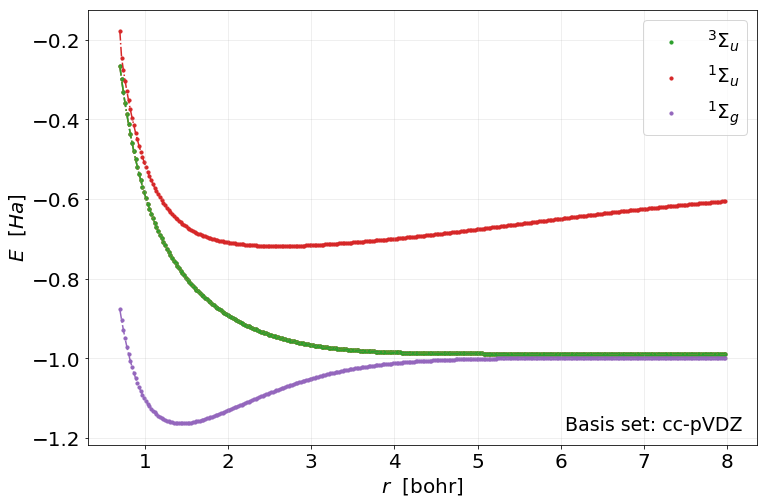

In [14]:
plotfunction_diatomic_exc([RJ,RJ],[EEOM,ECC],basis,[['','',r'${}^3\Sigma_u$',r'${}^1\Sigma_u$'],r'${}^1\Sigma_g$'])

In [15]:
# function [x, error, iter, flag] = gmres( A, x, b, M, restrt, max_it, tol )

# %  -- Iterative template routine --
# %     Univ. of Tennessee and Oak Ridge National Laboratory
# %     October 1, 1993
# %     Details of this algorithm are described in "Templates for the
# %     Solution of Linear Systems: Building Blocks for Iterative
# %     Methods", Barrett, Berry, Chan, Demmel, Donato, Dongarra,
# %     Eijkhout, Pozo, Romine, and van der Vorst, SIAM Publications,
# %     1993. (ftp netlib2.cs.utk.edu; cd linalg; get templates.ps).
# %
# % [x, error, iter, flag] = gmres( A, x, b, M, restrt, max_it, tol )
# %
# % gmres.m solves the linear system Ax=b
# % using the Generalized Minimal residual ( GMRESm ) method with restarts .
# %
# % input   A        REAL nonsymmetric positive definite matrix
# %         x        REAL initial guess vector
# %         b        REAL right hand side vector
# %         M        REAL preconditioner matrix
# %         restrt   INTEGER number of iterations between restarts
# %         max_it   INTEGER maximum number of iterations
# %         tol      REAL error tolerance
# %
# % output  x        REAL solution vector
# %         error    REAL error norm
# %         iter     INTEGER number of iterations performed
# %         flag     INTEGER: 0 = solution found to tolerance
# %                           1 = no convergence given max_it

#    iter = 0;                                         % initialization
#    flag = 0;

#    bnrm2 = norm( b );
#    if  ( bnrm2 == 0.0 ), bnrm2 = 1.0; end

#    r = M \ ( b-A*x );
#    error = norm( r ) / bnrm2;
#    if ( error < tol ) return, end

#    [n,n] = size(A);                                  % initialize workspace
#    m = restrt;
#    V(1:n,1:m+1) = zeros(n,m+1);
#    H(1:m+1,1:m) = zeros(m+1,m);
#    cs(1:m) = zeros(m,1);
#    sn(1:m) = zeros(m,1);
#    e1    = zeros(n,1);
#    e1(1) = 1.0;

#    for iter = 1:max_it,                              % begin iteration

#       r = M \ ( b-A*x );
#       V(:,1) = r / norm( r );
#       s = norm( r )*e1;
#       for i = 1:m,                                   % construct orthonormal
# 	 w = M \ (A*V(:,i));                         % basis using Gram-Schmidt
# 	 for k = 1:i,
# 	   H(k,i)= w'*V(:,k);
# 	   w = w - H(k,i)*V(:,k);
# 	 end
# 	 H(i+1,i) = norm( w );
# 	 V(:,i+1) = w / H(i+1,i);
# 	 for k = 1:i-1,                              % apply Givens rotation
#             temp     =  cs(k)*H(k,i) + sn(k)*H(k+1,i);
#             H(k+1,i) = -sn(k)*H(k,i) + cs(k)*H(k+1,i);
#             H(k,i)   = temp;
# 	 end
# 	 [cs(i),sn(i)] = rotmat( H(i,i), H(i+1,i) ); % form i-th rotation matrix
#          temp   = cs(i)*s(i);                        % approximate residual norm
#          s(i+1) = -sn(i)*s(i);
# 	 s(i)   = temp;
#          H(i,i) = cs(i)*H(i,i) + sn(i)*H(i+1,i);
#          H(i+1,i) = 0.0;
# 	 error  = abs(s(i+1)) / bnrm2;
# 	 if ( error <= tol ),                        % update approximation
# 	    y = H(1:i,1:i) \ s(1:i);                 % and exit
#             x = x + V(:,1:i)*y;
# 	    break;
# 	 end
#       end

#       if ( error <= tol ), break, end
#       y = H(1:m,1:m) \ s(1:m);
#       x = x + V(:,1:m)*y;                            % update approximation
#       r = M \ ( b-A*x )                              % compute residual
#       s(i+1) = norm(r);
#       error = s(i+1) / bnrm2;                        % check convergence
#       if ( error <= tol ), break, end;
#    end

#    if ( error > tol ) flag = 1; end;                 % converged

# % END of gmres.m

# function [ c, s ] = rotmat( a, b )

# %
# % Compute the Givens rotation matrix parameters for a and b.
# %
#    if ( b == 0.0 ),
#       c = 1.0;
#       s = 0.0;
#    elseif ( abs(b) > abs(a) ),
#       temp = a / b;
#       s = 1.0 / sqrt( 1.0 + temp^2 );
#       c = temp * s;
#    else
#       temp = b / a;
#       c = 1.0 / sqrt( 1.0 + temp^2 );
#       s = temp * c;
#    end